In [3]:
import pandas as pd
import numpy as np
from statistics import mean
import os
from typing import List, Dict, Tuple, Union, Any
import random
import torch
from torch import nn
from torch.nn import functional as F

import time
from tqdm import tqdm

from collections import defaultdict
from collections import Counter
from itertools import chain

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import AutoModelForSequenceClassification,  AutoTokenizer, EarlyStoppingCallback, get_linear_schedule_with_warmup

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix, precision_score, recall_score

from IPython.display import Markdown, display

def display_markdown(markdown_text: str):
    display(Markdown(markdown_text))


In [2]:
# # Setting up the device for GPU usage
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(f'Using {device}.')

Using cuda.


In [4]:
df = pd.read_json('/kaggle/input/ediref-1/dataset.json')
# Replace NaN values in the 'triggers' column with 0.0
df['triggers'] = df['triggers'].apply(lambda x: [0.0 if pd.isna(val) else val for val in x])
df.head()

,episode,speakers,emotions,utterances,triggers
0,utterance_0,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise]",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 1.0, 0.0]"
1,utterance_1,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
2,utterance_2,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
3,utterance_3,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,utterance_4,"[Joey, Rachel, Joey, Rachel]","[surprise, sadness, surprise, fear]",[But then who? The waitress I went out with la...,"[0.0, 0.0, 1.0, 0.0]"


In [4]:
df_exploded = df.explode('emotions')

# Get the count of unique elements
number_emotions = df_exploded['emotions'].nunique()
print("Number of unique elements in the 'emotions' column:", number_emotions)

number_triggers = max(len(set(dialogue))for dialogue in df_exploded['triggers'])
print("Number of unique elements in the 'triggers' column:", number_triggers)

unique_emotions = df_exploded['emotions'].unique()
print("Unique elements in the 'emotions' column:", unique_emotions)

id2label={id:label for id,label in enumerate(unique_emotions)}
label2id={label:id for id,label in enumerate(unique_emotions)}
print(id2label)
print(label2id)

df["emotions"] = df["emotions"].apply(lambda x: [label2id[item.strip()] for item in x])
df.head()

Number of unique elements in the 'emotions' column: 7

Number of unique elements in the 'triggers' column: 2

Unique elements in the 'emotions' column: ['neutral' 'surprise' 'fear' 'sadness' 'joy' 'disgust' 'anger']

{0: 'neutral', 1: 'surprise', 2: 'fear', 3: 'sadness', 4: 'joy', 5: 'disgust', 6: 'anger'}

{'neutral': 0, 'surprise': 1, 'fear': 2, 'sadness': 3, 'joy': 4, 'disgust': 5, 'anger': 6}


,episode,speakers,emotions,utterances,triggers
0,utterance_0,"[Chandler, The Interviewer, Chandler, The Inte...","[0, 0, 0, 0, 1]",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 1.0, 0.0]"
1,utterance_1,"[Chandler, The Interviewer, Chandler, The Inte...","[0, 0, 0, 0, 1, 0, 0]",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
2,utterance_2,"[Chandler, The Interviewer, Chandler, The Inte...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2]",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
3,utterance_3,"[Chandler, The Interviewer, Chandler, The Inte...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 1]",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,utterance_4,"[Joey, Rachel, Joey, Rachel]","[1, 3, 1, 2]",[But then who? The waitress I went out with la...,"[0.0, 0.0, 1.0, 0.0]"


The dataset contains incremental dialogues, i.e, many rows represents the same dialogue with added utterances. Thus assigning unique dialogue_idx to the rows with non incremental utterances. A new dialogue is assumed to start whenever the set of utterances in the current row is not a subset of the set of utterances in the next row.

In [5]:
rows = [row[-1] for row in list(df.iterrows())]
#print(rows)
dialogue_idx: int = 0

for idx, row in enumerate(rows):
  if idx != len(rows) - 1 and not set(row["utterances"]).issubset(set(rows[idx+1]["utterances"])):
    row["dialogue_idx"] = dialogue_idx
    dialogue_idx += 1
  else:
    row["dialogue_idx"] = dialogue_idx

df = pd.DataFrame(rows)
# Print the updated dataframe
df

,episode,speakers,emotions,utterances,triggers,dialogue_idx
0,utterance_0,"[Chandler, The Interviewer, Chandler, The Inte...","[0, 0, 0, 0, 1]",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 1.0, 0.0]",0
1,utterance_1,"[Chandler, The Interviewer, Chandler, The Inte...","[0, 0, 0, 0, 1, 0, 0]",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",0
2,utterance_2,"[Chandler, The Interviewer, Chandler, The Inte...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2]",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",0
3,utterance_3,"[Chandler, The Interviewer, Chandler, The Inte...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 1]",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
4,utterance_4,"[Joey, Rachel, Joey, Rachel]","[1, 3, 1, 2]",[But then who? The waitress I went out with la...,"[0.0, 0.0, 1.0, 0.0]",1
...,...,...,...,...,...,...
3995,utterance_3995,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[0, 4, 0, 0, 1, 5, 0, 5, 1, 0, 0, 5]","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",833
3996,utterance_3996,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[0, 4, 0, 0, 1, 5, 0, 5, 1, 0, 0, 5, 5, 0]","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",833
3997,utterance_3997,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[0, 4, 0, 0, 1, 5, 0, 5, 1, 0, 0, 5, 5, 0, 0]","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",833
3998,utterance_3998,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[0, 4, 0, 0, 1, 5, 0, 5, 1, 0, 0, 5, 5, 0, 0, 1]","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",833


The distribution of dialogs within the training set and the validation set are very different thus we shuffle the dataset making sure that the training and validation sets are distributed uniformly, leading to improve in overall performance of the models from previous not shuffled dataset.

In [6]:
# Define the sizes for each split
train_size = 0.8
val_size = 0.1
test_size = 0.1
# Shuffle the DataFrame rows
shuffled_df = df.sample(frac=1, random_state=42) # frac=1 means to shuffle all rows

# Resetting index after shuffling
shuffled_df = shuffled_df.reset_index(drop=True)

columns = ["utterances", "emotions", "triggers", "dialogue_idx"]

train, temp = train_test_split(shuffled_df["dialogue_idx"].unique(), test_size=(1-train_size),
                                         random_state=42)
val, test = train_test_split(temp, test_size=(test_size / (val_size + test_size)),
                                        random_state=42)

train_data = shuffled_df[shuffled_df["dialogue_idx"].isin(train)][columns].reset_index(drop=True)
valid_data = shuffled_df[shuffled_df["dialogue_idx"].isin(val)][columns].reset_index(drop=True)
test_data = shuffled_df[shuffled_df["dialogue_idx"].isin(test)][columns].reset_index(drop=True)

# Print the sizes of the splits
print(f"Train set size: {len(train_data)} dialogues")
print(f"Validation set size: {len(valid_data)} dialogues")
print(f"Test set size: {len(test_data)} dialogues")

#one_hot_train_labels = to_categorical(train_labels, num_classes=number_emotions)
print("Train set emotion:", test_data.iloc[4]['emotions'])
print("Train set trigger:", test_data.iloc[399]['triggers'])
print(test_data.iloc[10])
test_data

Train set size: 3187 dialogues

Validation set size: 394 dialogues

Test set size: 419 dialogues

Train set emotion: [4, 4, 4, 0]

Train set trigger: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]

utterances      [Hey, Mon., Hey-hey-hey. You wanna hear someth...

emotions                                             [0, 0, 4, 3]

triggers                                     [0.0, 0.0, 0.0, 1.0]

dialogue_idx                                                    2

Name: 10, dtype: object


,utterances,emotions,triggers,dialogue_idx
0,"[Oh my God! Oh my God! I'm so sorry!, Aw forge...","[2, 0, 6, 3]","[0.0, 0.0, 1.0, 0.0]",119
1,"[Okay, see that blind guy right there? I'm gon...","[6, 4]","[0.0, 1.0]",14
2,"[Hi!, Another cheesecake came! They delivered ...","[4, 6, 0, 3]","[0.0, 0.0, 1.0, 1.0]",366
3,"[I just didn't see the fast song coming., Shh....","[1, 0, 0, 0, 0, 4, 0, 6, 0, 0, 0, 1, 6, 1]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, ...",267
4,"[Hey!, Welcome back!, Hey! Can we pick up whe...","[4, 4, 4, 0]","[0.0, 0.0, 1.0, 0.0]",260
...,...,...,...,...
414,"[Oh Mon, listen I have to ask!, Okay, Joey Tri...","[1, 0]","[0.0, 1.0]",419
415,"[Here's the thing, Janice., You know, I mean, ...","[0, 0, 6, 0, 1, 6, 3]","[1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]",293
416,"[What, Phoebe, did you whip the potatoes? Ross...","[6, 3, 1, 3, 0, 4, 1, 0, 0, 0, 1]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",436
417,"[Well, maybe it's a contest, y'know? Like, col...","[0, 0, 5, 6, 5, 6, 1, 6, 6, 6, 6, 6, 5, 6]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",492


In [8]:
# Sections of config

# Defining some key variables that will be used later on in the training
MODEL_NAME = 'bert-base-uncased'
thresh = 0.5
BATCH_SIZE = 20#5
EPOCHS = 12
LEARNING_RATE = 2e-05
OUT_CHANNELS = 768 if "base" in  MODEL_NAME else 1024
model_dir= 'model/'

seeds = [42, 123, 456, 789, 999]
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [9]:
# Function to ensure the directory exists
def ensure_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

ensure_directory(model_dir)

In [10]:
window_size = 2

def max_token_per_dialog(dialogues):
    max_tokens = 0
    second_max_tokens = 0
    num_dialogues_with_max_tokens = 0
    num_dialogues_with_second_max_tokens = 0

    for dialogue in dialogues:
        for utterance_idx in range(len(dialogue)):
            start_idx = max(0, utterance_idx - window_size + 1)
            end_idx = min(utterance_idx + 1, len(dialogue))
            window_text = ' [SEP] '.join(dialogue[start_idx:end_idx])
            encoded_tokens = tokenizer.encode(window_text, add_special_tokens=True)
            num_tokens = len(encoded_tokens)

            if num_tokens > max_tokens:
                second_max_tokens = max_tokens
                max_tokens = num_tokens
                num_dialogues_with_second_max_tokens = num_dialogues_with_max_tokens
                num_dialogues_with_max_tokens = 1
            elif num_tokens == max_tokens:
                num_dialogues_with_max_tokens += 1
            elif num_tokens > second_max_tokens:
                second_max_tokens = num_tokens
                num_dialogues_with_second_max_tokens = 1
            elif num_tokens == second_max_tokens:
                num_dialogues_with_second_max_tokens += 1

    return max_tokens, num_dialogues_with_max_tokens, second_max_tokens, num_dialogues_with_second_max_tokens

max_tokens, num_dialogues, second_max_tokens, num_dialogues_second = max_token_per_dialog(df['utterances'])

print(f"The maximum number of tokens in any utterance across the entire dataset is: {max_tokens}")
print(f"Number of dialogues with the maximum tokens: {num_dialogues}")
print(f"The second maximum number of tokens: {second_max_tokens}")
print(f"Number of dialogues with the second maximum tokens: {num_dialogues_second}")


The maximum number of tokens in any utterance across the entire dataset is: 114

Number of dialogues with the maximum tokens: 4

The second maximum number of tokens: 99

Number of dialogues with the second maximum tokens: 7


A `context window` is created around each utterance within a dialogue. This window captures a certain number of utterances before the current utterance, here considering the previous utterance along with the current one,  allowing the model to consider the conversational context when predicting emotions and triggers.

Including the previous utterance along with the current one shows a `little increase around 5.36%` in the predicion scores.

The `max_length` is equal to the max no of tokens calculated for window size = 2

In [11]:
class DialogDataset(Dataset):
    def __init__(self, dataset, tokenizer, max_length):
        self.data = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        
        if type(idx) == list:
            idx = idx[0] 
            
        dialogue = self.data.iloc[idx]["utterances"]
        #print("OLD: ", dialogue)
        new_dialogue = []
        for utterance_idx, utterance in enumerate(dialogue):
            # Concatenate all utterances according to window size
            start_idx = max(0, utterance_idx - window_size + 1)
            end_idx = min(utterance_idx + 1, len(dialogue))
            text = ' [SEP] '.join(dialogue[start_idx:end_idx])

            new_dialogue.append(text)
            
            
        tokenized_dialogue = self.tokenizer(new_dialogue, truncation=True, padding="max_length", max_length=self.max_length, return_tensors='pt')
        emotions = self.data.iloc[idx]["emotions"]
        triggers = self.data.iloc[idx]["triggers"]

        return {"utterances": new_dialogue,
                "input_ids": tokenized_dialogue["input_ids"],
                "attention_mask": tokenized_dialogue["attention_mask"],
                "emotions": torch.LongTensor(emotions),
                "triggers": torch.FloatTensor(triggers)}

In [12]:
train_dataset = DialogDataset(train_data, tokenizer, max_tokens)
val_dataset = DialogDataset(valid_data, tokenizer, max_tokens)
test_dataset = DialogDataset(test_data, tokenizer, max_tokens)

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

i=0
for batch in test_dataloader:
    print("11111111111")
    print("Utterance:", batch['utterances'])
    print("Example input_ids:", batch['input_ids'][0].flatten().shape)
    print(batch['input_ids'].shape)
    print("Attention Mask shape:", batch["attention_mask"][0].shape)
    print("Example emotions:", batch['emotions'])
    print("Example triggers:", batch['triggers'])
    break  # Stop after printing the first batch
    
i=0
for c, batch_data in enumerate(train_dataloader):
    print("222222222222")
    print(c)
    utt= batch['utterances']
    input_ids = batch_data["input_ids"]
    attention_mask = batch_data["attention_mask"]
    emotions = batch_data["emotions"]
    triggers = batch_data["triggers"]
    print(input_ids)

    print(f"Batch {c + 1}:")
    print("Utterance:", utt)
    print("Input IDs shape:", input_ids.shape)
    input_ids_2 = input_ids.view(-1,input_ids.size(-1))
    print("reshaped input_ids.view(-1,input_ids.size(-1))", input_ids_2.shape)
    print("Attention Mask shape:", attention_mask.shape)
    print("Emotions shape:", emotions.shape, emotions)
    emotions = emotions.view(-1)
    print("New Emotions.view(-1,1):", emotions.shape, emotions)
    print("Triggers shape:", triggers.shape, triggers)
    triggers = triggers.view(-1,1)
    print("New triggers.view(-1,1)", triggers.shape, triggers)
    n_tri= triggers.flatten()
    print("New tri.flatten()", n_tri.shape, n_tri)
    break

11111111111

Utterance: [("Oh my God! Oh my God! I'm so sorry!",), ("Oh my God! Oh my God! I'm so sorry! [SEP] Aw forget it, it's from",), ("Aw forget it, it's from [SEP] You think you can knock up my daughter and then not marry her?! I'm gonna kill you!!",), ("You think you can knock up my daughter and then not marry her?! I'm gonna kill you!! [SEP] Y'know this is actually not a great time for me.",)]

Example input_ids: torch.Size([456])

torch.Size([1, 4, 114])

Attention Mask shape: torch.Size([4, 114])

Example emotions: tensor([[2, 0, 6, 3]])

Example triggers: tensor([[0., 0., 1., 0.]])

222222222222

0

tensor([[[  101,  6887,  4402,  5910,  1010,  2064,  2017,  2393,  2033,  4060,

           2041,  2019,  8147,  3614,  2005,  9018,  1029,   102,     0,     0,

              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,

              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,

              0,     0,     0,     0,     0,     0,     0

Computing the class weights for classes 'emotions' and 'triggers' based on the distribution of samples in the Dataset (df). 

In [13]:
class_weights_emotions = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(df.explode("emotions")["emotions"]),
    y=df.explode("emotions")["emotions"].values.reshape(-1)
)

class_weight_positive_trigger = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(df.explode("triggers")["triggers"]),
    y=df.explode("triggers")["triggers"].values.reshape(-1)
)[-1] # Take the weight value for the positive class

print(f"Emotion class weights: {class_weights_emotions}\n")
print(f"Positive trigger class weight: {class_weight_positive_trigger}")

emotion_loss_fn = nn.CrossEntropyLoss(weight=torch.tensor(class_weights_emotions, dtype=torch.float32).to(device))
trigger_loss_fn = nn.BCELoss()

Emotion class weights: [0.3275896  1.07642626 4.48833034 1.88821752 0.79151496 4.76644423

 1.26135217]



Positive trigger class weight: 3.1390134529147984


### Early Stopping

In [14]:
class EarlyStopper:
    def __init__(self, patience: int = 1, min_delta: int = 0) -> None:
        self.patience = patience
        self.min_delta = min_delta
        self.min_validation_loss = float("inf")
        self.__epochs_no_improve = 0

    def early_stop(self, validation_loss: float) -> Tuple[bool, bool]:
        new_best_loss: bool = validation_loss < self.min_validation_loss
        if new_best_loss:
            self.min_validation_loss = validation_loss
            self.__epochs_no_improve = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.__epochs_no_improve += 1
            if self.__epochs_no_improve >= self.patience:
                return True, new_best_loss
        return False, new_best_loss

### Metrics

To compute the below metrics for model evaluation for emotions and triggers labels.

- `Sequence F1`: computing the f1-score for each dialogue and reporting the average score.

- `Unrolled Sequence F1`: flattening all utterances and computing the f1-score.


In [15]:
def sequence_unrolled_f1(y_pred, y_true):
    
    # Sequence F1
    sequence_f1_scores = []
    for pred, true in zip(y_pred, y_true):
        if len(pred) != len(true):
            raise ValueError("Prediction and label dialogue lengths must match")
        sequence_f1_scores.append(f1_score(true, pred, average="macro"))

    avg_sequence_f1 = np.mean(sequence_f1_scores)

    # Unrolled Sequence F1
    all_pred = [item for sublist in y_pred for item in sublist]
    all_test = [item for sublist in y_true for item in sublist]
    unrolled_sequence_f1 = f1_score(all_test, all_pred, average="macro")

    return avg_sequence_f1, unrolled_sequence_f1

def compute_metrics(pred_emotions,emotion_labels, pred_triggers, triggers):

    seq_f1_emotions, unrolled_f1_emotions = sequence_unrolled_f1(pred_emotions,emotion_labels)
    seq_f1_triggers, unrolled_f1_triggers = sequence_unrolled_f1(pred_triggers, triggers)

    return seq_f1_emotions,seq_f1_triggers, unrolled_f1_emotions, unrolled_f1_triggers

# Multi Task classifier Model.

A PyTorch model designed for emotion and trigger prediction in text data. Here's a breakdown of its components:

- <b>Model and Tokenizer</b>:

   <b>AutoModel</b> from Hugging Face can automatically retrieve the relevant model given the name/path to the pretrained     weights/config/vocabulary.
   - We instantiate one of the AutoModel: <i>`AutoModelForSequenceClassification`</i> – This class is used to get the input text embeddings
   - <i>AutoTokenizer</i>- for loading the corresponding tokenizer for the model

   And load the corresponding AutoModel and tokenizer <b>'bert-base-uncased'</b> by using  the <i>from_pretrained</i> that directly create a class of the relevant architecture
   
   We consider two different settings:

     - `Freezed`: we freeze the BERT embedding layer weights and fine-tune the classifier heads on top
     
     - `Full`: we fine-tune the whole model architecture. 

   The BERT model is expected to return hidden states (output_hidden_states=True).

- <b>Classification</b>

  1. <b>Emotion</b>:

     A single <i>`linear layer`</i> for multi-class emotion prediction directly from the BERT output. 
      - The BERT model is used to extract contextualized embeddings of the input text.
      - The extracted CLS token representation is used for emotion prediction.
      - The emotion classifier linear layer is applied to the CLS token representation to predict the probabilities of different emotion classes.

  2. <b>Trigger</b>:
  
     A <i>`bidirectional LSTM`</i> layer is defined for trigger prediction.

     Followed by a <i>`feed-forward neural network`</i>, defined after the LSTM layer for trigger prediction. It consists of a <i>`linear layer, ReLU activation, another linear layer, and a sigmoid activation`</i> function for binary trigger prediction.
     
     - The LSTM layer processes the BERT output to capture sequential dependencies for trigger prediction.
     - The LSTM outputs are passed through a feed-forward neural network (trigger_classifier) to predict trigger labels.


In [16]:
class MultiTaskModel(nn.Module):
    """
    Multi Task classifier Model Class.

    Parameters:
    - num_emotions: int 
        The number of emotion classes for prediction.
    - num_lstm_layers: int 
        The number of LSTM hidden layers.
    - lstm_hidden_size: int 
        The hidden size of the LSTM layer(s) for trigger prediction.
    - ffnn_hidden_size: int 
        The hidden size of the feed-forward neural networks.
    - freeze_bert: bool, optional
        The model variant in case of BERT : Freezed/ Full
    - random_state: int, optional 
        The random seed for reproducibility.

    Returns:
    - tensors
        Emotion and trigger logits.
    """
    def __init__(self, num_emotions: int,
                 num_lstm_layers: int,
                 lstm_hidden_size: int,
                 ffnn_hidden_size: int,
                 freeze_bert: bool = False,
                 random_state: int = None) -> None:
        super(MultiTaskModel, self).__init__()
        
        if random_state is not None:
            torch.manual_seed(random_state)
            torch.cuda.manual_seed_all(random_state)
            
        self.bert = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME,
                                                                                num_labels=num_emotions,
                                                                                output_hidden_states=True)
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False  # Freeze BERT embedding layer weights

        # Linear layer for emotion prediction
        self.emotion_classifier = nn.Linear(self.bert.config.hidden_size, num_emotions)
        
        # LSTM for trigger prediction
        self.lstm = nn.LSTM(input_size=self.bert.config.hidden_size,
                            hidden_size=lstm_hidden_size,
                            num_layers=num_lstm_layers,
                            batch_first=True,
                            bidirectional=True)

        # Feed-forward neural network for trigger prediction
        self.trigger_classifier = nn.Sequential(
            nn.Linear(lstm_hidden_size * 2, ffnn_hidden_size),
            nn.ReLU(),
            nn.Dropout(p=.2),
            nn.Linear(ffnn_hidden_size, 1),
            nn.Sigmoid()
        )

    def forward(self, input_ids, attention_mask, token_type_ids=None):

        bert_outputs = self.bert(**{"input_ids": input_ids,
                                              "attention_mask": attention_mask}).hidden_states[-1]

        # Extract CLS token for emotion prediction
        output = bert_outputs[:, 0, :]

        emotion_logits = self.emotion_classifier(output)  # Multi-label output

        # LSTM for trigger prediction
        lstm_outputs, _ = self.lstm(output)

        # Feed-forward neural network for trigger prediction
        trigger_logits = self.trigger_classifier(lstm_outputs) # Binary output

        return emotion_logits, trigger_logits
    

## Training and Validation

- `Batch Size= 1` is considered, thus processing one dialogue at a time.
- Each dialogue has multiple utterances, thus tokenized dialogue tensor has shape `[batch_size, n_utterances, n_max_tokens]`, where batch_size=1. hence removing the first dimension and passing input of shape `[n_utterances, n_max_tokens]`. 
- Two loss functions are computed and combined weighting the values, and the parameters are updated through backward propagation. 
  - <b>CrossEntropyLoss()</b>: This is used for multi-class Emotion classification
  - <b>BCELoss()</b>: Binary Cross Entropy Loss is used for binary Trigger classification
- The validation metrics is returned.

In [17]:
def evaluate_bert_model(model, eval_dataloader):
    model.eval()
    total_val_loss: float = 0.0
    fin_emotion_labels, emotion_pred, fin_trigger_labels, trigger_pred = [], [], [], []
    with torch.no_grad():
        for count,batch in enumerate(eval_dataloader):
            val_input_ids, val_attention_mask, val_emotions, val_triggers = batch['input_ids'], batch["attention_mask"], batch['emotions'], batch['triggers']
            val_input_ids= val_input_ids.view(-1,input_ids.size(-1)).to(device)
            val_attention_mask= val_attention_mask.view(-1,input_ids.size(-1)).to(device)
            val_emotion_labels = val_emotions.view(-1).to(device)
            val_trigger_labels = val_triggers.view(-1).to(device)

            val_emotion_logits, val_trigger_probs = model(val_input_ids, val_attention_mask)

            val_emotion_loss = emotion_loss_fn(val_emotion_logits, val_emotion_labels)
            val_trigger_loss = trigger_loss_fn(val_trigger_probs.view(-1), val_trigger_labels)

            val_loss = 0.8 * val_emotion_loss + 0.2 * val_trigger_loss

            total_val_loss += val_loss.item()

            fin_emotion_labels.append(val_emotion_labels.detach().cpu())
            emotion_prob=torch.softmax(val_emotion_logits, dim=1)
            emotion_pred.append(torch.argmax(emotion_prob, dim=1).detach().cpu().numpy())

            fin_trigger_labels.append(val_trigger_labels.detach().cpu())
            trigger_pred.append((val_trigger_probs > .5).int().detach().cpu().numpy())

        avg_val_loss = total_val_loss / len(eval_dataloader)
        
        # Evaluate on validation data
        seq_f1_emotions, seq_f1_triggers, unrolled_f1_emotions, unrolled_f1_triggers = compute_metrics(fin_emotion_labels, emotion_pred, fin_trigger_labels, trigger_pred)
        metrics = {"seq_f1_emotions": {round(seq_f1_emotions,2)},
            "seq_f1_triggers": {round(seq_f1_triggers,2)},
            "unrolled_f1_emotions": {round(unrolled_f1_emotions,2)},
            "unrolled_f1_triggers": {round(unrolled_f1_triggers,2)}}
    return avg_val_loss, metrics

# Train and evaluate model
def train_bert_model(mdir,model,n_epochs,train_dataloader,eval_dataloader,optimizer,scheduler,accumulation_steps: int = 32):

    early_stopper = EarlyStopper(patience=2, min_delta=1e-2)
    
    best_val_loss = float('inf')
    best_model_state_dict = None
    
    model.to(device)

    seq_f1_emotions_list, seq_f1_triggers_list, unrolled_f1_emotions_list, unrolled_f1_triggers_list = [],[], [], []
    for epoch in tqdm(range(n_epochs)):  # Adjust number of epochs
        start_time = time.time()
        total_train_loss: float = 0.0
        
        model.train()
        optimizer.zero_grad()  # Initializing gradients to zero at the start of the epoch
        for count, batch in enumerate(train_dataloader):
            input_ids, attention_mask, emotions, triggers = batch['input_ids'], batch["attention_mask"], batch['emotions'], batch['triggers']
            input_ids= input_ids.view(-1,input_ids.size(-1)).to(device)
            attention_mask= attention_mask.view(-1,input_ids.size(-1)).to(device)
            emotion_labels = emotions.view(-1).to(device)
            trigger_labels = triggers.view(-1).to(device)

            emotion_logits, trigger_probs = model(input_ids, attention_mask)
            emotion_loss = emotion_loss_fn(emotion_logits, emotion_labels)

            trigger_loss = trigger_loss_fn(trigger_probs.view(-1), trigger_labels)

            loss = 0.8 * emotion_loss + 0.2 * trigger_loss  # Combining losses
            loss = loss / accumulation_steps  # Scaling loss
            loss.backward()
            
            total_train_loss += loss.item() * accumulation_steps
            
            if (count + 1) % accumulation_steps == 0 or (count + 1) == len(train_dataloader):
                optimizer.step()  # Updating model parameters
                scheduler.step()  # Updating learning rate
                optimizer.zero_grad()  # Clear gradients

            if count%1000==0:
                current =  count * len(batch['input_ids'])
                elapsed_time = time.time() - start_time  # Calculate elapsed time since epoch start
                print(f"Train loss: {loss.item():>7f} E_loss: {emotion_loss.item():>7f} T_loss: {trigger_loss.item():>7f} [{current:>5d}/{len(train_dataloader.dataset):>5d}]  Epoch {epoch+1}/{n_epochs} ({time.strftime('%H:%M:%S', time.gmtime(elapsed_time))})")
        avg_train_loss = total_train_loss / len(train_dataloader)

        avg_valid_loss, metrics = evaluate_bert_model(model, eval_dataloader)
        
        # Print the metrics for this epoch
        print(f"Epoch:{epoch+1},Training loss: {round(avg_train_loss,8)},Validation loss: {round(avg_valid_loss,8)}, ", metrics)

        # Early stopping check
        trigger_early_stopping, found_best_loss = early_stopper.early_stop(avg_valid_loss)
        if trigger_early_stopping:
            print("Early stopped triggered.")
            break
            
        ## TODO: save the model if validation loss has decreased
        if found_best_loss and avg_valid_loss <= best_val_loss:

            best_val_loss = avg_valid_loss
            best_model_state_dict = model.state_dict()
            
    print('Mininmum Validation loss {:.8f}.  Saving model to Dir : {}'.format(best_val_loss, mdir))
    torch.save(best_model_state_dict, mdir)

    return metrics
    



## Training and Evaluation : Metrics

In [19]:
def train_evaluate_classifiers(freeze_bert=False):
    """
    Train and evaluate classifiers on the training and validation set.

    Parameters:
    - variation: str, optional
        The model variant in case of BERT : Freezed/ Full

    Returns:
    - pd.DataFrame
        Dataframe containing metrics for each seed.
    """
    metrics_df=[]
    all_metrics = []

    for i, seed in enumerate(seeds):
        #set_seed(seed)
        print(f"Seed : {seed}...")
        # Training the BERT model for each seed
        if freeze_bert:
            mdir = os.path.join(model_dir,"bert_frozen_bert_seed_{}".format(seed))  # Include seed in filename
        else:
            mdir = os.path.join(model_dir,"bert_full_bert_seed_{}".format(seed))

        n_epochs: int = 20
        learning_rate: float = 1e-5
        num_lstm_layers: int = 8
        lstm_hidden_size: int = 128
        ffnn_hidden_size: int = 64
        weight_decay=1e-4
        
        model_class = MultiTaskModel
        

        model = model_class(number_emotions,
                  num_lstm_layers,
                  lstm_hidden_size,
                  ffnn_hidden_size,
                  freeze_bert,
                  seed)
        
        optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        num_warmup_steps = int(0.1 * len(train_data) * n_epochs)
        scheduler = get_linear_schedule_with_warmup(optimizer,
                                        num_warmup_steps=num_warmup_steps,
                                        num_training_steps=len(train_data) * n_epochs)

        metrics = train_bert_model(mdir,model,
                      n_epochs,
                      train_dataloader,
                      val_dataloader,
                      optimizer,
                      scheduler)
        
        metrics= {'Seed' : seed, **metrics}
        all_metrics.append(metrics)


    metrics_df = pd.DataFrame(all_metrics)

    return metrics_df

## Full BERT Training

In [19]:
full_bert_validation_metrics = train_evaluate_classifiers(freeze_bert=False)
display_markdown("# Full_bert validation Metrics")
full_bert_validation_metrics

Seed : 42...


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']

You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 0.048846 E_loss: 1.790460 T_loss: 0.653503 [    0/ 3200]  Epoch 1/20 (00:00:01)

Train loss: 0.046593 E_loss: 1.701477 T_loss: 0.648905 [ 1000/ 3200]  Epoch 1/20 (00:02:39)

Train loss: 0.051446 E_loss: 1.896867 T_loss: 0.643823 [ 2000/ 3200]  Epoch 1/20 (00:05:16)

Train loss: 0.050757 E_loss: 1.868003 T_loss: 0.649158 [ 3000/ 3200]  Epoch 1/20 (00:07:54)


  5%|▌         | 1/20 [08:52<2:48:32, 532.22s/it]

Epoch:1,Training loss: 1.68775682,Validation loss: 1.66591295,  {'seq_f1_emotions': {0.19}, 'seq_f1_triggers': {0.43}, 'unrolled_f1_emotions': {0.11}, 'unrolled_f1_triggers': {0.44}}

Train loss: 0.057713 E_loss: 2.147114 T_loss: 0.645608 [    0/ 3200]  Epoch 2/20 (00:00:00)

Train loss: 0.048938 E_loss: 1.787466 T_loss: 0.680258 [ 1000/ 3200]  Epoch 2/20 (00:02:36)

Train loss: 0.051488 E_loss: 1.896352 T_loss: 0.652675 [ 2000/ 3200]  Epoch 2/20 (00:05:17)

Train loss: 0.048892 E_loss: 1.789682 T_loss: 0.664051 [ 3000/ 3200]  Epoch 2/20 (00:07:56)


 10%|█         | 2/20 [17:45<2:39:51, 532.83s/it]

Epoch:2,Training loss: 1.67324393,Validation loss: 1.64998543,  {'seq_f1_emotions': {0.2}, 'seq_f1_triggers': {0.43}, 'unrolled_f1_emotions': {0.13}, 'unrolled_f1_triggers': {0.44}}

Train loss: 0.047299 E_loss: 1.721682 T_loss: 0.681078 [    0/ 3200]  Epoch 3/20 (00:00:00)

Train loss: 0.046393 E_loss: 1.679100 T_loss: 0.706411 [ 1000/ 3200]  Epoch 3/20 (00:02:39)

Train loss: 0.057359 E_loss: 2.124949 T_loss: 0.677632 [ 2000/ 3200]  Epoch 3/20 (00:05:15)

Train loss: 0.046521 E_loss: 1.699598 T_loss: 0.644918 [ 3000/ 3200]  Epoch 3/20 (00:07:55)


 15%|█▌        | 3/20 [26:39<2:31:04, 533.18s/it]

Epoch:3,Training loss: 1.64542963,Validation loss: 1.62580917,  {'seq_f1_emotions': {0.26}, 'seq_f1_triggers': {0.43}, 'unrolled_f1_emotions': {0.21}, 'unrolled_f1_triggers': {0.44}}

Train loss: 0.047378 E_loss: 1.734993 T_loss: 0.640452 [    0/ 3200]  Epoch 4/20 (00:00:00)

Train loss: 0.059102 E_loss: 2.199988 T_loss: 0.656431 [ 1000/ 3200]  Epoch 4/20 (00:02:36)

Train loss: 0.060366 E_loss: 2.257027 T_loss: 0.630414 [ 2000/ 3200]  Epoch 4/20 (00:05:13)

Train loss: 0.058870 E_loss: 2.190764 T_loss: 0.656155 [ 3000/ 3200]  Epoch 4/20 (00:07:55)


 20%|██        | 4/20 [35:32<2:22:12, 533.26s/it]

Epoch:4,Training loss: 1.6075778,Validation loss: 1.59224255,  {'seq_f1_emotions': {0.26}, 'seq_f1_triggers': {0.43}, 'unrolled_f1_emotions': {0.21}, 'unrolled_f1_triggers': {0.44}}

Train loss: 0.050383 E_loss: 1.853366 T_loss: 0.647817 [    0/ 3200]  Epoch 5/20 (00:00:00)

Train loss: 0.041481 E_loss: 1.495679 T_loss: 0.654284 [ 1000/ 3200]  Epoch 5/20 (00:02:40)

Train loss: 0.056287 E_loss: 2.092346 T_loss: 0.636528 [ 2000/ 3200]  Epoch 5/20 (00:05:19)

Train loss: 0.048035 E_loss: 1.753216 T_loss: 0.672696 [ 3000/ 3200]  Epoch 5/20 (00:07:57)


 25%|██▌       | 5/20 [44:25<2:13:18, 533.24s/it]

Epoch:5,Training loss: 1.55738957,Validation loss: 1.53374928,  {'seq_f1_emotions': {0.32}, 'seq_f1_triggers': {0.43}, 'unrolled_f1_emotions': {0.28}, 'unrolled_f1_triggers': {0.44}}

Train loss: 0.047780 E_loss: 1.751498 T_loss: 0.638848 [    0/ 3200]  Epoch 6/20 (00:00:00)

Train loss: 0.056307 E_loss: 2.092747 T_loss: 0.638126 [ 1000/ 3200]  Epoch 6/20 (00:02:38)

Train loss: 0.045001 E_loss: 1.639726 T_loss: 0.641326 [ 2000/ 3200]  Epoch 6/20 (00:05:16)

Train loss: 0.040746 E_loss: 1.446402 T_loss: 0.733679 [ 3000/ 3200]  Epoch 6/20 (00:07:57)


 30%|███       | 6/20 [53:18<2:04:24, 533.17s/it]

Epoch:6,Training loss: 1.48779651,Validation loss: 1.46537532,  {'seq_f1_emotions': {0.33}, 'seq_f1_triggers': {0.43}, 'unrolled_f1_emotions': {0.31}, 'unrolled_f1_triggers': {0.44}}

Train loss: 0.049332 E_loss: 1.816151 T_loss: 0.628486 [    0/ 3200]  Epoch 7/20 (00:00:00)

Train loss: 0.043016 E_loss: 1.559295 T_loss: 0.645341 [ 1000/ 3200]  Epoch 7/20 (00:02:38)

Train loss: 0.037135 E_loss: 1.308797 T_loss: 0.706474 [ 2000/ 3200]  Epoch 7/20 (00:05:17)

Train loss: 0.059710 E_loss: 2.214427 T_loss: 0.695824 [ 3000/ 3200]  Epoch 7/20 (00:07:55)


 35%|███▌      | 7/20 [1:02:11<1:55:31, 533.21s/it]

Epoch:7,Training loss: 1.4065286,Validation loss: 1.40350416,  {'seq_f1_emotions': {0.37}, 'seq_f1_triggers': {0.43}, 'unrolled_f1_emotions': {0.37}, 'unrolled_f1_triggers': {0.44}}

Train loss: 0.039152 E_loss: 1.410139 T_loss: 0.623707 [    0/ 3200]  Epoch 8/20 (00:00:00)

Train loss: 0.035490 E_loss: 1.259299 T_loss: 0.641164 [ 1000/ 3200]  Epoch 8/20 (00:02:37)

Train loss: 0.033500 E_loss: 1.177126 T_loss: 0.651432 [ 2000/ 3200]  Epoch 8/20 (00:05:17)

Train loss: 0.048603 E_loss: 1.780060 T_loss: 0.656192 [ 3000/ 3200]  Epoch 8/20 (00:07:56)


 40%|████      | 8/20 [1:11:05<1:46:38, 533.24s/it]

Epoch:8,Training loss: 1.33049467,Validation loss: 1.3604043,  {'seq_f1_emotions': {0.37}, 'seq_f1_triggers': {0.43}, 'unrolled_f1_emotions': {0.37}, 'unrolled_f1_triggers': {0.44}}

Train loss: 0.043495 E_loss: 1.580451 T_loss: 0.637346 [    0/ 3200]  Epoch 9/20 (00:00:00)

Train loss: 0.044220 E_loss: 1.589149 T_loss: 0.718569 [ 1000/ 3200]  Epoch 9/20 (00:02:36)

Train loss: 0.026045 E_loss: 0.882693 T_loss: 0.636367 [ 2000/ 3200]  Epoch 9/20 (00:05:18)

Train loss: 0.058911 E_loss: 2.194868 T_loss: 0.646210 [ 3000/ 3200]  Epoch 9/20 (00:07:54)


 45%|████▌     | 9/20 [1:19:58<1:37:46, 533.33s/it]

Epoch:9,Training loss: 1.25849889,Validation loss: 1.33452638,  {'seq_f1_emotions': {0.39}, 'seq_f1_triggers': {0.43}, 'unrolled_f1_emotions': {0.4}, 'unrolled_f1_triggers': {0.44}}

Train loss: 0.019121 E_loss: 0.607894 T_loss: 0.627709 [    0/ 3200]  Epoch 10/20 (00:00:00)

Train loss: 0.041517 E_loss: 1.504462 T_loss: 0.624927 [ 1000/ 3200]  Epoch 10/20 (00:02:38)

Train loss: 0.033702 E_loss: 1.194347 T_loss: 0.614857 [ 2000/ 3200]  Epoch 10/20 (00:05:17)

Train loss: 0.036155 E_loss: 1.288288 T_loss: 0.631597 [ 3000/ 3200]  Epoch 10/20 (00:07:55)


 50%|█████     | 10/20 [1:28:51<1:28:52, 533.22s/it]

Epoch:10,Training loss: 1.1877408,Validation loss: 1.32990596,  {'seq_f1_emotions': {0.41}, 'seq_f1_triggers': {0.43}, 'unrolled_f1_emotions': {0.42}, 'unrolled_f1_triggers': {0.44}}

Train loss: 0.038881 E_loss: 1.391170 T_loss: 0.656231 [    0/ 3200]  Epoch 11/20 (00:00:00)

Train loss: 0.036471 E_loss: 1.298912 T_loss: 0.639718 [ 1000/ 3200]  Epoch 11/20 (00:02:42)

Train loss: 0.039070 E_loss: 1.407473 T_loss: 0.621243 [ 2000/ 3200]  Epoch 11/20 (00:05:17)

Train loss: 0.028400 E_loss: 0.977527 T_loss: 0.633853 [ 3000/ 3200]  Epoch 11/20 (00:07:57)


 55%|█████▌    | 11/20 [1:37:44<1:19:58, 533.18s/it]

Epoch:11,Training loss: 1.12120117,Validation loss: 1.31903544,  {'seq_f1_emotions': {0.38}, 'seq_f1_triggers': {0.43}, 'unrolled_f1_emotions': {0.4}, 'unrolled_f1_triggers': {0.44}}

Train loss: 0.063173 E_loss: 2.371131 T_loss: 0.623174 [    0/ 3200]  Epoch 12/20 (00:00:00)

Train loss: 0.070608 E_loss: 2.669532 T_loss: 0.619124 [ 1000/ 3200]  Epoch 12/20 (00:02:40)

Train loss: 0.025892 E_loss: 0.879770 T_loss: 0.623703 [ 2000/ 3200]  Epoch 12/20 (00:05:22)

Train loss: 0.027382 E_loss: 0.938684 T_loss: 0.626401 [ 3000/ 3200]  Epoch 12/20 (00:07:58)


 60%|██████    | 12/20 [1:46:38<1:11:05, 533.24s/it]

Epoch:12,Training loss: 1.04765704,Validation loss: 1.32264108,  {'seq_f1_emotions': {0.39}, 'seq_f1_triggers': {0.43}, 'unrolled_f1_emotions': {0.41}, 'unrolled_f1_triggers': {0.44}}

Train loss: 0.022868 E_loss: 0.748200 T_loss: 0.666064 [    0/ 3200]  Epoch 13/20 (00:00:00)

Train loss: 0.038907 E_loss: 1.385941 T_loss: 0.681307 [ 1000/ 3200]  Epoch 13/20 (00:02:35)

Train loss: 0.046979 E_loss: 1.727106 T_loss: 0.608162 [ 2000/ 3200]  Epoch 13/20 (00:05:12)

Train loss: 0.024664 E_loss: 0.834876 T_loss: 0.606795 [ 3000/ 3200]  Epoch 13/20 (00:07:54)


 65%|██████▌   | 13/20 [1:55:31<1:02:13, 533.30s/it]

Epoch:13,Training loss: 0.96941064,Validation loss: 1.33666069,  {'seq_f1_emotions': {0.38}, 'seq_f1_triggers': {0.43}, 'unrolled_f1_emotions': {0.41}, 'unrolled_f1_triggers': {0.44}}

Train loss: 0.047694 E_loss: 1.746560 T_loss: 0.644780 [    0/ 3200]  Epoch 14/20 (00:00:00)

Train loss: 0.026271 E_loss: 0.893392 T_loss: 0.629796 [ 1000/ 3200]  Epoch 14/20 (00:02:38)

Train loss: 0.025937 E_loss: 0.896231 T_loss: 0.565056 [ 2000/ 3200]  Epoch 14/20 (00:05:15)

Train loss: 0.030289 E_loss: 1.056939 T_loss: 0.618550 [ 3000/ 3200]  Epoch 14/20 (00:07:53)


 65%|██████▌   | 13/20 [2:04:24<1:06:59, 574.20s/it]

Epoch:14,Training loss: 0.89865451,Validation loss: 1.34831062,  {'seq_f1_emotions': {0.38}, 'seq_f1_triggers': {0.43}, 'unrolled_f1_emotions': {0.4}, 'unrolled_f1_triggers': {0.44}}

Early stopped triggered.

Mininmum Validation loss 1.31903544.  Saving model to Dir : model/bert_full_bert_seed_42


Seed : 123...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']

You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 0.053144 E_loss: 1.951409 T_loss: 0.697391 [    0/ 3200]  Epoch 1/20 (00:00:00)

Train loss: 0.052190 E_loss: 1.912067 T_loss: 0.702174 [ 1000/ 3200]  Epoch 1/20 (00:02:41)

Train loss: 0.056312 E_loss: 2.078791 T_loss: 0.694699 [ 2000/ 3200]  Epoch 1/20 (00:05:16)

Train loss: 0.051568 E_loss: 1.887222 T_loss: 0.702024 [ 3000/ 3200]  Epoch 1/20 (00:07:56)


  5%|▌         | 1/20 [08:52<2:48:44, 532.87s/it]

Epoch:1,Training loss: 1.708701,Validation loss: 1.71905027,  {'seq_f1_emotions': {0.18}, 'seq_f1_triggers': {0.2}, 'unrolled_f1_emotions': {0.08}, 'unrolled_f1_triggers': {0.18}}

Train loss: 0.057850 E_loss: 2.138961 T_loss: 0.700234 [    0/ 3200]  Epoch 2/20 (00:00:00)

Train loss: 0.053110 E_loss: 1.948933 T_loss: 0.701854 [ 1000/ 3200]  Epoch 2/20 (00:02:41)

Train loss: 0.056126 E_loss: 2.070865 T_loss: 0.696702 [ 2000/ 3200]  Epoch 2/20 (00:05:22)

Train loss: 0.051353 E_loss: 1.880002 T_loss: 0.696500 [ 3000/ 3200]  Epoch 2/20 (00:07:56)


 10%|█         | 2/20 [17:45<2:39:52, 532.93s/it]

Epoch:2,Training loss: 1.69084182,Validation loss: 1.69477895,  {'seq_f1_emotions': {0.18}, 'seq_f1_triggers': {0.2}, 'unrolled_f1_emotions': {0.09}, 'unrolled_f1_triggers': {0.18}}

Train loss: 0.050356 E_loss: 1.839696 T_loss: 0.698207 [    0/ 3200]  Epoch 3/20 (00:00:00)

Train loss: 0.049218 E_loss: 1.794717 T_loss: 0.695941 [ 1000/ 3200]  Epoch 3/20 (00:02:37)

Train loss: 0.053544 E_loss: 1.968144 T_loss: 0.694499 [ 2000/ 3200]  Epoch 3/20 (00:05:18)

Train loss: 0.047234 E_loss: 1.714332 T_loss: 0.700188 [ 3000/ 3200]  Epoch 3/20 (00:07:56)


 15%|█▌        | 3/20 [26:39<2:31:01, 533.05s/it]

Epoch:3,Training loss: 1.66286148,Validation loss: 1.66238889,  {'seq_f1_emotions': {0.22}, 'seq_f1_triggers': {0.2}, 'unrolled_f1_emotions': {0.15}, 'unrolled_f1_triggers': {0.18}}

Train loss: 0.050399 E_loss: 1.841479 T_loss: 0.697941 [    0/ 3200]  Epoch 4/20 (00:00:00)

Train loss: 0.046801 E_loss: 1.697942 T_loss: 0.696384 [ 1000/ 3200]  Epoch 4/20 (00:02:40)

Train loss: 0.052374 E_loss: 1.920660 T_loss: 0.697214 [ 2000/ 3200]  Epoch 4/20 (00:05:18)

Train loss: 0.058915 E_loss: 2.181948 T_loss: 0.698646 [ 3000/ 3200]  Epoch 4/20 (00:07:57)


 20%|██        | 4/20 [35:32<2:22:08, 533.06s/it]

Epoch:4,Training loss: 1.62756643,Validation loss: 1.61940738,  {'seq_f1_emotions': {0.23}, 'seq_f1_triggers': {0.2}, 'unrolled_f1_emotions': {0.18}, 'unrolled_f1_triggers': {0.18}}

Train loss: 0.054697 E_loss: 2.013188 T_loss: 0.698785 [    0/ 3200]  Epoch 5/20 (00:00:00)

Train loss: 0.049506 E_loss: 1.806280 T_loss: 0.695800 [ 1000/ 3200]  Epoch 5/20 (00:02:41)

Train loss: 0.051830 E_loss: 1.899104 T_loss: 0.696323 [ 2000/ 3200]  Epoch 5/20 (00:05:16)

Train loss: 0.048831 E_loss: 1.779369 T_loss: 0.695467 [ 3000/ 3200]  Epoch 5/20 (00:07:55)


 25%|██▌       | 5/20 [44:25<2:13:16, 533.12s/it]

Epoch:5,Training loss: 1.57641894,Validation loss: 1.5589909,  {'seq_f1_emotions': {0.28}, 'seq_f1_triggers': {0.2}, 'unrolled_f1_emotions': {0.25}, 'unrolled_f1_triggers': {0.18}}

Train loss: 0.048320 E_loss: 1.758597 T_loss: 0.696786 [    0/ 3200]  Epoch 6/20 (00:00:00)

Train loss: 0.057314 E_loss: 2.119033 T_loss: 0.694179 [ 1000/ 3200]  Epoch 6/20 (00:02:35)

Train loss: 0.059987 E_loss: 2.225447 T_loss: 0.696111 [ 2000/ 3200]  Epoch 6/20 (00:05:17)

Train loss: 0.052114 E_loss: 1.911107 T_loss: 0.693738 [ 3000/ 3200]  Epoch 6/20 (00:07:55)


 30%|███       | 6/20 [53:18<2:04:24, 533.17s/it]

Epoch:6,Training loss: 1.511819,Validation loss: 1.48934734,  {'seq_f1_emotions': {0.34}, 'seq_f1_triggers': {0.2}, 'unrolled_f1_emotions': {0.32}, 'unrolled_f1_triggers': {0.18}}

Train loss: 0.058869 E_loss: 2.181609 T_loss: 0.692635 [    0/ 3200]  Epoch 7/20 (00:00:00)

Train loss: 0.046498 E_loss: 1.686898 T_loss: 0.692033 [ 1000/ 3200]  Epoch 7/20 (00:02:37)

Train loss: 0.048297 E_loss: 1.758448 T_loss: 0.693737 [ 2000/ 3200]  Epoch 7/20 (00:05:17)

Train loss: 0.051642 E_loss: 1.892559 T_loss: 0.692410 [ 3000/ 3200]  Epoch 7/20 (00:07:56)


 35%|███▌      | 7/20 [1:02:11<1:55:30, 533.13s/it]

Epoch:7,Training loss: 1.43933611,Validation loss: 1.42458642,  {'seq_f1_emotions': {0.36}, 'seq_f1_triggers': {0.57}, 'unrolled_f1_emotions': {0.37}, 'unrolled_f1_triggers': {0.68}}

Train loss: 0.051055 E_loss: 1.868963 T_loss: 0.692943 [    0/ 3200]  Epoch 8/20 (00:00:00)

Train loss: 0.032698 E_loss: 1.134492 T_loss: 0.693661 [ 1000/ 3200]  Epoch 8/20 (00:02:37)

Train loss: 0.040257 E_loss: 1.437622 T_loss: 0.690599 [ 2000/ 3200]  Epoch 8/20 (00:05:17)

Train loss: 0.033737 E_loss: 1.176241 T_loss: 0.692984 [ 3000/ 3200]  Epoch 8/20 (00:07:54)


 40%|████      | 8/20 [1:11:05<1:46:38, 533.22s/it]

Epoch:8,Training loss: 1.3610941,Validation loss: 1.37736618,  {'seq_f1_emotions': {0.37}, 'seq_f1_triggers': {0.45}, 'unrolled_f1_emotions': {0.39}, 'unrolled_f1_triggers': {0.49}}

Train loss: 0.038979 E_loss: 1.386490 T_loss: 0.690758 [    0/ 3200]  Epoch 9/20 (00:00:00)

Train loss: 0.047933 E_loss: 1.744457 T_loss: 0.691482 [ 1000/ 3200]  Epoch 9/20 (00:02:37)

Train loss: 0.030552 E_loss: 1.049960 T_loss: 0.688520 [ 2000/ 3200]  Epoch 9/20 (00:05:16)

Train loss: 0.037283 E_loss: 1.318967 T_loss: 0.689348 [ 3000/ 3200]  Epoch 9/20 (00:07:52)


 45%|████▌     | 9/20 [1:19:57<1:37:44, 533.11s/it]

Epoch:9,Training loss: 1.28478958,Validation loss: 1.3501483,  {'seq_f1_emotions': {0.38}, 'seq_f1_triggers': {0.43}, 'unrolled_f1_emotions': {0.39}, 'unrolled_f1_triggers': {0.44}}

Train loss: 0.037654 E_loss: 1.334470 T_loss: 0.686839 [    0/ 3200]  Epoch 10/20 (00:00:00)

Train loss: 0.027701 E_loss: 0.936025 T_loss: 0.688066 [ 1000/ 3200]  Epoch 10/20 (00:02:39)

Train loss: 0.029878 E_loss: 1.023506 T_loss: 0.686486 [ 2000/ 3200]  Epoch 10/20 (00:05:16)

Train loss: 0.034321 E_loss: 1.202580 T_loss: 0.681058 [ 3000/ 3200]  Epoch 10/20 (00:07:56)


 50%|█████     | 10/20 [1:28:51<1:28:51, 533.16s/it]

Epoch:10,Training loss: 1.20803425,Validation loss: 1.33925482,  {'seq_f1_emotions': {0.39}, 'seq_f1_triggers': {0.43}, 'unrolled_f1_emotions': {0.42}, 'unrolled_f1_triggers': {0.44}}

Train loss: 0.042722 E_loss: 1.537717 T_loss: 0.684639 [    0/ 3200]  Epoch 11/20 (00:00:00)

Train loss: 0.034655 E_loss: 1.213911 T_loss: 0.689210 [ 1000/ 3200]  Epoch 11/20 (00:02:38)

Train loss: 0.022623 E_loss: 0.730735 T_loss: 0.696789 [ 2000/ 3200]  Epoch 11/20 (00:05:18)

Train loss: 0.036037 E_loss: 1.271166 T_loss: 0.681268 [ 3000/ 3200]  Epoch 11/20 (00:07:54)


 55%|█████▌    | 11/20 [1:37:44<1:19:58, 533.17s/it]

Epoch:11,Training loss: 1.13336318,Validation loss: 1.32984211,  {'seq_f1_emotions': {0.38}, 'seq_f1_triggers': {0.43}, 'unrolled_f1_emotions': {0.41}, 'unrolled_f1_triggers': {0.44}}

Train loss: 0.039460 E_loss: 1.407786 T_loss: 0.682392 [    0/ 3200]  Epoch 12/20 (00:00:00)

Train loss: 0.020257 E_loss: 0.638467 T_loss: 0.687306 [ 1000/ 3200]  Epoch 12/20 (00:02:39)

Train loss: 0.038735 E_loss: 1.380956 T_loss: 0.673717 [ 2000/ 3200]  Epoch 12/20 (00:05:16)

Train loss: 0.042464 E_loss: 1.528602 T_loss: 0.679908 [ 3000/ 3200]  Epoch 12/20 (00:07:55)


 60%|██████    | 12/20 [1:46:38<1:11:06, 533.31s/it]

Epoch:12,Training loss: 1.05917674,Validation loss: 1.33171915,  {'seq_f1_emotions': {0.38}, 'seq_f1_triggers': {0.43}, 'unrolled_f1_emotions': {0.42}, 'unrolled_f1_triggers': {0.44}}

Train loss: 0.030023 E_loss: 1.031826 T_loss: 0.676408 [    0/ 3200]  Epoch 13/20 (00:00:00)

Train loss: 0.036963 E_loss: 1.310938 T_loss: 0.670391 [ 1000/ 3200]  Epoch 13/20 (00:02:38)

Train loss: 0.024642 E_loss: 0.819516 T_loss: 0.664615 [ 2000/ 3200]  Epoch 13/20 (00:05:15)

Train loss: 0.015832 E_loss: 0.463715 T_loss: 0.678195 [ 3000/ 3200]  Epoch 13/20 (00:07:54)


 65%|██████▌   | 13/20 [1:55:31<1:02:12, 533.23s/it]

Epoch:13,Training loss: 0.98089561,Validation loss: 1.35212451,  {'seq_f1_emotions': {0.39}, 'seq_f1_triggers': {0.43}, 'unrolled_f1_emotions': {0.42}, 'unrolled_f1_triggers': {0.44}}

Train loss: 0.023837 E_loss: 0.784023 T_loss: 0.677753 [    0/ 3200]  Epoch 14/20 (00:00:00)

Train loss: 0.032541 E_loss: 1.134126 T_loss: 0.670062 [ 1000/ 3200]  Epoch 14/20 (00:02:34)

Train loss: 0.020533 E_loss: 0.657988 T_loss: 0.653330 [ 2000/ 3200]  Epoch 14/20 (00:05:13)

Train loss: 0.027878 E_loss: 0.955211 T_loss: 0.639659 [ 3000/ 3200]  Epoch 14/20 (00:07:55)


 65%|██████▌   | 13/20 [2:04:23<1:06:59, 574.15s/it]

Epoch:14,Training loss: 0.9040819,Validation loss: 1.38491764,  {'seq_f1_emotions': {0.39}, 'seq_f1_triggers': {0.43}, 'unrolled_f1_emotions': {0.43}, 'unrolled_f1_triggers': {0.44}}

Early stopped triggered.

Mininmum Validation loss 1.32984211.  Saving model to Dir : model/bert_full_bert_seed_123


Seed : 456...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']

You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 0.059973 E_loss: 2.225332 T_loss: 0.694424 [    0/ 3200]  Epoch 1/20 (00:00:00)

Train loss: 0.055728 E_loss: 2.058635 T_loss: 0.681868 [ 1000/ 3200]  Epoch 1/20 (00:02:37)

Train loss: 0.055633 E_loss: 2.053936 T_loss: 0.685571 [ 2000/ 3200]  Epoch 1/20 (00:05:16)

Train loss: 0.058009 E_loss: 2.148939 T_loss: 0.685611 [ 3000/ 3200]  Epoch 1/20 (00:07:54)


  5%|▌         | 1/20 [08:53<2:48:54, 533.39s/it]

Epoch:1,Training loss: 1.71232444,Validation loss: 1.69180611,  {'seq_f1_emotions': {0.11}, 'seq_f1_triggers': {0.43}, 'unrolled_f1_emotions': {0.07}, 'unrolled_f1_triggers': {0.44}}

Train loss: 0.050698 E_loss: 1.857095 T_loss: 0.683285 [    0/ 3200]  Epoch 2/20 (00:00:00)

Train loss: 0.053933 E_loss: 1.987544 T_loss: 0.679108 [ 1000/ 3200]  Epoch 2/20 (00:02:37)

Train loss: 0.053426 E_loss: 1.965226 T_loss: 0.687226 [ 2000/ 3200]  Epoch 2/20 (00:05:17)

Train loss: 0.053311 E_loss: 1.962695 T_loss: 0.678939 [ 3000/ 3200]  Epoch 2/20 (00:07:57)


 10%|█         | 2/20 [17:46<2:40:00, 533.38s/it]

Epoch:2,Training loss: 1.69231257,Validation loss: 1.67147865,  {'seq_f1_emotions': {0.17}, 'seq_f1_triggers': {0.43}, 'unrolled_f1_emotions': {0.11}, 'unrolled_f1_triggers': {0.44}}

Train loss: 0.050825 E_loss: 1.860290 T_loss: 0.690805 [    0/ 3200]  Epoch 3/20 (00:00:00)

Train loss: 0.056411 E_loss: 2.086300 T_loss: 0.680545 [ 1000/ 3200]  Epoch 3/20 (00:02:40)

Train loss: 0.054106 E_loss: 1.990989 T_loss: 0.693073 [ 2000/ 3200]  Epoch 3/20 (00:05:20)

Train loss: 0.049311 E_loss: 1.802732 T_loss: 0.678823 [ 3000/ 3200]  Epoch 3/20 (00:07:56)


 15%|█▌        | 3/20 [26:40<2:31:07, 533.40s/it]

Epoch:3,Training loss: 1.66361694,Validation loss: 1.64656336,  {'seq_f1_emotions': {0.23}, 'seq_f1_triggers': {0.43}, 'unrolled_f1_emotions': {0.18}, 'unrolled_f1_triggers': {0.44}}

Train loss: 0.051410 E_loss: 1.883536 T_loss: 0.691449 [    0/ 3200]  Epoch 4/20 (00:00:00)

Train loss: 0.048286 E_loss: 1.757485 T_loss: 0.695778 [ 1000/ 3200]  Epoch 4/20 (00:02:37)

Train loss: 0.055189 E_loss: 2.037728 T_loss: 0.679273 [ 2000/ 3200]  Epoch 4/20 (00:05:17)

Train loss: 0.057702 E_loss: 2.137675 T_loss: 0.681624 [ 3000/ 3200]  Epoch 4/20 (00:07:57)


 20%|██        | 4/20 [35:33<2:22:14, 533.41s/it]

Epoch:4,Training loss: 1.62831427,Validation loss: 1.61321753,  {'seq_f1_emotions': {0.25}, 'seq_f1_triggers': {0.43}, 'unrolled_f1_emotions': {0.21}, 'unrolled_f1_triggers': {0.44}}

Train loss: 0.048370 E_loss: 1.766190 T_loss: 0.674427 [    0/ 3200]  Epoch 5/20 (00:00:00)

Train loss: 0.045225 E_loss: 1.637256 T_loss: 0.687033 [ 1000/ 3200]  Epoch 5/20 (00:02:38)

Train loss: 0.044129 E_loss: 1.595035 T_loss: 0.680419 [ 2000/ 3200]  Epoch 5/20 (00:05:17)

Train loss: 0.041053 E_loss: 1.471127 T_loss: 0.684007 [ 3000/ 3200]  Epoch 5/20 (00:07:57)


 25%|██▌       | 5/20 [44:27<2:13:21, 533.42s/it]

Epoch:5,Training loss: 1.57959756,Validation loss: 1.55293915,  {'seq_f1_emotions': {0.29}, 'seq_f1_triggers': {0.43}, 'unrolled_f1_emotions': {0.24}, 'unrolled_f1_triggers': {0.44}}

Train loss: 0.044944 E_loss: 1.627828 T_loss: 0.679758 [    0/ 3200]  Epoch 6/20 (00:00:00)

Train loss: 0.042120 E_loss: 1.513154 T_loss: 0.686585 [ 1000/ 3200]  Epoch 6/20 (00:02:39)

Train loss: 0.042714 E_loss: 1.538565 T_loss: 0.679964 [ 2000/ 3200]  Epoch 6/20 (00:05:20)

Train loss: 0.065131 E_loss: 2.431679 T_loss: 0.694190 [ 3000/ 3200]  Epoch 6/20 (00:07:54)


 30%|███       | 6/20 [53:20<2:04:27, 533.36s/it]

Epoch:6,Training loss: 1.51153769,Validation loss: 1.47965911,  {'seq_f1_emotions': {0.34}, 'seq_f1_triggers': {0.43}, 'unrolled_f1_emotions': {0.3}, 'unrolled_f1_triggers': {0.44}}

Train loss: 0.049522 E_loss: 1.809823 T_loss: 0.684188 [    0/ 3200]  Epoch 7/20 (00:00:00)

Train loss: 0.041758 E_loss: 1.501850 T_loss: 0.673943 [ 1000/ 3200]  Epoch 7/20 (00:02:39)

Train loss: 0.038195 E_loss: 1.360153 T_loss: 0.670563 [ 2000/ 3200]  Epoch 7/20 (00:05:16)

Train loss: 0.054112 E_loss: 1.994100 T_loss: 0.681549 [ 3000/ 3200]  Epoch 7/20 (00:07:56)


 35%|███▌      | 7/20 [1:02:14<1:55:36, 533.54s/it]

Epoch:7,Training loss: 1.4358288,Validation loss: 1.41438756,  {'seq_f1_emotions': {0.36}, 'seq_f1_triggers': {0.43}, 'unrolled_f1_emotions': {0.34}, 'unrolled_f1_triggers': {0.44}}

Train loss: 0.035612 E_loss: 1.254375 T_loss: 0.680452 [    0/ 3200]  Epoch 8/20 (00:00:00)

Train loss: 0.042494 E_loss: 1.530760 T_loss: 0.675935 [ 1000/ 3200]  Epoch 8/20 (00:02:38)

Train loss: 0.042077 E_loss: 1.514417 T_loss: 0.674707 [ 2000/ 3200]  Epoch 8/20 (00:05:18)

Train loss: 0.053346 E_loss: 1.966267 T_loss: 0.670250 [ 3000/ 3200]  Epoch 8/20 (00:07:56)


 40%|████      | 8/20 [1:11:07<1:46:42, 533.51s/it]

Epoch:8,Training loss: 1.35595801,Validation loss: 1.36499731,  {'seq_f1_emotions': {0.36}, 'seq_f1_triggers': {0.43}, 'unrolled_f1_emotions': {0.35}, 'unrolled_f1_triggers': {0.44}}

Train loss: 0.034109 E_loss: 1.193483 T_loss: 0.683517 [    0/ 3200]  Epoch 9/20 (00:00:00)

Train loss: 0.019915 E_loss: 0.621665 T_loss: 0.699781 [ 1000/ 3200]  Epoch 9/20 (00:02:35)

Train loss: 0.049996 E_loss: 1.829850 T_loss: 0.679945 [ 2000/ 3200]  Epoch 9/20 (00:05:14)

Train loss: 0.047117 E_loss: 1.716109 T_loss: 0.674276 [ 3000/ 3200]  Epoch 9/20 (00:07:54)


 45%|████▌     | 9/20 [1:20:01<1:37:49, 533.55s/it]

Epoch:9,Training loss: 1.28247883,Validation loss: 1.32764528,  {'seq_f1_emotions': {0.38}, 'seq_f1_triggers': {0.43}, 'unrolled_f1_emotions': {0.39}, 'unrolled_f1_triggers': {0.44}}

Train loss: 0.046893 E_loss: 1.709686 T_loss: 0.664125 [    0/ 3200]  Epoch 10/20 (00:00:00)

Train loss: 0.034930 E_loss: 1.231355 T_loss: 0.663308 [ 1000/ 3200]  Epoch 10/20 (00:02:40)

Train loss: 0.045345 E_loss: 1.647264 T_loss: 0.666140 [ 2000/ 3200]  Epoch 10/20 (00:05:19)

Train loss: 0.046613 E_loss: 1.698401 T_loss: 0.664497 [ 3000/ 3200]  Epoch 10/20 (00:07:56)


 50%|█████     | 10/20 [1:28:55<1:28:56, 533.64s/it]

Epoch:10,Training loss: 1.2080364,Validation loss: 1.3116499,  {'seq_f1_emotions': {0.38}, 'seq_f1_triggers': {0.43}, 'unrolled_f1_emotions': {0.42}, 'unrolled_f1_triggers': {0.44}}

Train loss: 0.019659 E_loss: 0.616187 T_loss: 0.680703 [    0/ 3200]  Epoch 11/20 (00:00:00)

Train loss: 0.037169 E_loss: 1.320920 T_loss: 0.663368 [ 1000/ 3200]  Epoch 11/20 (00:02:40)

Train loss: 0.033766 E_loss: 1.185820 T_loss: 0.659320 [ 2000/ 3200]  Epoch 11/20 (00:05:22)

Train loss: 0.029222 E_loss: 0.995376 T_loss: 0.694083 [ 3000/ 3200]  Epoch 11/20 (00:07:58)


 55%|█████▌    | 11/20 [1:37:48<1:20:01, 533.52s/it]

Epoch:11,Training loss: 1.13268738,Validation loss: 1.30562135,  {'seq_f1_emotions': {0.38}, 'seq_f1_triggers': {0.43}, 'unrolled_f1_emotions': {0.41}, 'unrolled_f1_triggers': {0.44}}

Train loss: 0.018755 E_loss: 0.581275 T_loss: 0.675728 [    0/ 3200]  Epoch 12/20 (00:00:00)

Train loss: 0.036350 E_loss: 1.289421 T_loss: 0.658390 [ 1000/ 3200]  Epoch 12/20 (00:02:40)

Train loss: 0.023340 E_loss: 0.767819 T_loss: 0.663105 [ 2000/ 3200]  Epoch 12/20 (00:05:17)

Train loss: 0.049030 E_loss: 1.794446 T_loss: 0.667038 [ 3000/ 3200]  Epoch 12/20 (00:07:56)


 60%|██████    | 12/20 [1:46:43<1:11:11, 533.92s/it]

Epoch:12,Training loss: 1.05841796,Validation loss: 1.3017945,  {'seq_f1_emotions': {0.4}, 'seq_f1_triggers': {0.43}, 'unrolled_f1_emotions': {0.43}, 'unrolled_f1_triggers': {0.44}}

Train loss: 0.027544 E_loss: 0.941261 T_loss: 0.641978 [    0/ 3200]  Epoch 13/20 (00:00:00)

Train loss: 0.029831 E_loss: 1.033598 T_loss: 0.638582 [ 1000/ 3200]  Epoch 13/20 (00:02:35)

Train loss: 0.030734 E_loss: 1.062554 T_loss: 0.667225 [ 2000/ 3200]  Epoch 13/20 (00:05:15)

Train loss: 0.027781 E_loss: 0.943747 T_loss: 0.669977 [ 3000/ 3200]  Epoch 13/20 (00:07:57)


 65%|██████▌   | 13/20 [1:55:38<1:02:21, 534.44s/it]

Epoch:13,Training loss: 0.97750246,Validation loss: 1.32313061,  {'seq_f1_emotions': {0.4}, 'seq_f1_triggers': {0.43}, 'unrolled_f1_emotions': {0.44}, 'unrolled_f1_triggers': {0.44}}

Train loss: 0.024997 E_loss: 0.840399 T_loss: 0.637947 [    0/ 3200]  Epoch 14/20 (00:00:00)

Train loss: 0.036374 E_loss: 1.301440 T_loss: 0.614076 [ 1000/ 3200]  Epoch 14/20 (00:02:38)

Train loss: 0.031721 E_loss: 1.107587 T_loss: 0.644938 [ 2000/ 3200]  Epoch 14/20 (00:05:17)

Train loss: 0.030256 E_loss: 1.047313 T_loss: 0.651713 [ 3000/ 3200]  Epoch 14/20 (00:07:58)


 65%|██████▌   | 13/20 [2:04:34<1:07:04, 574.97s/it]

Epoch:14,Training loss: 0.9014347,Validation loss: 1.33722274,  {'seq_f1_emotions': {0.38}, 'seq_f1_triggers': {0.43}, 'unrolled_f1_emotions': {0.42}, 'unrolled_f1_triggers': {0.44}}

Early stopped triggered.

Mininmum Validation loss 1.30179450.  Saving model to Dir : model/bert_full_bert_seed_456


Seed : 789...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']

You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 0.056747 E_loss: 2.089737 T_loss: 0.720500 [    0/ 3200]  Epoch 1/20 (00:00:00)

Train loss: 0.051204 E_loss: 1.865347 T_loss: 0.731285 [ 1000/ 3200]  Epoch 1/20 (00:02:39)

Train loss: 0.051027 E_loss: 1.860059 T_loss: 0.724087 [ 2000/ 3200]  Epoch 1/20 (00:05:18)

Train loss: 0.055105 E_loss: 2.025538 T_loss: 0.714695 [ 3000/ 3200]  Epoch 1/20 (00:07:57)


  5%|▌         | 1/20 [08:55<2:49:36, 535.62s/it]

Epoch:1,Training loss: 1.68999699,Validation loss: 1.68463936,  {'seq_f1_emotions': {0.12}, 'seq_f1_triggers': {0.2}, 'unrolled_f1_emotions': {0.1}, 'unrolled_f1_triggers': {0.18}}

Train loss: 0.052823 E_loss: 1.926860 T_loss: 0.744181 [    0/ 3200]  Epoch 2/20 (00:00:00)

Train loss: 0.052212 E_loss: 1.904126 T_loss: 0.737441 [ 1000/ 3200]  Epoch 2/20 (00:02:39)

Train loss: 0.055232 E_loss: 2.038519 T_loss: 0.682987 [ 2000/ 3200]  Epoch 2/20 (00:05:18)

Train loss: 0.051107 E_loss: 1.865771 T_loss: 0.713965 [ 3000/ 3200]  Epoch 2/20 (00:07:58)


 10%|█         | 2/20 [17:51<2:40:42, 535.70s/it]

Epoch:2,Training loss: 1.68313728,Validation loss: 1.67538304,  {'seq_f1_emotions': {0.16}, 'seq_f1_triggers': {0.2}, 'unrolled_f1_emotions': {0.13}, 'unrolled_f1_triggers': {0.18}}

Train loss: 0.053350 E_loss: 1.948481 T_loss: 0.742055 [    0/ 3200]  Epoch 3/20 (00:00:00)

Train loss: 0.053185 E_loss: 1.946542 T_loss: 0.723503 [ 1000/ 3200]  Epoch 3/20 (00:02:37)

Train loss: 0.050627 E_loss: 1.847199 T_loss: 0.711500 [ 2000/ 3200]  Epoch 3/20 (00:05:19)

Train loss: 0.053074 E_loss: 1.937163 T_loss: 0.743118 [ 3000/ 3200]  Epoch 3/20 (00:07:58)


 15%|█▌        | 3/20 [26:47<2:31:51, 535.98s/it]

Epoch:3,Training loss: 1.66585771,Validation loss: 1.66083801,  {'seq_f1_emotions': {0.19}, 'seq_f1_triggers': {0.2}, 'unrolled_f1_emotions': {0.14}, 'unrolled_f1_triggers': {0.18}}

Train loss: 0.051180 E_loss: 1.869581 T_loss: 0.710403 [    0/ 3200]  Epoch 4/20 (00:00:00)

Train loss: 0.050047 E_loss: 1.815370 T_loss: 0.746084 [ 1000/ 3200]  Epoch 4/20 (00:02:40)

Train loss: 0.045073 E_loss: 1.617727 T_loss: 0.740742 [ 2000/ 3200]  Epoch 4/20 (00:05:19)

Train loss: 0.045817 E_loss: 1.648066 T_loss: 0.738401 [ 3000/ 3200]  Epoch 4/20 (00:07:58)


 20%|██        | 4/20 [35:43<2:22:56, 536.00s/it]

Epoch:4,Training loss: 1.64260583,Validation loss: 1.62937869,  {'seq_f1_emotions': {0.23}, 'seq_f1_triggers': {0.2}, 'unrolled_f1_emotions': {0.16}, 'unrolled_f1_triggers': {0.18}}

Train loss: 0.047135 E_loss: 1.701173 T_loss: 0.736943 [    0/ 3200]  Epoch 5/20 (00:00:00)

Train loss: 0.047077 E_loss: 1.700351 T_loss: 0.730916 [ 1000/ 3200]  Epoch 5/20 (00:02:39)

Train loss: 0.053476 E_loss: 1.951789 T_loss: 0.749000 [ 2000/ 3200]  Epoch 5/20 (00:05:16)

Train loss: 0.038594 E_loss: 1.361876 T_loss: 0.727535 [ 3000/ 3200]  Epoch 5/20 (00:07:58)


 25%|██▌       | 5/20 [44:39<2:13:58, 535.89s/it]

Epoch:5,Training loss: 1.59847615,Validation loss: 1.57045051,  {'seq_f1_emotions': {0.28}, 'seq_f1_triggers': {0.2}, 'unrolled_f1_emotions': {0.23}, 'unrolled_f1_triggers': {0.18}}

Train loss: 0.051057 E_loss: 1.857181 T_loss: 0.740470 [    0/ 3200]  Epoch 6/20 (00:00:00)

Train loss: 0.044853 E_loss: 1.609293 T_loss: 0.739344 [ 1000/ 3200]  Epoch 6/20 (00:02:42)

Train loss: 0.053976 E_loss: 1.971478 T_loss: 0.750257 [ 2000/ 3200]  Epoch 6/20 (00:05:20)

Train loss: 0.044103 E_loss: 1.578604 T_loss: 0.742003 [ 3000/ 3200]  Epoch 6/20 (00:07:58)


 30%|███       | 6/20 [53:34<2:05:00, 535.74s/it]

Epoch:6,Training loss: 1.52913641,Validation loss: 1.49964839,  {'seq_f1_emotions': {0.33}, 'seq_f1_triggers': {0.2}, 'unrolled_f1_emotions': {0.32}, 'unrolled_f1_triggers': {0.18}}

Train loss: 0.036496 E_loss: 1.275897 T_loss: 0.735735 [    0/ 3200]  Epoch 7/20 (00:00:00)

Train loss: 0.041317 E_loss: 1.468234 T_loss: 0.737790 [ 1000/ 3200]  Epoch 7/20 (00:02:40)

Train loss: 0.041288 E_loss: 1.480646 T_loss: 0.683521 [ 2000/ 3200]  Epoch 7/20 (00:05:19)

Train loss: 0.039690 E_loss: 1.404283 T_loss: 0.733296 [ 3000/ 3200]  Epoch 7/20 (00:07:58)


 35%|███▌      | 7/20 [1:02:30<1:56:04, 535.76s/it]

Epoch:7,Training loss: 1.44746102,Validation loss: 1.42581574,  {'seq_f1_emotions': {0.38}, 'seq_f1_triggers': {0.2}, 'unrolled_f1_emotions': {0.37}, 'unrolled_f1_triggers': {0.18}}

Train loss: 0.043993 E_loss: 1.576524 T_loss: 0.732823 [    0/ 3200]  Epoch 8/20 (00:00:00)

Train loss: 0.047876 E_loss: 1.733167 T_loss: 0.727447 [ 1000/ 3200]  Epoch 8/20 (00:02:37)

Train loss: 0.045478 E_loss: 1.638087 T_loss: 0.724192 [ 2000/ 3200]  Epoch 8/20 (00:05:15)

Train loss: 0.043852 E_loss: 1.570140 T_loss: 0.735803 [ 3000/ 3200]  Epoch 8/20 (00:07:59)


 40%|████      | 8/20 [1:11:26<1:47:08, 535.69s/it]

Epoch:8,Training loss: 1.36370677,Validation loss: 1.37056472,  {'seq_f1_emotions': {0.38}, 'seq_f1_triggers': {0.2}, 'unrolled_f1_emotions': {0.38}, 'unrolled_f1_triggers': {0.18}}

Train loss: 0.032083 E_loss: 1.099847 T_loss: 0.733928 [    0/ 3200]  Epoch 9/20 (00:00:00)

Train loss: 0.044679 E_loss: 1.606141 T_loss: 0.724022 [ 1000/ 3200]  Epoch 9/20 (00:02:38)

Train loss: 0.045423 E_loss: 1.633201 T_loss: 0.734951 [ 2000/ 3200]  Epoch 9/20 (00:05:19)

Train loss: 0.043352 E_loss: 1.551059 T_loss: 0.732154 [ 3000/ 3200]  Epoch 9/20 (00:07:58)


 45%|████▌     | 9/20 [1:20:22<1:38:13, 535.73s/it]

Epoch:9,Training loss: 1.28288985,Validation loss: 1.33698548,  {'seq_f1_emotions': {0.37}, 'seq_f1_triggers': {0.2}, 'unrolled_f1_emotions': {0.38}, 'unrolled_f1_triggers': {0.18}}

Train loss: 0.041098 E_loss: 1.460969 T_loss: 0.731814 [    0/ 3200]  Epoch 10/20 (00:00:00)

Train loss: 0.049999 E_loss: 1.818068 T_loss: 0.727571 [ 1000/ 3200]  Epoch 10/20 (00:02:38)

Train loss: 0.039681 E_loss: 1.403299 T_loss: 0.735734 [ 2000/ 3200]  Epoch 10/20 (00:05:17)

Train loss: 0.041597 E_loss: 1.481952 T_loss: 0.727708 [ 3000/ 3200]  Epoch 10/20 (00:07:57)


 50%|█████     | 10/20 [1:29:17<1:29:17, 535.77s/it]

Epoch:10,Training loss: 1.20863125,Validation loss: 1.31785022,  {'seq_f1_emotions': {0.39}, 'seq_f1_triggers': {0.2}, 'unrolled_f1_emotions': {0.41}, 'unrolled_f1_triggers': {0.18}}

Train loss: 0.030188 E_loss: 1.024169 T_loss: 0.733418 [    0/ 3200]  Epoch 11/20 (00:00:00)

Train loss: 0.025335 E_loss: 0.833223 T_loss: 0.720758 [ 1000/ 3200]  Epoch 11/20 (00:02:38)

Train loss: 0.056005 E_loss: 2.058762 T_loss: 0.725768 [ 2000/ 3200]  Epoch 11/20 (00:05:14)

Train loss: 0.033680 E_loss: 1.169118 T_loss: 0.712358 [ 3000/ 3200]  Epoch 11/20 (00:07:56)


 55%|█████▌    | 11/20 [1:38:13<1:20:21, 535.67s/it]

Epoch:11,Training loss: 1.13427431,Validation loss: 1.31885612,  {'seq_f1_emotions': {0.39}, 'seq_f1_triggers': {0.2}, 'unrolled_f1_emotions': {0.43}, 'unrolled_f1_triggers': {0.18}}

Train loss: 0.035575 E_loss: 1.254940 T_loss: 0.672219 [    0/ 3200]  Epoch 12/20 (00:00:00)

Train loss: 0.026135 E_loss: 0.870131 T_loss: 0.701059 [ 1000/ 3200]  Epoch 12/20 (00:02:38)

Train loss: 0.028567 E_loss: 0.967167 T_loss: 0.701998 [ 2000/ 3200]  Epoch 12/20 (00:05:17)

Train loss: 0.030664 E_loss: 1.046993 T_loss: 0.718191 [ 3000/ 3200]  Epoch 12/20 (00:07:55)


 60%|██████    | 12/20 [1:47:09<1:11:25, 535.72s/it]

Epoch:12,Training loss: 1.06075957,Validation loss: 1.31871747,  {'seq_f1_emotions': {0.38}, 'seq_f1_triggers': {0.2}, 'unrolled_f1_emotions': {0.43}, 'unrolled_f1_triggers': {0.18}}

Train loss: 0.029278 E_loss: 0.996009 T_loss: 0.700421 [    0/ 3200]  Epoch 13/20 (00:00:00)

Train loss: 0.023193 E_loss: 0.755556 T_loss: 0.688722 [ 1000/ 3200]  Epoch 13/20 (00:02:34)

Train loss: 0.037096 E_loss: 1.305652 T_loss: 0.712805 [ 2000/ 3200]  Epoch 13/20 (00:05:19)

Train loss: 0.017545 E_loss: 0.526745 T_loss: 0.700145 [ 3000/ 3200]  Epoch 13/20 (00:07:58)


 65%|██████▌   | 13/20 [1:56:04<1:02:30, 535.74s/it]

Epoch:13,Training loss: 0.98267609,Validation loss: 1.33802169,  {'seq_f1_emotions': {0.38}, 'seq_f1_triggers': {0.3}, 'unrolled_f1_emotions': {0.42}, 'unrolled_f1_triggers': {0.42}}

Train loss: 0.030260 E_loss: 1.037032 T_loss: 0.693448 [    0/ 3200]  Epoch 14/20 (00:00:00)

Train loss: 0.024853 E_loss: 0.817940 T_loss: 0.704675 [ 1000/ 3200]  Epoch 14/20 (00:02:38)

Train loss: 0.028212 E_loss: 0.953957 T_loss: 0.698034 [ 2000/ 3200]  Epoch 14/20 (00:05:22)

Train loss: 0.016178 E_loss: 0.474730 T_loss: 0.689569 [ 3000/ 3200]  Epoch 14/20 (00:07:57)


 65%|██████▌   | 13/20 [2:05:00<1:07:18, 576.99s/it]

Epoch:14,Training loss: 0.90634277,Validation loss: 1.35138014,  {'seq_f1_emotions': {0.39}, 'seq_f1_triggers': {0.41}, 'unrolled_f1_emotions': {0.43}, 'unrolled_f1_triggers': {0.58}}

Early stopped triggered.

Mininmum Validation loss 1.31785022.  Saving model to Dir : model/bert_full_bert_seed_789


Seed : 999...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']

You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 0.051366 E_loss: 1.873505 T_loss: 0.724492 [    0/ 3200]  Epoch 1/20 (00:00:00)

Train loss: 0.038847 E_loss: 1.381597 T_loss: 0.689063 [ 1000/ 3200]  Epoch 1/20 (00:02:39)

Train loss: 0.052356 E_loss: 1.912960 T_loss: 0.725195 [ 2000/ 3200]  Epoch 1/20 (00:05:16)

Train loss: 0.056364 E_loss: 2.074658 T_loss: 0.719562 [ 3000/ 3200]  Epoch 1/20 (00:07:57)


  5%|▌         | 1/20 [08:55<2:49:26, 535.10s/it]

Epoch:1,Training loss: 1.71338322,Validation loss: 1.69629515,  {'seq_f1_emotions': {0.17}, 'seq_f1_triggers': {0.2}, 'unrolled_f1_emotions': {0.11}, 'unrolled_f1_triggers': {0.18}}

Train loss: 0.049929 E_loss: 1.827982 T_loss: 0.676636 [    0/ 3200]  Epoch 2/20 (00:00:00)

Train loss: 0.047844 E_loss: 1.734041 T_loss: 0.718822 [ 1000/ 3200]  Epoch 2/20 (00:02:39)

Train loss: 0.055095 E_loss: 2.024638 T_loss: 0.716694 [ 2000/ 3200]  Epoch 2/20 (00:05:18)

Train loss: 0.057061 E_loss: 2.103021 T_loss: 0.717641 [ 3000/ 3200]  Epoch 2/20 (00:07:57)


 10%|█         | 2/20 [17:47<2:40:07, 533.75s/it]

Epoch:2,Training loss: 1.69666683,Validation loss: 1.67623451,  {'seq_f1_emotions': {0.19}, 'seq_f1_triggers': {0.2}, 'unrolled_f1_emotions': {0.14}, 'unrolled_f1_triggers': {0.18}}

Train loss: 0.059398 E_loss: 2.202037 T_loss: 0.695529 [    0/ 3200]  Epoch 3/20 (00:00:00)

Train loss: 0.054644 E_loss: 2.007695 T_loss: 0.712323 [ 1000/ 3200]  Epoch 3/20 (00:02:38)

Train loss: 0.056248 E_loss: 2.068630 T_loss: 0.725159 [ 2000/ 3200]  Epoch 3/20 (00:05:16)

Train loss: 0.056069 E_loss: 2.062158 T_loss: 0.722410 [ 3000/ 3200]  Epoch 3/20 (00:07:54)


 15%|█▌        | 3/20 [26:40<2:31:08, 533.41s/it]

Epoch:3,Training loss: 1.66426941,Validation loss: 1.64361457,  {'seq_f1_emotions': {0.25}, 'seq_f1_triggers': {0.2}, 'unrolled_f1_emotions': {0.18}, 'unrolled_f1_triggers': {0.18}}

Train loss: 0.050247 E_loss: 1.832601 T_loss: 0.709194 [    0/ 3200]  Epoch 4/20 (00:00:00)

Train loss: 0.052126 E_loss: 1.905905 T_loss: 0.716602 [ 1000/ 3200]  Epoch 4/20 (00:02:38)

Train loss: 0.040302 E_loss: 1.431733 T_loss: 0.721308 [ 2000/ 3200]  Epoch 4/20 (00:05:18)

Train loss: 0.044438 E_loss: 1.599491 T_loss: 0.712051 [ 3000/ 3200]  Epoch 4/20 (00:07:56)


 20%|██        | 4/20 [35:33<2:22:12, 533.27s/it]

Epoch:4,Training loss: 1.61807356,Validation loss: 1.59804044,  {'seq_f1_emotions': {0.28}, 'seq_f1_triggers': {0.2}, 'unrolled_f1_emotions': {0.22}, 'unrolled_f1_triggers': {0.18}}

Train loss: 0.052361 E_loss: 1.923657 T_loss: 0.683119 [    0/ 3200]  Epoch 5/20 (00:00:00)

Train loss: 0.038591 E_loss: 1.363234 T_loss: 0.721629 [ 1000/ 3200]  Epoch 5/20 (00:02:39)

Train loss: 0.045046 E_loss: 1.624359 T_loss: 0.709964 [ 2000/ 3200]  Epoch 5/20 (00:05:19)

Train loss: 0.046890 E_loss: 1.695342 T_loss: 0.721110 [ 3000/ 3200]  Epoch 5/20 (00:07:56)


 25%|██▌       | 5/20 [44:26<2:13:16, 533.09s/it]

Epoch:5,Training loss: 1.56644605,Validation loss: 1.54553291,  {'seq_f1_emotions': {0.31}, 'seq_f1_triggers': {0.2}, 'unrolled_f1_emotions': {0.25}, 'unrolled_f1_triggers': {0.18}}

Train loss: 0.040367 E_loss: 1.435859 T_loss: 0.715235 [    0/ 3200]  Epoch 6/20 (00:00:00)

Train loss: 0.041929 E_loss: 1.496368 T_loss: 0.723231 [ 1000/ 3200]  Epoch 6/20 (00:02:35)

Train loss: 0.037786 E_loss: 1.333102 T_loss: 0.713318 [ 2000/ 3200]  Epoch 6/20 (00:05:13)

Train loss: 0.052485 E_loss: 1.919598 T_loss: 0.719239 [ 3000/ 3200]  Epoch 6/20 (00:07:54)


 30%|███       | 6/20 [53:19<2:04:23, 533.08s/it]

Epoch:6,Training loss: 1.50292004,Validation loss: 1.48908907,  {'seq_f1_emotions': {0.35}, 'seq_f1_triggers': {0.2}, 'unrolled_f1_emotions': {0.31}, 'unrolled_f1_triggers': {0.18}}

Train loss: 0.046062 E_loss: 1.662867 T_loss: 0.718513 [    0/ 3200]  Epoch 7/20 (00:00:00)

Train loss: 0.046460 E_loss: 1.678913 T_loss: 0.717898 [ 1000/ 3200]  Epoch 7/20 (00:02:41)

Train loss: 0.045259 E_loss: 1.627461 T_loss: 0.731598 [ 2000/ 3200]  Epoch 7/20 (00:05:18)

Train loss: 0.047065 E_loss: 1.704984 T_loss: 0.710485 [ 3000/ 3200]  Epoch 7/20 (00:07:56)


 35%|███▌      | 7/20 [1:02:12<1:55:30, 533.12s/it]

Epoch:7,Training loss: 1.43273478,Validation loss: 1.43654443,  {'seq_f1_emotions': {0.36}, 'seq_f1_triggers': {0.2}, 'unrolled_f1_emotions': {0.33}, 'unrolled_f1_triggers': {0.18}}

Train loss: 0.048693 E_loss: 1.769484 T_loss: 0.712944 [    0/ 3200]  Epoch 8/20 (00:00:00)

Train loss: 0.051110 E_loss: 1.865869 T_loss: 0.714051 [ 1000/ 3200]  Epoch 8/20 (00:02:40)

Train loss: 0.050794 E_loss: 1.854221 T_loss: 0.710105 [ 2000/ 3200]  Epoch 8/20 (00:05:18)

Train loss: 0.039988 E_loss: 1.421980 T_loss: 0.710083 [ 3000/ 3200]  Epoch 8/20 (00:07:55)


 40%|████      | 8/20 [1:11:06<1:46:37, 533.16s/it]

Epoch:8,Training loss: 1.35992758,Validation loss: 1.39441873,  {'seq_f1_emotions': {0.39}, 'seq_f1_triggers': {0.2}, 'unrolled_f1_emotions': {0.37}, 'unrolled_f1_triggers': {0.18}}

Train loss: 0.038716 E_loss: 1.379492 T_loss: 0.676636 [    0/ 3200]  Epoch 9/20 (00:00:00)

Train loss: 0.056545 E_loss: 2.085652 T_loss: 0.704611 [ 1000/ 3200]  Epoch 9/20 (00:02:40)

Train loss: 0.036894 E_loss: 1.303172 T_loss: 0.690328 [ 2000/ 3200]  Epoch 9/20 (00:05:18)

Train loss: 0.023595 E_loss: 0.765800 T_loss: 0.711935 [ 3000/ 3200]  Epoch 9/20 (00:07:56)


 45%|████▌     | 9/20 [1:19:59<1:37:45, 533.24s/it]

Epoch:9,Training loss: 1.28047337,Validation loss: 1.36382826,  {'seq_f1_emotions': {0.39}, 'seq_f1_triggers': {0.2}, 'unrolled_f1_emotions': {0.4}, 'unrolled_f1_triggers': {0.18}}

Train loss: 0.031478 E_loss: 1.082841 T_loss: 0.705096 [    0/ 3200]  Epoch 10/20 (00:00:00)

Train loss: 0.032985 E_loss: 1.144094 T_loss: 0.701269 [ 1000/ 3200]  Epoch 10/20 (00:02:36)

Train loss: 0.039174 E_loss: 1.391972 T_loss: 0.699874 [ 2000/ 3200]  Epoch 10/20 (00:05:13)

Train loss: 0.021796 E_loss: 0.695175 T_loss: 0.706651 [ 3000/ 3200]  Epoch 10/20 (00:07:56)


 50%|█████     | 10/20 [1:28:52<1:28:52, 533.26s/it]

Epoch:10,Training loss: 1.2087489,Validation loss: 1.35492343,  {'seq_f1_emotions': {0.39}, 'seq_f1_triggers': {0.2}, 'unrolled_f1_emotions': {0.4}, 'unrolled_f1_triggers': {0.18}}

Train loss: 0.047107 E_loss: 1.708493 T_loss: 0.703165 [    0/ 3200]  Epoch 11/20 (00:00:00)

Train loss: 0.053113 E_loss: 1.948708 T_loss: 0.703176 [ 1000/ 3200]  Epoch 11/20 (00:02:36)

Train loss: 0.021173 E_loss: 0.671064 T_loss: 0.703466 [ 2000/ 3200]  Epoch 11/20 (00:05:15)

Train loss: 0.018876 E_loss: 0.579923 T_loss: 0.700399 [ 3000/ 3200]  Epoch 11/20 (00:07:56)


 55%|█████▌    | 11/20 [1:37:46<1:19:59, 533.29s/it]

Epoch:11,Training loss: 1.13663877,Validation loss: 1.35060486,  {'seq_f1_emotions': {0.37}, 'seq_f1_triggers': {0.36}, 'unrolled_f1_emotions': {0.4}, 'unrolled_f1_triggers': {0.49}}

Train loss: 0.024628 E_loss: 0.810650 T_loss: 0.697801 [    0/ 3200]  Epoch 12/20 (00:00:00)

Train loss: 0.043425 E_loss: 1.561561 T_loss: 0.701745 [ 1000/ 3200]  Epoch 12/20 (00:02:37)

Train loss: 0.025997 E_loss: 0.866613 T_loss: 0.693058 [ 2000/ 3200]  Epoch 12/20 (00:05:16)

Train loss: 0.036933 E_loss: 1.304059 T_loss: 0.693062 [ 3000/ 3200]  Epoch 12/20 (00:07:56)


 60%|██████    | 12/20 [1:46:39<1:11:05, 533.23s/it]

Epoch:12,Training loss: 1.06371287,Validation loss: 1.36708722,  {'seq_f1_emotions': {0.37}, 'seq_f1_triggers': {0.42}, 'unrolled_f1_emotions': {0.38}, 'unrolled_f1_triggers': {0.55}}

Train loss: 0.028093 E_loss: 0.953526 T_loss: 0.680790 [    0/ 3200]  Epoch 13/20 (00:00:00)

Train loss: 0.025537 E_loss: 0.854014 T_loss: 0.669881 [ 1000/ 3200]  Epoch 13/20 (00:02:40)

Train loss: 0.023122 E_loss: 0.755636 T_loss: 0.676926 [ 2000/ 3200]  Epoch 13/20 (00:05:19)

Train loss: 0.026544 E_loss: 0.898281 T_loss: 0.653866 [ 3000/ 3200]  Epoch 13/20 (00:07:57)


 60%|██████    | 12/20 [1:55:32<1:17:01, 577.72s/it]

Epoch:13,Training loss: 0.9842394,Validation loss: 1.37556473,  {'seq_f1_emotions': {0.37}, 'seq_f1_triggers': {0.41}, 'unrolled_f1_emotions': {0.38}, 'unrolled_f1_triggers': {0.54}}

Early stopped triggered.

Mininmum Validation loss 1.35060486.  Saving model to Dir : model/bert_full_bert_seed_999


# Full_bert validation Metrics

,Seed,seq_f1_emotions,seq_f1_triggers,unrolled_f1_emotions,unrolled_f1_triggers
0,42,{0.38},{0.43},{0.4},{0.44}
1,123,{0.39},{0.43},{0.43},{0.44}
2,456,{0.38},{0.43},{0.42},{0.44}
3,789,{0.39},{0.41},{0.43},{0.58}
4,999,{0.37},{0.41},{0.38},{0.54}


## Frozen BERT Training

In [20]:
freeze_bert_validation_metrics = train_evaluate_classifiers(freeze_bert=True)
display_markdown("# Freeze_bert validation Metrics")
freeze_bert_validation_metrics

Seed : 42...


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']

You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 0.050144 E_loss: 1.843640 T_loss: 0.648528 [    0/ 3187]  Epoch 1/20 (00:00:01)

Train loss: 0.054563 E_loss: 2.021976 T_loss: 0.642244 [ 1000/ 3187]  Epoch 1/20 (00:01:04)

Train loss: 0.054928 E_loss: 2.036178 T_loss: 0.643702 [ 2000/ 3187]  Epoch 1/20 (00:02:10)

Train loss: 0.055865 E_loss: 2.068446 T_loss: 0.664547 [ 3000/ 3187]  Epoch 1/20 (00:03:17)


  5%|▌         | 1/20 [03:55<1:14:35, 235.54s/it]

Epoch:1,Training loss: 1.69151882,Validation loss: 1.68451154,  {'seq_f1_emotions': {0.19}, 'seq_f1_triggers': {0.49}, 'unrolled_f1_emotions': {0.12}, 'unrolled_f1_triggers': {0.46}}

Train loss: 0.052451 E_loss: 1.937700 T_loss: 0.641434 [    0/ 3187]  Epoch 2/20 (00:00:00)

Train loss: 0.055866 E_loss: 2.067859 T_loss: 0.667187 [ 1000/ 3187]  Epoch 2/20 (00:01:06)

Train loss: 0.050394 E_loss: 1.854044 T_loss: 0.646817 [ 2000/ 3187]  Epoch 2/20 (00:02:13)

Train loss: 0.046189 E_loss: 1.684965 T_loss: 0.650431 [ 3000/ 3187]  Epoch 2/20 (00:03:19)


 10%|█         | 2/20 [07:53<1:11:03, 236.88s/it]

Epoch:2,Training loss: 1.69096305,Validation loss: 1.68367928,  {'seq_f1_emotions': {0.19}, 'seq_f1_triggers': {0.49}, 'unrolled_f1_emotions': {0.12}, 'unrolled_f1_triggers': {0.46}}

Train loss: 0.060861 E_loss: 2.265973 T_loss: 0.673940 [    0/ 3187]  Epoch 3/20 (00:00:00)

Train loss: 0.050482 E_loss: 1.856406 T_loss: 0.651566 [ 1000/ 3187]  Epoch 3/20 (00:01:07)

Train loss: 0.051862 E_loss: 1.906027 T_loss: 0.673731 [ 2000/ 3187]  Epoch 3/20 (00:02:12)

Train loss: 0.049761 E_loss: 1.817290 T_loss: 0.692569 [ 3000/ 3187]  Epoch 3/20 (00:03:18)


 15%|█▌        | 3/20 [11:51<1:07:15, 237.38s/it]

Epoch:3,Training loss: 1.69050849,Validation loss: 1.68229403,  {'seq_f1_emotions': {0.19}, 'seq_f1_triggers': {0.49}, 'unrolled_f1_emotions': {0.12}, 'unrolled_f1_triggers': {0.46}}

Train loss: 0.046747 E_loss: 1.703949 T_loss: 0.663787 [    0/ 3187]  Epoch 4/20 (00:00:00)

Train loss: 0.051271 E_loss: 1.871272 T_loss: 0.718335 [ 1000/ 3187]  Epoch 4/20 (00:01:05)

Train loss: 0.050723 E_loss: 1.867072 T_loss: 0.647455 [ 2000/ 3187]  Epoch 4/20 (00:02:12)

Train loss: 0.052314 E_loss: 1.933005 T_loss: 0.638154 [ 3000/ 3187]  Epoch 4/20 (00:03:19)


 20%|██        | 4/20 [15:49<1:03:22, 237.68s/it]

Epoch:4,Training loss: 1.68845517,Validation loss: 1.68042383,  {'seq_f1_emotions': {0.19}, 'seq_f1_triggers': {0.49}, 'unrolled_f1_emotions': {0.12}, 'unrolled_f1_triggers': {0.46}}

Train loss: 0.053751 E_loss: 1.958388 T_loss: 0.766673 [    0/ 3187]  Epoch 5/20 (00:00:00)

Train loss: 0.049453 E_loss: 1.821055 T_loss: 0.628242 [ 1000/ 3187]  Epoch 5/20 (00:01:06)

Train loss: 0.051517 E_loss: 1.897100 T_loss: 0.654306 [ 2000/ 3187]  Epoch 5/20 (00:02:11)

Train loss: 0.059646 E_loss: 2.217225 T_loss: 0.674489 [ 3000/ 3187]  Epoch 5/20 (00:03:18)


 25%|██▌       | 5/20 [19:46<59:22, 237.50s/it]  

Epoch:5,Training loss: 1.68802512,Validation loss: 1.67802723,  {'seq_f1_emotions': {0.19}, 'seq_f1_triggers': {0.49}, 'unrolled_f1_emotions': {0.12}, 'unrolled_f1_triggers': {0.46}}

Train loss: 0.054963 E_loss: 2.022208 T_loss: 0.705278 [    0/ 3187]  Epoch 6/20 (00:00:00)

Train loss: 0.048447 E_loss: 1.764119 T_loss: 0.695100 [ 1000/ 3187]  Epoch 6/20 (00:01:06)

Train loss: 0.055392 E_loss: 2.055912 T_loss: 0.639140 [ 2000/ 3187]  Epoch 6/20 (00:02:12)

Train loss: 0.053861 E_loss: 1.993808 T_loss: 0.642566 [ 3000/ 3187]  Epoch 6/20 (00:03:18)


 30%|███       | 6/20 [23:43<55:22, 237.35s/it]

Epoch:6,Training loss: 1.68504522,Validation loss: 1.67524849,  {'seq_f1_emotions': {0.19}, 'seq_f1_triggers': {0.49}, 'unrolled_f1_emotions': {0.12}, 'unrolled_f1_triggers': {0.46}}

Train loss: 0.050900 E_loss: 1.872805 T_loss: 0.652704 [    0/ 3187]  Epoch 7/20 (00:00:00)

Train loss: 0.052169 E_loss: 1.921618 T_loss: 0.660633 [ 1000/ 3187]  Epoch 7/20 (00:01:07)

Train loss: 0.060277 E_loss: 2.250938 T_loss: 0.640514 [ 2000/ 3187]  Epoch 7/20 (00:02:13)

Train loss: 0.060067 E_loss: 2.243919 T_loss: 0.635045 [ 3000/ 3187]  Epoch 7/20 (00:03:19)


 35%|███▌      | 7/20 [27:41<51:27, 237.48s/it]

Epoch:7,Training loss: 1.68303093,Validation loss: 1.67208575,  {'seq_f1_emotions': {0.19}, 'seq_f1_triggers': {0.49}, 'unrolled_f1_emotions': {0.12}, 'unrolled_f1_triggers': {0.46}}

Train loss: 0.046695 E_loss: 1.711154 T_loss: 0.626615 [    0/ 3187]  Epoch 8/20 (00:00:00)

Train loss: 0.059216 E_loss: 2.200465 T_loss: 0.672774 [ 1000/ 3187]  Epoch 8/20 (00:01:07)

Train loss: 0.051300 E_loss: 1.885322 T_loss: 0.666755 [ 2000/ 3187]  Epoch 8/20 (00:02:12)

Train loss: 0.051692 E_loss: 1.907034 T_loss: 0.642663 [ 3000/ 3187]  Epoch 8/20 (00:03:18)


 40%|████      | 8/20 [31:38<47:28, 237.40s/it]

Epoch:8,Training loss: 1.6798637,Validation loss: 1.66857967,  {'seq_f1_emotions': {0.19}, 'seq_f1_triggers': {0.49}, 'unrolled_f1_emotions': {0.12}, 'unrolled_f1_triggers': {0.46}}

Train loss: 0.054225 E_loss: 2.002596 T_loss: 0.665654 [    0/ 3187]  Epoch 9/20 (00:00:00)

Train loss: 0.056156 E_loss: 2.090842 T_loss: 0.621624 [ 1000/ 3187]  Epoch 9/20 (00:01:07)

Train loss: 0.053679 E_loss: 1.990946 T_loss: 0.624806 [ 2000/ 3187]  Epoch 9/20 (00:02:13)

Train loss: 0.051461 E_loss: 1.898929 T_loss: 0.638001 [ 3000/ 3187]  Epoch 9/20 (00:03:19)


 45%|████▌     | 9/20 [35:36<43:31, 237.44s/it]

Epoch:9,Training loss: 1.67601864,Validation loss: 1.66483986,  {'seq_f1_emotions': {0.19}, 'seq_f1_triggers': {0.49}, 'unrolled_f1_emotions': {0.12}, 'unrolled_f1_triggers': {0.46}}

Train loss: 0.046391 E_loss: 1.694492 T_loss: 0.644535 [    0/ 3187]  Epoch 10/20 (00:00:00)

Train loss: 0.060598 E_loss: 2.256049 T_loss: 0.671407 [ 1000/ 3187]  Epoch 10/20 (00:01:07)

Train loss: 0.049876 E_loss: 1.827842 T_loss: 0.668850 [ 2000/ 3187]  Epoch 10/20 (00:02:14)

Train loss: 0.047046 E_loss: 1.713988 T_loss: 0.671337 [ 3000/ 3187]  Epoch 10/20 (00:03:20)


 50%|█████     | 10/20 [39:34<39:35, 237.60s/it]

Epoch:10,Training loss: 1.67409795,Validation loss: 1.66084985,  {'seq_f1_emotions': {0.19}, 'seq_f1_triggers': {0.49}, 'unrolled_f1_emotions': {0.12}, 'unrolled_f1_triggers': {0.46}}

Train loss: 0.054079 E_loss: 2.008146 T_loss: 0.620040 [    0/ 3187]  Epoch 11/20 (00:00:00)

Train loss: 0.055754 E_loss: 2.073370 T_loss: 0.627208 [ 1000/ 3187]  Epoch 11/20 (00:01:05)

Train loss: 0.048814 E_loss: 1.798577 T_loss: 0.615962 [ 2000/ 3187]  Epoch 11/20 (00:02:12)

Train loss: 0.048062 E_loss: 1.762475 T_loss: 0.640065 [ 3000/ 3187]  Epoch 11/20 (00:03:19)


 55%|█████▌    | 11/20 [43:32<35:39, 237.68s/it]

Epoch:11,Training loss: 1.66929051,Validation loss: 1.65655864,  {'seq_f1_emotions': {0.19}, 'seq_f1_triggers': {0.49}, 'unrolled_f1_emotions': {0.12}, 'unrolled_f1_triggers': {0.46}}

Train loss: 0.060353 E_loss: 2.249520 T_loss: 0.658369 [    0/ 3187]  Epoch 12/20 (00:00:00)

Train loss: 0.054731 E_loss: 2.030789 T_loss: 0.633852 [ 1000/ 3187]  Epoch 12/20 (00:01:06)

Train loss: 0.051224 E_loss: 1.883043 T_loss: 0.663591 [ 2000/ 3187]  Epoch 12/20 (00:02:11)

Train loss: 0.048914 E_loss: 1.793619 T_loss: 0.651773 [ 3000/ 3187]  Epoch 12/20 (00:03:19)


 60%|██████    | 12/20 [47:29<31:41, 237.69s/it]

Epoch:12,Training loss: 1.66693722,Validation loss: 1.65181662,  {'seq_f1_emotions': {0.19}, 'seq_f1_triggers': {0.49}, 'unrolled_f1_emotions': {0.12}, 'unrolled_f1_triggers': {0.46}}

Train loss: 0.051555 E_loss: 1.883358 T_loss: 0.715340 [    0/ 3187]  Epoch 13/20 (00:00:00)

Train loss: 0.055617 E_loss: 2.058670 T_loss: 0.664019 [ 1000/ 3187]  Epoch 13/20 (00:01:06)

Train loss: 0.050960 E_loss: 1.866840 T_loss: 0.686297 [ 2000/ 3187]  Epoch 13/20 (00:02:11)

Train loss: 0.052517 E_loss: 1.949358 T_loss: 0.605215 [ 3000/ 3187]  Epoch 13/20 (00:03:19)


 65%|██████▌   | 13/20 [51:27<27:42, 237.57s/it]

Epoch:13,Training loss: 1.66139083,Validation loss: 1.64590009,  {'seq_f1_emotions': {0.19}, 'seq_f1_triggers': {0.49}, 'unrolled_f1_emotions': {0.12}, 'unrolled_f1_triggers': {0.46}}

Train loss: 0.056987 E_loss: 2.132568 T_loss: 0.587572 [    0/ 3187]  Epoch 14/20 (00:00:00)

Train loss: 0.049140 E_loss: 1.817556 T_loss: 0.592159 [ 1000/ 3187]  Epoch 14/20 (00:01:05)

Train loss: 0.058667 E_loss: 2.164719 T_loss: 0.727902 [ 2000/ 3187]  Epoch 14/20 (00:02:11)

Train loss: 0.050413 E_loss: 1.847862 T_loss: 0.674574 [ 3000/ 3187]  Epoch 14/20 (00:03:19)


 70%|███████   | 14/20 [55:24<23:45, 237.55s/it]

Epoch:14,Training loss: 1.65547863,Validation loss: 1.63706199,  {'seq_f1_emotions': {0.19}, 'seq_f1_triggers': {0.49}, 'unrolled_f1_emotions': {0.12}, 'unrolled_f1_triggers': {0.46}}

Train loss: 0.056960 E_loss: 2.130294 T_loss: 0.592430 [    0/ 3187]  Epoch 15/20 (00:00:00)

Train loss: 0.048430 E_loss: 1.822361 T_loss: 0.459278 [ 1000/ 3187]  Epoch 15/20 (00:01:06)

Train loss: 0.053237 E_loss: 1.968096 T_loss: 0.645559 [ 2000/ 3187]  Epoch 15/20 (00:02:13)

Train loss: 0.061311 E_loss: 2.301766 T_loss: 0.602743 [ 3000/ 3187]  Epoch 15/20 (00:03:19)


 75%|███████▌  | 15/20 [59:21<19:47, 237.48s/it]

Epoch:15,Training loss: 1.64399126,Validation loss: 1.62304972,  {'seq_f1_emotions': {0.2}, 'seq_f1_triggers': {0.49}, 'unrolled_f1_emotions': {0.13}, 'unrolled_f1_triggers': {0.46}}

Train loss: 0.058445 E_loss: 2.197798 T_loss: 0.559996 [    0/ 3187]  Epoch 16/20 (00:00:00)

Train loss: 0.049659 E_loss: 1.810304 T_loss: 0.704184 [ 1000/ 3187]  Epoch 16/20 (00:01:06)

Train loss: 0.050656 E_loss: 1.860961 T_loss: 0.661103 [ 2000/ 3187]  Epoch 16/20 (00:02:13)

Train loss: 0.053029 E_loss: 2.039685 T_loss: 0.325869 [ 3000/ 3187]  Epoch 16/20 (00:03:18)


 80%|████████  | 16/20 [1:03:19<15:49, 237.44s/it]

Epoch:16,Training loss: 1.63018772,Validation loss: 1.6100324,  {'seq_f1_emotions': {0.21}, 'seq_f1_triggers': {0.49}, 'unrolled_f1_emotions': {0.14}, 'unrolled_f1_triggers': {0.46}}

Train loss: 0.045574 E_loss: 1.703040 T_loss: 0.479650 [    0/ 3187]  Epoch 17/20 (00:00:00)

Train loss: 0.050419 E_loss: 1.882989 T_loss: 0.535061 [ 1000/ 3187]  Epoch 17/20 (00:01:04)

Train loss: 0.059281 E_loss: 2.237829 T_loss: 0.533653 [ 2000/ 3187]  Epoch 17/20 (00:02:11)

Train loss: 0.050119 E_loss: 1.882376 T_loss: 0.489538 [ 3000/ 3187]  Epoch 17/20 (00:03:18)


 85%|████████▌ | 17/20 [1:07:17<11:52, 237.56s/it]

Epoch:17,Training loss: 1.62076593,Validation loss: 1.60115128,  {'seq_f1_emotions': {0.23}, 'seq_f1_triggers': {0.49}, 'unrolled_f1_emotions': {0.17}, 'unrolled_f1_triggers': {0.46}}

Train loss: 0.049661 E_loss: 1.922522 T_loss: 0.255609 [    0/ 3187]  Epoch 18/20 (00:00:00)

Train loss: 0.049018 E_loss: 1.846672 T_loss: 0.456162 [ 1000/ 3187]  Epoch 18/20 (00:01:06)

Train loss: 0.059643 E_loss: 2.225741 T_loss: 0.639903 [ 2000/ 3187]  Epoch 18/20 (00:02:13)

Train loss: 0.050156 E_loss: 1.841913 T_loss: 0.657371 [ 3000/ 3187]  Epoch 18/20 (00:03:19)


 90%|█████████ | 18/20 [1:11:14<07:55, 237.54s/it]

Epoch:18,Training loss: 1.61376638,Validation loss: 1.59499105,  {'seq_f1_emotions': {0.24}, 'seq_f1_triggers': {0.49}, 'unrolled_f1_emotions': {0.17}, 'unrolled_f1_triggers': {0.46}}

Train loss: 0.046231 E_loss: 1.759888 T_loss: 0.357374 [    0/ 3187]  Epoch 19/20 (00:00:00)

Train loss: 0.048014 E_loss: 1.832709 T_loss: 0.351324 [ 1000/ 3187]  Epoch 19/20 (00:01:06)

Train loss: 0.050476 E_loss: 1.853222 T_loss: 0.663279 [ 2000/ 3187]  Epoch 19/20 (00:02:12)

Train loss: 0.046026 E_loss: 1.779325 T_loss: 0.246824 [ 3000/ 3187]  Epoch 19/20 (00:03:18)


 95%|█████████▌| 19/20 [1:15:11<03:57, 237.50s/it]

Epoch:19,Training loss: 1.60846355,Validation loss: 1.58980855,  {'seq_f1_emotions': {0.25}, 'seq_f1_triggers': {0.49}, 'unrolled_f1_emotions': {0.19}, 'unrolled_f1_triggers': {0.46}}

Train loss: 0.045797 E_loss: 1.761212 T_loss: 0.282676 [    0/ 3187]  Epoch 20/20 (00:00:00)

Train loss: 0.049497 E_loss: 1.815211 T_loss: 0.658656 [ 1000/ 3187]  Epoch 20/20 (00:01:06)

Train loss: 0.054980 E_loss: 2.091185 T_loss: 0.432093 [ 2000/ 3187]  Epoch 20/20 (00:02:12)

Train loss: 0.054380 E_loss: 2.074356 T_loss: 0.403339 [ 3000/ 3187]  Epoch 20/20 (00:03:19)


100%|██████████| 20/20 [1:19:09<00:00, 237.49s/it]

Epoch:20,Training loss: 1.60348143,Validation loss: 1.58516129,  {'seq_f1_emotions': {0.27}, 'seq_f1_triggers': {0.49}, 'unrolled_f1_emotions': {0.19}, 'unrolled_f1_triggers': {0.46}}

Mininmum Validation loss 1.58516129.  Saving model to Dir : model/bert_frozen_bert_seed_42


Seed : 123...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']

You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 0.054156 E_loss: 1.991459 T_loss: 0.699105 [    0/ 3187]  Epoch 1/20 (00:00:00)

Train loss: 0.060458 E_loss: 2.243867 T_loss: 0.697790 [ 1000/ 3187]  Epoch 1/20 (00:01:07)

Train loss: 0.047250 E_loss: 1.715796 T_loss: 0.696864 [ 2000/ 3187]  Epoch 1/20 (00:02:13)

Train loss: 0.057391 E_loss: 2.120865 T_loss: 0.699030 [ 3000/ 3187]  Epoch 1/20 (00:03:19)


  5%|▌         | 1/20 [03:57<1:15:21, 237.99s/it]

Epoch:1,Training loss: 1.71453275,Validation loss: 1.71687966,  {'seq_f1_emotions': {0.18}, 'seq_f1_triggers': {0.16}, 'unrolled_f1_emotions': {0.08}, 'unrolled_f1_triggers': {0.14}}

Train loss: 0.058065 E_loss: 2.148586 T_loss: 0.696072 [    0/ 3187]  Epoch 2/20 (00:00:00)

Train loss: 0.045993 E_loss: 1.664422 T_loss: 0.701136 [ 1000/ 3187]  Epoch 2/20 (00:01:07)

Train loss: 0.051757 E_loss: 1.895589 T_loss: 0.698732 [ 2000/ 3187]  Epoch 2/20 (00:02:13)

Train loss: 0.055896 E_loss: 2.061630 T_loss: 0.696840 [ 3000/ 3187]  Epoch 2/20 (00:03:19)


 10%|█         | 2/20 [07:55<1:11:22, 237.92s/it]

Epoch:2,Training loss: 1.71277488,Validation loss: 1.71595479,  {'seq_f1_emotions': {0.18}, 'seq_f1_triggers': {0.16}, 'unrolled_f1_emotions': {0.08}, 'unrolled_f1_triggers': {0.14}}

Train loss: 0.053719 E_loss: 1.974011 T_loss: 0.698966 [    0/ 3187]  Epoch 3/20 (00:00:00)

Train loss: 0.049403 E_loss: 1.801223 T_loss: 0.699659 [ 1000/ 3187]  Epoch 3/20 (00:01:06)

Train loss: 0.056913 E_loss: 2.101403 T_loss: 0.700430 [ 2000/ 3187]  Epoch 3/20 (00:02:12)

Train loss: 0.046810 E_loss: 1.699625 T_loss: 0.691057 [ 3000/ 3187]  Epoch 3/20 (00:03:19)


 15%|█▌        | 3/20 [11:54<1:07:26, 238.02s/it]

Epoch:3,Training loss: 1.71284169,Validation loss: 1.71446774,  {'seq_f1_emotions': {0.18}, 'seq_f1_triggers': {0.16}, 'unrolled_f1_emotions': {0.08}, 'unrolled_f1_triggers': {0.14}}

Train loss: 0.059341 E_loss: 2.199432 T_loss: 0.696861 [    0/ 3187]  Epoch 4/20 (00:00:00)

Train loss: 0.052143 E_loss: 1.911323 T_loss: 0.697544 [ 1000/ 3187]  Epoch 4/20 (00:01:07)

Train loss: 0.052387 E_loss: 1.921381 T_loss: 0.696369 [ 2000/ 3187]  Epoch 4/20 (00:02:13)

Train loss: 0.044464 E_loss: 1.605571 T_loss: 0.691938 [ 3000/ 3187]  Epoch 4/20 (00:03:19)


 20%|██        | 4/20 [15:52<1:03:29, 238.07s/it]

Epoch:4,Training loss: 1.7114062,Validation loss: 1.71238544,  {'seq_f1_emotions': {0.18}, 'seq_f1_triggers': {0.16}, 'unrolled_f1_emotions': {0.08}, 'unrolled_f1_triggers': {0.14}}

Train loss: 0.045584 E_loss: 1.648861 T_loss: 0.697991 [    0/ 3187]  Epoch 5/20 (00:00:00)

Train loss: 0.049856 E_loss: 1.821057 T_loss: 0.692794 [ 1000/ 3187]  Epoch 5/20 (00:01:07)

Train loss: 0.057700 E_loss: 2.134316 T_loss: 0.694713 [ 2000/ 3187]  Epoch 5/20 (00:02:13)

Train loss: 0.047259 E_loss: 1.717479 T_loss: 0.691539 [ 3000/ 3187]  Epoch 5/20 (00:03:20)


 25%|██▌       | 5/20 [19:50<59:33, 238.22s/it]  

Epoch:5,Training loss: 1.70913606,Validation loss: 1.70980525,  {'seq_f1_emotions': {0.18}, 'seq_f1_triggers': {0.16}, 'unrolled_f1_emotions': {0.08}, 'unrolled_f1_triggers': {0.14}}

Train loss: 0.056583 E_loss: 2.090301 T_loss: 0.692143 [    0/ 3187]  Epoch 6/20 (00:00:00)

Train loss: 0.053466 E_loss: 1.965456 T_loss: 0.692718 [ 1000/ 3187]  Epoch 6/20 (00:01:05)

Train loss: 0.046307 E_loss: 1.677947 T_loss: 0.697402 [ 2000/ 3187]  Epoch 6/20 (00:02:12)

Train loss: 0.054790 E_loss: 2.018569 T_loss: 0.692073 [ 3000/ 3187]  Epoch 6/20 (00:03:19)


 30%|███       | 6/20 [23:48<55:34, 238.15s/it]

Epoch:6,Training loss: 1.70799408,Validation loss: 1.70676479,  {'seq_f1_emotions': {0.18}, 'seq_f1_triggers': {0.16}, 'unrolled_f1_emotions': {0.08}, 'unrolled_f1_triggers': {0.14}}

Train loss: 0.054475 E_loss: 2.004444 T_loss: 0.698181 [    0/ 3187]  Epoch 7/20 (00:00:00)

Train loss: 0.055661 E_loss: 2.053744 T_loss: 0.690849 [ 1000/ 3187]  Epoch 7/20 (00:01:06)

Train loss: 0.053882 E_loss: 1.981889 T_loss: 0.693592 [ 2000/ 3187]  Epoch 7/20 (00:02:13)

Train loss: 0.052682 E_loss: 1.934096 T_loss: 0.692695 [ 3000/ 3187]  Epoch 7/20 (00:03:20)


 35%|███▌      | 7/20 [27:47<51:38, 238.33s/it]

Epoch:7,Training loss: 1.70380187,Validation loss: 1.70330914,  {'seq_f1_emotions': {0.18}, 'seq_f1_triggers': {0.55}, 'unrolled_f1_emotions': {0.08}, 'unrolled_f1_triggers': {0.68}}

Train loss: 0.050282 E_loss: 1.837892 T_loss: 0.693499 [    0/ 3187]  Epoch 8/20 (00:00:00)

Train loss: 0.052016 E_loss: 1.907467 T_loss: 0.692762 [ 1000/ 3187]  Epoch 8/20 (00:01:08)

Train loss: 0.061044 E_loss: 2.268412 T_loss: 0.693466 [ 2000/ 3187]  Epoch 8/20 (00:02:14)

Train loss: 0.053675 E_loss: 1.974247 T_loss: 0.691073 [ 3000/ 3187]  Epoch 8/20 (00:03:20)


 40%|████      | 8/20 [31:45<47:38, 238.23s/it]

Epoch:8,Training loss: 1.70182552,Validation loss: 1.6994804,  {'seq_f1_emotions': {0.18}, 'seq_f1_triggers': {0.49}, 'unrolled_f1_emotions': {0.08}, 'unrolled_f1_triggers': {0.51}}

Train loss: 0.048621 E_loss: 1.772252 T_loss: 0.690308 [    0/ 3187]  Epoch 9/20 (00:00:00)

Train loss: 0.055445 E_loss: 2.044048 T_loss: 0.695063 [ 1000/ 3187]  Epoch 9/20 (00:01:05)

Train loss: 0.056789 E_loss: 2.099547 T_loss: 0.688004 [ 2000/ 3187]  Epoch 9/20 (00:02:12)

Train loss: 0.047887 E_loss: 1.743213 T_loss: 0.689011 [ 3000/ 3187]  Epoch 9/20 (00:03:20)


 45%|████▌     | 9/20 [35:43<43:40, 238.24s/it]

Epoch:9,Training loss: 1.69814323,Validation loss: 1.69533447,  {'seq_f1_emotions': {0.18}, 'seq_f1_triggers': {0.49}, 'unrolled_f1_emotions': {0.08}, 'unrolled_f1_triggers': {0.46}}

Train loss: 0.046049 E_loss: 1.669291 T_loss: 0.690634 [    0/ 3187]  Epoch 10/20 (00:00:00)

Train loss: 0.058635 E_loss: 2.173225 T_loss: 0.688750 [ 1000/ 3187]  Epoch 10/20 (00:01:06)

Train loss: 0.057498 E_loss: 2.127989 T_loss: 0.687792 [ 2000/ 3187]  Epoch 10/20 (00:02:12)

Train loss: 0.051731 E_loss: 1.896238 T_loss: 0.691961 [ 3000/ 3187]  Epoch 10/20 (00:03:19)


 50%|█████     | 10/20 [39:41<39:42, 238.28s/it]

Epoch:10,Training loss: 1.69644608,Validation loss: 1.69101875,  {'seq_f1_emotions': {0.18}, 'seq_f1_triggers': {0.49}, 'unrolled_f1_emotions': {0.09}, 'unrolled_f1_triggers': {0.46}}

Train loss: 0.055516 E_loss: 2.050229 T_loss: 0.681627 [    0/ 3187]  Epoch 11/20 (00:00:00)

Train loss: 0.050675 E_loss: 1.855739 T_loss: 0.685098 [ 1000/ 3187]  Epoch 11/20 (00:01:07)

Train loss: 0.050503 E_loss: 1.849341 T_loss: 0.683089 [ 2000/ 3187]  Epoch 11/20 (00:02:12)

Train loss: 0.053987 E_loss: 1.989702 T_loss: 0.679170 [ 3000/ 3187]  Epoch 11/20 (00:03:20)


 55%|█████▌    | 11/20 [43:40<35:45, 238.36s/it]

Epoch:11,Training loss: 1.69075615,Validation loss: 1.68634072,  {'seq_f1_emotions': {0.18}, 'seq_f1_triggers': {0.49}, 'unrolled_f1_emotions': {0.09}, 'unrolled_f1_triggers': {0.46}}

Train loss: 0.055602 E_loss: 2.052339 T_loss: 0.686993 [    0/ 3187]  Epoch 12/20 (00:00:00)

Train loss: 0.055871 E_loss: 2.064759 T_loss: 0.680393 [ 1000/ 3187]  Epoch 12/20 (00:01:07)

Train loss: 0.058824 E_loss: 2.177192 T_loss: 0.703026 [ 2000/ 3187]  Epoch 12/20 (00:02:13)

Train loss: 0.049248 E_loss: 1.798593 T_loss: 0.685376 [ 3000/ 3187]  Epoch 12/20 (00:03:19)


 60%|██████    | 12/20 [47:39<31:47, 238.41s/it]

Epoch:12,Training loss: 1.68846648,Validation loss: 1.68146252,  {'seq_f1_emotions': {0.18}, 'seq_f1_triggers': {0.49}, 'unrolled_f1_emotions': {0.09}, 'unrolled_f1_triggers': {0.46}}

Train loss: 0.055138 E_loss: 2.036879 T_loss: 0.674509 [    0/ 3187]  Epoch 13/20 (00:00:00)

Train loss: 0.057001 E_loss: 2.110581 T_loss: 0.677807 [ 1000/ 3187]  Epoch 13/20 (00:01:07)

Train loss: 0.048867 E_loss: 1.783245 T_loss: 0.685706 [ 2000/ 3187]  Epoch 13/20 (00:02:12)

Train loss: 0.053523 E_loss: 1.969349 T_loss: 0.686265 [ 3000/ 3187]  Epoch 13/20 (00:03:19)


 65%|██████▌   | 13/20 [51:37<27:49, 238.47s/it]

Epoch:13,Training loss: 1.68292195,Validation loss: 1.67589326,  {'seq_f1_emotions': {0.19}, 'seq_f1_triggers': {0.49}, 'unrolled_f1_emotions': {0.09}, 'unrolled_f1_triggers': {0.46}}

Train loss: 0.055732 E_loss: 2.062083 T_loss: 0.668727 [    0/ 3187]  Epoch 14/20 (00:00:00)

Train loss: 0.048484 E_loss: 1.767230 T_loss: 0.688480 [ 1000/ 3187]  Epoch 14/20 (00:01:05)

Train loss: 0.045883 E_loss: 1.668881 T_loss: 0.665686 [ 2000/ 3187]  Epoch 14/20 (00:02:13)

Train loss: 0.058637 E_loss: 2.181384 T_loss: 0.656356 [ 3000/ 3187]  Epoch 14/20 (00:03:20)


 70%|███████   | 14/20 [55:35<23:50, 238.35s/it]

Epoch:14,Training loss: 1.67836404,Validation loss: 1.66808386,  {'seq_f1_emotions': {0.19}, 'seq_f1_triggers': {0.49}, 'unrolled_f1_emotions': {0.1}, 'unrolled_f1_triggers': {0.46}}

Train loss: 0.049161 E_loss: 1.806556 T_loss: 0.639553 [    0/ 3187]  Epoch 15/20 (00:00:00)

Train loss: 0.057154 E_loss: 2.104114 T_loss: 0.728156 [ 1000/ 3187]  Epoch 15/20 (00:01:05)

Train loss: 0.049050 E_loss: 1.791401 T_loss: 0.682374 [ 2000/ 3187]  Epoch 15/20 (00:02:13)

Train loss: 0.046822 E_loss: 1.678867 T_loss: 0.776024 [ 3000/ 3187]  Epoch 15/20 (00:03:20)


 75%|███████▌  | 15/20 [59:34<19:51, 238.36s/it]

Epoch:15,Training loss: 1.66919996,Validation loss: 1.65508875,  {'seq_f1_emotions': {0.19}, 'seq_f1_triggers': {0.49}, 'unrolled_f1_emotions': {0.1}, 'unrolled_f1_triggers': {0.46}}

Train loss: 0.051248 E_loss: 1.903976 T_loss: 0.583793 [    0/ 3187]  Epoch 16/20 (00:00:00)

Train loss: 0.047669 E_loss: 1.748225 T_loss: 0.634149 [ 1000/ 3187]  Epoch 16/20 (00:01:07)

Train loss: 0.045064 E_loss: 1.634517 T_loss: 0.672161 [ 2000/ 3187]  Epoch 16/20 (00:02:13)

Train loss: 0.054820 E_loss: 2.021498 T_loss: 0.685283 [ 3000/ 3187]  Epoch 16/20 (00:03:19)


 80%|████████  | 16/20 [1:03:32<15:52, 238.24s/it]

Epoch:16,Training loss: 1.6547817,Validation loss: 1.63966253,  {'seq_f1_emotions': {0.18}, 'seq_f1_triggers': {0.49}, 'unrolled_f1_emotions': {0.09}, 'unrolled_f1_triggers': {0.46}}

Train loss: 0.047700 E_loss: 1.769979 T_loss: 0.552090 [    0/ 3187]  Epoch 17/20 (00:00:00)

Train loss: 0.049946 E_loss: 1.860535 T_loss: 0.549269 [ 1000/ 3187]  Epoch 17/20 (00:01:06)

Train loss: 0.051054 E_loss: 1.951563 T_loss: 0.362402 [ 2000/ 3187]  Epoch 17/20 (00:02:13)

Train loss: 0.046292 E_loss: 1.746073 T_loss: 0.422431 [ 3000/ 3187]  Epoch 17/20 (00:03:19)


 85%|████████▌ | 17/20 [1:07:30<11:54, 238.21s/it]

Epoch:17,Training loss: 1.64152047,Validation loss: 1.62719964,  {'seq_f1_emotions': {0.19}, 'seq_f1_triggers': {0.49}, 'unrolled_f1_emotions': {0.1}, 'unrolled_f1_triggers': {0.46}}

Train loss: 0.047534 E_loss: 1.781486 T_loss: 0.479550 [    0/ 3187]  Epoch 18/20 (00:00:00)

Train loss: 0.052981 E_loss: 1.955121 T_loss: 0.656458 [ 1000/ 3187]  Epoch 18/20 (00:01:05)

Train loss: 0.055676 E_loss: 2.042469 T_loss: 0.738334 [ 2000/ 3187]  Epoch 18/20 (00:02:11)

Train loss: 0.050712 E_loss: 1.921890 T_loss: 0.426293 [ 3000/ 3187]  Epoch 18/20 (00:03:18)


 90%|█████████ | 18/20 [1:11:27<07:56, 238.06s/it]

Epoch:18,Training loss: 1.63184643,Validation loss: 1.61825656,  {'seq_f1_emotions': {0.19}, 'seq_f1_triggers': {0.49}, 'unrolled_f1_emotions': {0.11}, 'unrolled_f1_triggers': {0.46}}

Train loss: 0.046602 E_loss: 1.738896 T_loss: 0.500797 [    0/ 3187]  Epoch 19/20 (00:00:00)

Train loss: 0.050396 E_loss: 1.950073 T_loss: 0.263130 [ 1000/ 3187]  Epoch 19/20 (00:01:05)

Train loss: 0.049103 E_loss: 1.899079 T_loss: 0.260143 [ 2000/ 3187]  Epoch 19/20 (00:02:13)

Train loss: 0.047457 E_loss: 1.736663 T_loss: 0.646397 [ 3000/ 3187]  Epoch 19/20 (00:03:18)


 95%|█████████▌| 19/20 [1:15:25<03:57, 237.80s/it]

Epoch:19,Training loss: 1.62553623,Validation loss: 1.61199315,  {'seq_f1_emotions': {0.19}, 'seq_f1_triggers': {0.49}, 'unrolled_f1_emotions': {0.11}, 'unrolled_f1_triggers': {0.46}}

Train loss: 0.051011 E_loss: 1.958783 T_loss: 0.326604 [    0/ 3187]  Epoch 20/20 (00:00:00)

Train loss: 0.044251 E_loss: 1.586380 T_loss: 0.734590 [ 1000/ 3187]  Epoch 20/20 (00:01:06)

Train loss: 0.049288 E_loss: 1.920426 T_loss: 0.204365 [ 2000/ 3187]  Epoch 20/20 (00:02:12)

Train loss: 0.042165 E_loss: 1.615793 T_loss: 0.283218 [ 3000/ 3187]  Epoch 20/20 (00:03:19)


100%|██████████| 20/20 [1:19:22<00:00, 238.11s/it]

Epoch:20,Training loss: 1.62104776,Validation loss: 1.60682415,  {'seq_f1_emotions': {0.19}, 'seq_f1_triggers': {0.49}, 'unrolled_f1_emotions': {0.12}, 'unrolled_f1_triggers': {0.46}}

Mininmum Validation loss 1.60682415.  Saving model to Dir : model/bert_frozen_bert_seed_123


Seed : 456...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']

You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 0.051115 E_loss: 1.873982 T_loss: 0.682545 [    0/ 3187]  Epoch 1/20 (00:00:00)

Train loss: 0.052404 E_loss: 1.924998 T_loss: 0.684624 [ 1000/ 3187]  Epoch 1/20 (00:01:06)

Train loss: 0.045595 E_loss: 1.653397 T_loss: 0.681603 [ 2000/ 3187]  Epoch 1/20 (00:02:13)

Train loss: 0.056197 E_loss: 2.075176 T_loss: 0.690857 [ 3000/ 3187]  Epoch 1/20 (00:03:18)


  5%|▌         | 1/20 [03:57<1:15:10, 237.42s/it]

Epoch:1,Training loss: 1.71456274,Validation loss: 1.7251787,  {'seq_f1_emotions': {0.06}, 'seq_f1_triggers': {0.49}, 'unrolled_f1_emotions': {0.04}, 'unrolled_f1_triggers': {0.46}}

Train loss: 0.054098 E_loss: 1.993813 T_loss: 0.680432 [    0/ 3187]  Epoch 2/20 (00:00:00)

Train loss: 0.051713 E_loss: 1.896952 T_loss: 0.686191 [ 1000/ 3187]  Epoch 2/20 (00:01:06)

Train loss: 0.061228 E_loss: 2.277946 T_loss: 0.684712 [ 2000/ 3187]  Epoch 2/20 (00:02:14)

Train loss: 0.054780 E_loss: 2.020715 T_loss: 0.681921 [ 3000/ 3187]  Epoch 2/20 (00:03:18)


 10%|█         | 2/20 [07:55<1:11:15, 237.52s/it]

Epoch:2,Training loss: 1.71259014,Validation loss: 1.72414218,  {'seq_f1_emotions': {0.06}, 'seq_f1_triggers': {0.49}, 'unrolled_f1_emotions': {0.04}, 'unrolled_f1_triggers': {0.46}}

Train loss: 0.050265 E_loss: 1.839555 T_loss: 0.684164 [    0/ 3187]  Epoch 3/20 (00:00:00)

Train loss: 0.054581 E_loss: 2.012486 T_loss: 0.682958 [ 1000/ 3187]  Epoch 3/20 (00:01:07)

Train loss: 0.050939 E_loss: 1.866063 T_loss: 0.685963 [ 2000/ 3187]  Epoch 3/20 (00:02:12)

Train loss: 0.048746 E_loss: 1.779427 T_loss: 0.681591 [ 3000/ 3187]  Epoch 3/20 (00:03:19)


 15%|█▌        | 3/20 [11:52<1:07:19, 237.63s/it]

Epoch:3,Training loss: 1.71307869,Validation loss: 1.72243947,  {'seq_f1_emotions': {0.07}, 'seq_f1_triggers': {0.49}, 'unrolled_f1_emotions': {0.04}, 'unrolled_f1_triggers': {0.46}}

Train loss: 0.046028 E_loss: 1.670932 T_loss: 0.680782 [    0/ 3187]  Epoch 4/20 (00:00:00)

Train loss: 0.054766 E_loss: 2.020947 T_loss: 0.678811 [ 1000/ 3187]  Epoch 4/20 (00:01:06)

Train loss: 0.054090 E_loss: 1.993513 T_loss: 0.680315 [ 2000/ 3187]  Epoch 4/20 (00:02:12)

Train loss: 0.054910 E_loss: 2.025869 T_loss: 0.682130 [ 3000/ 3187]  Epoch 4/20 (00:03:19)


 20%|██        | 4/20 [15:50<1:03:22, 237.63s/it]

Epoch:4,Training loss: 1.71031809,Validation loss: 1.72010519,  {'seq_f1_emotions': {0.07}, 'seq_f1_triggers': {0.49}, 'unrolled_f1_emotions': {0.05}, 'unrolled_f1_triggers': {0.46}}

Train loss: 0.057141 E_loss: 2.115150 T_loss: 0.681915 [    0/ 3187]  Epoch 5/20 (00:00:00)

Train loss: 0.051600 E_loss: 1.893851 T_loss: 0.680579 [ 1000/ 3187]  Epoch 5/20 (00:01:06)

Train loss: 0.050133 E_loss: 1.836331 T_loss: 0.675878 [ 2000/ 3187]  Epoch 5/20 (00:02:12)

Train loss: 0.049124 E_loss: 1.795526 T_loss: 0.677661 [ 3000/ 3187]  Epoch 5/20 (00:03:18)


 25%|██▌       | 5/20 [19:47<59:20, 237.37s/it]  

Epoch:5,Training loss: 1.70882114,Validation loss: 1.71714818,  {'seq_f1_emotions': {0.07}, 'seq_f1_triggers': {0.49}, 'unrolled_f1_emotions': {0.05}, 'unrolled_f1_triggers': {0.46}}

Train loss: 0.054772 E_loss: 2.018764 T_loss: 0.688443 [    0/ 3187]  Epoch 6/20 (00:00:00)

Train loss: 0.053821 E_loss: 1.982903 T_loss: 0.679793 [ 1000/ 3187]  Epoch 6/20 (00:01:06)

Train loss: 0.062948 E_loss: 2.348108 T_loss: 0.679285 [ 2000/ 3187]  Epoch 6/20 (00:02:12)

Train loss: 0.058463 E_loss: 2.168009 T_loss: 0.682056 [ 3000/ 3187]  Epoch 6/20 (00:03:18)


 30%|███       | 6/20 [23:44<55:22, 237.33s/it]

Epoch:6,Training loss: 1.70596018,Validation loss: 1.71361258,  {'seq_f1_emotions': {0.08}, 'seq_f1_triggers': {0.49}, 'unrolled_f1_emotions': {0.05}, 'unrolled_f1_triggers': {0.46}}

Train loss: 0.052875 E_loss: 1.944580 T_loss: 0.681721 [    0/ 3187]  Epoch 7/20 (00:00:00)

Train loss: 0.057013 E_loss: 2.111583 T_loss: 0.675806 [ 1000/ 3187]  Epoch 7/20 (00:01:06)

Train loss: 0.053585 E_loss: 1.972196 T_loss: 0.684835 [ 2000/ 3187]  Epoch 7/20 (00:02:12)

Train loss: 0.053861 E_loss: 1.984365 T_loss: 0.680307 [ 3000/ 3187]  Epoch 7/20 (00:03:19)


 35%|███▌      | 7/20 [27:41<51:24, 237.25s/it]

Epoch:7,Training loss: 1.70434216,Validation loss: 1.70961966,  {'seq_f1_emotions': {0.09}, 'seq_f1_triggers': {0.49}, 'unrolled_f1_emotions': {0.07}, 'unrolled_f1_triggers': {0.46}}

Train loss: 0.056540 E_loss: 2.092754 T_loss: 0.675393 [    0/ 3187]  Epoch 8/20 (00:00:00)

Train loss: 0.052784 E_loss: 1.941965 T_loss: 0.677548 [ 1000/ 3187]  Epoch 8/20 (00:01:06)

Train loss: 0.050787 E_loss: 1.861712 T_loss: 0.679101 [ 2000/ 3187]  Epoch 8/20 (00:02:11)

Train loss: 0.052629 E_loss: 1.936777 T_loss: 0.673543 [ 3000/ 3187]  Epoch 8/20 (00:03:18)


 40%|████      | 8/20 [31:38<47:26, 237.20s/it]

Epoch:8,Training loss: 1.69979065,Validation loss: 1.70517854,  {'seq_f1_emotions': {0.11}, 'seq_f1_triggers': {0.49}, 'unrolled_f1_emotions': {0.08}, 'unrolled_f1_triggers': {0.46}}

Train loss: 0.052147 E_loss: 1.916508 T_loss: 0.677556 [    0/ 3187]  Epoch 9/20 (00:00:00)

Train loss: 0.057721 E_loss: 2.139723 T_loss: 0.676486 [ 1000/ 3187]  Epoch 9/20 (00:01:06)

Train loss: 0.056334 E_loss: 2.085779 T_loss: 0.670276 [ 2000/ 3187]  Epoch 9/20 (00:02:13)

Train loss: 0.058113 E_loss: 2.158309 T_loss: 0.664924 [ 3000/ 3187]  Epoch 9/20 (00:03:18)


 45%|████▌     | 9/20 [35:35<43:27, 237.07s/it]

Epoch:9,Training loss: 1.69590823,Validation loss: 1.70034333,  {'seq_f1_emotions': {0.12}, 'seq_f1_triggers': {0.49}, 'unrolled_f1_emotions': {0.09}, 'unrolled_f1_triggers': {0.46}}

Train loss: 0.055234 E_loss: 2.042928 T_loss: 0.665705 [    0/ 3187]  Epoch 10/20 (00:00:00)

Train loss: 0.054669 E_loss: 2.017114 T_loss: 0.678543 [ 1000/ 3187]  Epoch 10/20 (00:01:07)

Train loss: 0.053291 E_loss: 1.966180 T_loss: 0.661876 [ 2000/ 3187]  Epoch 10/20 (00:02:13)

Train loss: 0.054417 E_loss: 2.011219 T_loss: 0.661810 [ 3000/ 3187]  Epoch 10/20 (00:03:19)


 50%|█████     | 10/20 [39:32<39:30, 237.01s/it]

Epoch:10,Training loss: 1.69282341,Validation loss: 1.69504557,  {'seq_f1_emotions': {0.12}, 'seq_f1_triggers': {0.49}, 'unrolled_f1_emotions': {0.09}, 'unrolled_f1_triggers': {0.46}}

Train loss: 0.049808 E_loss: 1.823904 T_loss: 0.673626 [    0/ 3187]  Epoch 11/20 (00:00:00)

Train loss: 0.056728 E_loss: 2.104040 T_loss: 0.660277 [ 1000/ 3187]  Epoch 11/20 (00:01:06)

Train loss: 0.059942 E_loss: 2.221281 T_loss: 0.705611 [ 2000/ 3187]  Epoch 11/20 (00:02:11)

Train loss: 0.055488 E_loss: 2.056688 T_loss: 0.651301 [ 3000/ 3187]  Epoch 11/20 (00:03:18)


 55%|█████▌    | 11/20 [43:29<35:34, 237.15s/it]

Epoch:11,Training loss: 1.68833103,Validation loss: 1.68934312,  {'seq_f1_emotions': {0.14}, 'seq_f1_triggers': {0.49}, 'unrolled_f1_emotions': {0.1}, 'unrolled_f1_triggers': {0.46}}

Train loss: 0.049096 E_loss: 1.797355 T_loss: 0.665859 [    0/ 3187]  Epoch 12/20 (00:00:00)

Train loss: 0.060679 E_loss: 2.253638 T_loss: 0.694012 [ 1000/ 3187]  Epoch 12/20 (00:01:07)

Train loss: 0.049539 E_loss: 1.813442 T_loss: 0.672479 [ 2000/ 3187]  Epoch 12/20 (00:02:12)

Train loss: 0.047667 E_loss: 1.732814 T_loss: 0.695404 [ 3000/ 3187]  Epoch 12/20 (00:03:18)


 60%|██████    | 12/20 [47:26<31:37, 237.13s/it]

Epoch:12,Training loss: 1.68328593,Validation loss: 1.68315335,  {'seq_f1_emotions': {0.15}, 'seq_f1_triggers': {0.49}, 'unrolled_f1_emotions': {0.1}, 'unrolled_f1_triggers': {0.46}}

Train loss: 0.048019 E_loss: 1.760190 T_loss: 0.642255 [    0/ 3187]  Epoch 13/20 (00:00:00)

Train loss: 0.048095 E_loss: 1.764184 T_loss: 0.638464 [ 1000/ 3187]  Epoch 13/20 (00:01:05)

Train loss: 0.054406 E_loss: 2.002910 T_loss: 0.693330 [ 2000/ 3187]  Epoch 13/20 (00:02:13)

Train loss: 0.054943 E_loss: 2.027092 T_loss: 0.682542 [ 3000/ 3187]  Epoch 13/20 (00:03:18)


 65%|██████▌   | 13/20 [51:23<27:39, 237.10s/it]

Epoch:13,Training loss: 1.67718973,Validation loss: 1.67586875,  {'seq_f1_emotions': {0.15}, 'seq_f1_triggers': {0.49}, 'unrolled_f1_emotions': {0.11}, 'unrolled_f1_triggers': {0.46}}

Train loss: 0.055692 E_loss: 2.065217 T_loss: 0.649886 [    0/ 3187]  Epoch 14/20 (00:00:00)

Train loss: 0.054361 E_loss: 2.005555 T_loss: 0.675592 [ 1000/ 3187]  Epoch 14/20 (00:01:06)

Train loss: 0.054004 E_loss: 2.003603 T_loss: 0.626166 [ 2000/ 3187]  Epoch 14/20 (00:02:12)

Train loss: 0.056204 E_loss: 2.052155 T_loss: 0.784022 [ 3000/ 3187]  Epoch 14/20 (00:03:19)


 70%|███████   | 14/20 [55:21<23:43, 237.29s/it]

Epoch:14,Training loss: 1.67110731,Validation loss: 1.66548008,  {'seq_f1_emotions': {0.16}, 'seq_f1_triggers': {0.49}, 'unrolled_f1_emotions': {0.11}, 'unrolled_f1_triggers': {0.46}}

Train loss: 0.047150 E_loss: 1.726274 T_loss: 0.638855 [    0/ 3187]  Epoch 15/20 (00:00:00)

Train loss: 0.051148 E_loss: 1.908435 T_loss: 0.549868 [ 1000/ 3187]  Epoch 15/20 (00:01:06)

Train loss: 0.053796 E_loss: 1.991485 T_loss: 0.641446 [ 2000/ 3187]  Epoch 15/20 (00:02:11)

Train loss: 0.053531 E_loss: 1.991107 T_loss: 0.600528 [ 3000/ 3187]  Epoch 15/20 (00:03:19)


 75%|███████▌  | 15/20 [59:19<19:47, 237.57s/it]

Epoch:15,Training loss: 1.66070659,Validation loss: 1.6503701,  {'seq_f1_emotions': {0.17}, 'seq_f1_triggers': {0.49}, 'unrolled_f1_emotions': {0.11}, 'unrolled_f1_triggers': {0.46}}

Train loss: 0.053241 E_loss: 1.971578 T_loss: 0.632187 [    0/ 3187]  Epoch 16/20 (00:00:00)

Train loss: 0.047225 E_loss: 1.792160 T_loss: 0.387429 [ 1000/ 3187]  Epoch 16/20 (00:01:06)

Train loss: 0.047616 E_loss: 1.735700 T_loss: 0.675805 [ 2000/ 3187]  Epoch 16/20 (00:02:13)

Train loss: 0.052733 E_loss: 1.967231 T_loss: 0.568347 [ 3000/ 3187]  Epoch 16/20 (00:03:19)


 80%|████████  | 16/20 [1:03:18<15:51, 237.80s/it]

Epoch:16,Training loss: 1.64428543,Validation loss: 1.63425686,  {'seq_f1_emotions': {0.17}, 'seq_f1_triggers': {0.49}, 'unrolled_f1_emotions': {0.12}, 'unrolled_f1_triggers': {0.46}}

Train loss: 0.052692 E_loss: 1.964369 T_loss: 0.573226 [    0/ 3187]  Epoch 17/20 (00:00:00)

Train loss: 0.050165 E_loss: 1.863211 T_loss: 0.573516 [ 1000/ 3187]  Epoch 17/20 (00:01:05)

Train loss: 0.052607 E_loss: 1.942024 T_loss: 0.649070 [ 2000/ 3187]  Epoch 17/20 (00:02:14)

Train loss: 0.046443 E_loss: 1.751476 T_loss: 0.424953 [ 3000/ 3187]  Epoch 17/20 (00:03:20)


 85%|████████▌ | 17/20 [1:07:17<11:54, 238.09s/it]

Epoch:17,Training loss: 1.63102595,Validation loss: 1.62250188,  {'seq_f1_emotions': {0.19}, 'seq_f1_triggers': {0.49}, 'unrolled_f1_emotions': {0.14}, 'unrolled_f1_triggers': {0.46}}

Train loss: 0.051239 E_loss: 1.930842 T_loss: 0.474929 [    0/ 3187]  Epoch 18/20 (00:00:00)

Train loss: 0.055045 E_loss: 2.042578 T_loss: 0.636852 [ 1000/ 3187]  Epoch 18/20 (00:01:06)

Train loss: 0.049573 E_loss: 1.819856 T_loss: 0.652242 [ 2000/ 3187]  Epoch 18/20 (00:02:14)

Train loss: 0.049749 E_loss: 1.855075 T_loss: 0.539510 [ 3000/ 3187]  Epoch 18/20 (00:03:19)


 90%|█████████ | 18/20 [1:11:15<07:56, 238.30s/it]

Epoch:18,Training loss: 1.62252848,Validation loss: 1.61434337,  {'seq_f1_emotions': {0.2}, 'seq_f1_triggers': {0.49}, 'unrolled_f1_emotions': {0.14}, 'unrolled_f1_triggers': {0.46}}

Train loss: 0.052550 E_loss: 1.951182 T_loss: 0.603312 [    0/ 3187]  Epoch 19/20 (00:00:00)

Train loss: 0.046041 E_loss: 1.779698 T_loss: 0.247691 [ 1000/ 3187]  Epoch 19/20 (00:01:05)

Train loss: 0.048377 E_loss: 1.855718 T_loss: 0.317406 [ 2000/ 3187]  Epoch 19/20 (00:02:13)

Train loss: 0.050005 E_loss: 1.826851 T_loss: 0.693471 [ 3000/ 3187]  Epoch 19/20 (00:03:21)


 95%|█████████▌| 19/20 [1:15:14<03:58, 238.51s/it]

Epoch:19,Training loss: 1.61668326,Validation loss: 1.60768509,  {'seq_f1_emotions': {0.2}, 'seq_f1_triggers': {0.49}, 'unrolled_f1_emotions': {0.14}, 'unrolled_f1_triggers': {0.46}}

Train loss: 0.050690 E_loss: 1.920256 T_loss: 0.429425 [    0/ 3187]  Epoch 20/20 (00:00:00)

Train loss: 0.048123 E_loss: 1.830968 T_loss: 0.375743 [ 1000/ 3187]  Epoch 20/20 (00:01:06)

Train loss: 0.051442 E_loss: 1.908184 T_loss: 0.597962 [ 2000/ 3187]  Epoch 20/20 (00:02:14)

Train loss: 0.053493 E_loss: 2.086199 T_loss: 0.214028 [ 3000/ 3187]  Epoch 20/20 (00:03:21)


100%|██████████| 20/20 [1:19:13<00:00, 237.69s/it]

Epoch:20,Training loss: 1.61303599,Validation loss: 1.60160327,  {'seq_f1_emotions': {0.21}, 'seq_f1_triggers': {0.49}, 'unrolled_f1_emotions': {0.15}, 'unrolled_f1_triggers': {0.46}}

Mininmum Validation loss 1.60160327.  Saving model to Dir : model/bert_frozen_bert_seed_456


Seed : 789...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']

You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 0.049509 E_loss: 1.800028 T_loss: 0.721294 [    0/ 3187]  Epoch 1/20 (00:00:00)

Train loss: 0.050364 E_loss: 1.829326 T_loss: 0.740985 [ 1000/ 3187]  Epoch 1/20 (00:01:05)

Train loss: 0.050214 E_loss: 1.823752 T_loss: 0.739155 [ 2000/ 3187]  Epoch 1/20 (00:02:12)

Train loss: 0.051240 E_loss: 1.867990 T_loss: 0.726434 [ 3000/ 3187]  Epoch 1/20 (00:03:20)


  5%|▌         | 1/20 [03:58<1:15:35, 238.70s/it]

Epoch:1,Training loss: 1.69424697,Validation loss: 1.67951698,  {'seq_f1_emotions': {0.11}, 'seq_f1_triggers': {0.16}, 'unrolled_f1_emotions': {0.09}, 'unrolled_f1_triggers': {0.14}}

Train loss: 0.049917 E_loss: 1.811373 T_loss: 0.741163 [    0/ 3187]  Epoch 2/20 (00:00:00)

Train loss: 0.053689 E_loss: 1.963680 T_loss: 0.735474 [ 1000/ 3187]  Epoch 2/20 (00:01:07)

Train loss: 0.056361 E_loss: 2.068855 T_loss: 0.742398 [ 2000/ 3187]  Epoch 2/20 (00:02:14)

Train loss: 0.055866 E_loss: 2.054465 T_loss: 0.720652 [ 3000/ 3187]  Epoch 2/20 (00:03:20)


 10%|█         | 2/20 [07:57<1:11:37, 238.72s/it]

Epoch:2,Training loss: 1.69377081,Validation loss: 1.67905722,  {'seq_f1_emotions': {0.11}, 'seq_f1_triggers': {0.16}, 'unrolled_f1_emotions': {0.09}, 'unrolled_f1_triggers': {0.14}}

Train loss: 0.052359 E_loss: 1.930646 T_loss: 0.654908 [    0/ 3187]  Epoch 3/20 (00:00:00)

Train loss: 0.056310 E_loss: 2.064013 T_loss: 0.753612 [ 1000/ 3187]  Epoch 3/20 (00:01:07)

Train loss: 0.053464 E_loss: 1.958674 T_loss: 0.719484 [ 2000/ 3187]  Epoch 3/20 (00:02:14)

Train loss: 0.049559 E_loss: 1.796748 T_loss: 0.742508 [ 3000/ 3187]  Epoch 3/20 (00:03:20)


 15%|█▌        | 3/20 [11:56<1:07:39, 238.81s/it]

Epoch:3,Training loss: 1.69395001,Validation loss: 1.67831021,  {'seq_f1_emotions': {0.11}, 'seq_f1_triggers': {0.16}, 'unrolled_f1_emotions': {0.09}, 'unrolled_f1_triggers': {0.14}}

Train loss: 0.051364 E_loss: 1.879938 T_loss: 0.698560 [    0/ 3187]  Epoch 4/20 (00:00:00)

Train loss: 0.051569 E_loss: 1.876553 T_loss: 0.744760 [ 1000/ 3187]  Epoch 4/20 (00:01:08)

Train loss: 0.055515 E_loss: 2.039250 T_loss: 0.725352 [ 2000/ 3187]  Epoch 4/20 (00:02:14)

Train loss: 0.055624 E_loss: 2.039569 T_loss: 0.741564 [ 3000/ 3187]  Epoch 4/20 (00:03:20)


 20%|██        | 4/20 [15:55<1:03:40, 238.79s/it]

Epoch:4,Training loss: 1.69181283,Validation loss: 1.67728672,  {'seq_f1_emotions': {0.12}, 'seq_f1_triggers': {0.16}, 'unrolled_f1_emotions': {0.1}, 'unrolled_f1_triggers': {0.14}}

Train loss: 0.053565 E_loss: 1.960675 T_loss: 0.727633 [    0/ 3187]  Epoch 5/20 (00:00:00)

Train loss: 0.059181 E_loss: 2.183711 T_loss: 0.734129 [ 1000/ 3187]  Epoch 5/20 (00:01:08)

Train loss: 0.052322 E_loss: 1.913255 T_loss: 0.718441 [ 2000/ 3187]  Epoch 5/20 (00:02:14)

Train loss: 0.052009 E_loss: 1.896300 T_loss: 0.736271 [ 3000/ 3187]  Epoch 5/20 (00:03:20)


 25%|██▌       | 5/20 [19:54<59:43, 238.90s/it]  

Epoch:5,Training loss: 1.69204501,Validation loss: 1.67602112,  {'seq_f1_emotions': {0.12}, 'seq_f1_triggers': {0.16}, 'unrolled_f1_emotions': {0.1}, 'unrolled_f1_triggers': {0.14}}

Train loss: 0.049798 E_loss: 1.806680 T_loss: 0.741015 [    0/ 3187]  Epoch 6/20 (00:00:00)

Train loss: 0.057351 E_loss: 2.106846 T_loss: 0.748782 [ 1000/ 3187]  Epoch 6/20 (00:01:06)

Train loss: 0.055680 E_loss: 2.042797 T_loss: 0.737660 [ 2000/ 3187]  Epoch 6/20 (00:02:12)

Train loss: 0.049654 E_loss: 1.802046 T_loss: 0.736498 [ 3000/ 3187]  Epoch 6/20 (00:03:20)


 30%|███       | 6/20 [23:53<55:44, 238.87s/it]

Epoch:6,Training loss: 1.68998366,Validation loss: 1.67449412,  {'seq_f1_emotions': {0.13}, 'seq_f1_triggers': {0.16}, 'unrolled_f1_emotions': {0.11}, 'unrolled_f1_triggers': {0.14}}

Train loss: 0.057190 E_loss: 2.107612 T_loss: 0.720029 [    0/ 3187]  Epoch 7/20 (00:00:00)

Train loss: 0.050269 E_loss: 1.824127 T_loss: 0.746505 [ 1000/ 3187]  Epoch 7/20 (00:01:06)

Train loss: 0.055280 E_loss: 2.027100 T_loss: 0.736446 [ 2000/ 3187]  Epoch 7/20 (00:02:13)

Train loss: 0.056561 E_loss: 2.079389 T_loss: 0.732228 [ 3000/ 3187]  Epoch 7/20 (00:03:19)


 35%|███▌      | 7/20 [27:51<51:44, 238.81s/it]

Epoch:7,Training loss: 1.68880967,Validation loss: 1.67277049,  {'seq_f1_emotions': {0.14}, 'seq_f1_triggers': {0.16}, 'unrolled_f1_emotions': {0.12}, 'unrolled_f1_triggers': {0.14}}

Train loss: 0.049675 E_loss: 1.804004 T_loss: 0.732035 [    0/ 3187]  Epoch 8/20 (00:00:00)

Train loss: 0.048476 E_loss: 1.761844 T_loss: 0.708805 [ 1000/ 3187]  Epoch 8/20 (00:01:06)

Train loss: 0.050818 E_loss: 1.854064 T_loss: 0.714653 [ 2000/ 3187]  Epoch 8/20 (00:02:13)

Train loss: 0.055205 E_loss: 2.034167 T_loss: 0.696090 [ 3000/ 3187]  Epoch 8/20 (00:03:19)


 40%|████      | 8/20 [31:50<47:46, 238.89s/it]

Epoch:8,Training loss: 1.68551933,Validation loss: 1.67086849,  {'seq_f1_emotions': {0.15}, 'seq_f1_triggers': {0.16}, 'unrolled_f1_emotions': {0.13}, 'unrolled_f1_triggers': {0.14}}

Train loss: 0.050520 E_loss: 1.837321 T_loss: 0.733844 [    0/ 3187]  Epoch 9/20 (00:00:00)

Train loss: 0.054876 E_loss: 2.019465 T_loss: 0.702377 [ 1000/ 3187]  Epoch 9/20 (00:01:07)

Train loss: 0.050377 E_loss: 1.839156 T_loss: 0.703657 [ 2000/ 3187]  Epoch 9/20 (00:02:14)

Train loss: 0.051650 E_loss: 1.883974 T_loss: 0.728073 [ 3000/ 3187]  Epoch 9/20 (00:03:20)


 45%|████▌     | 9/20 [35:50<43:50, 239.10s/it]

Epoch:9,Training loss: 1.68511441,Validation loss: 1.66875579,  {'seq_f1_emotions': {0.15}, 'seq_f1_triggers': {0.16}, 'unrolled_f1_emotions': {0.13}, 'unrolled_f1_triggers': {0.14}}

Train loss: 0.054231 E_loss: 1.987039 T_loss: 0.728808 [    0/ 3187]  Epoch 10/20 (00:00:00)

Train loss: 0.047786 E_loss: 1.733894 T_loss: 0.710123 [ 1000/ 3187]  Epoch 10/20 (00:01:06)

Train loss: 0.049613 E_loss: 1.801142 T_loss: 0.733462 [ 2000/ 3187]  Epoch 10/20 (00:02:14)

Train loss: 0.048410 E_loss: 1.759163 T_loss: 0.708989 [ 3000/ 3187]  Epoch 10/20 (00:03:21)


 50%|█████     | 10/20 [39:49<39:51, 239.15s/it]

Epoch:10,Training loss: 1.68275095,Validation loss: 1.66648404,  {'seq_f1_emotions': {0.16}, 'seq_f1_triggers': {0.16}, 'unrolled_f1_emotions': {0.14}, 'unrolled_f1_triggers': {0.14}}

Train loss: 0.048751 E_loss: 1.768872 T_loss: 0.724733 [    0/ 3187]  Epoch 11/20 (00:00:00)

Train loss: 0.050080 E_loss: 1.826474 T_loss: 0.706919 [ 1000/ 3187]  Epoch 11/20 (00:01:07)

Train loss: 0.051376 E_loss: 1.875886 T_loss: 0.716630 [ 2000/ 3187]  Epoch 11/20 (00:02:14)

Train loss: 0.053891 E_loss: 1.976687 T_loss: 0.715802 [ 3000/ 3187]  Epoch 11/20 (00:03:20)


 55%|█████▌    | 11/20 [43:48<35:51, 239.07s/it]

Epoch:11,Training loss: 1.67918692,Validation loss: 1.66387633,  {'seq_f1_emotions': {0.18}, 'seq_f1_triggers': {0.16}, 'unrolled_f1_emotions': {0.15}, 'unrolled_f1_triggers': {0.14}}

Train loss: 0.047976 E_loss: 1.750821 T_loss: 0.672869 [    0/ 3187]  Epoch 12/20 (00:00:00)

Train loss: 0.049990 E_loss: 1.820339 T_loss: 0.717109 [ 1000/ 3187]  Epoch 12/20 (00:01:07)

Train loss: 0.051325 E_loss: 1.874016 T_loss: 0.715892 [ 2000/ 3187]  Epoch 12/20 (00:02:15)

Train loss: 0.051111 E_loss: 1.869063 T_loss: 0.701546 [ 3000/ 3187]  Epoch 12/20 (00:03:20)


 60%|██████    | 12/20 [47:47<31:52, 239.01s/it]

Epoch:12,Training loss: 1.67789048,Validation loss: 1.66085738,  {'seq_f1_emotions': {0.18}, 'seq_f1_triggers': {0.16}, 'unrolled_f1_emotions': {0.14}, 'unrolled_f1_triggers': {0.14}}

Train loss: 0.052792 E_loss: 1.934270 T_loss: 0.709565 [    0/ 3187]  Epoch 13/20 (00:00:00)

Train loss: 0.050341 E_loss: 1.840329 T_loss: 0.693181 [ 1000/ 3187]  Epoch 13/20 (00:01:07)

Train loss: 0.048755 E_loss: 1.773890 T_loss: 0.705180 [ 2000/ 3187]  Epoch 13/20 (00:02:13)

Train loss: 0.048233 E_loss: 1.756538 T_loss: 0.691145 [ 3000/ 3187]  Epoch 13/20 (00:03:19)


 65%|██████▌   | 13/20 [51:45<27:51, 238.77s/it]

Epoch:13,Training loss: 1.67441506,Validation loss: 1.65618188,  {'seq_f1_emotions': {0.18}, 'seq_f1_triggers': {0.4}, 'unrolled_f1_emotions': {0.14}, 'unrolled_f1_triggers': {0.56}}

Train loss: 0.046941 E_loss: 1.700872 T_loss: 0.707047 [    0/ 3187]  Epoch 14/20 (00:00:00)

Train loss: 0.049578 E_loss: 1.812039 T_loss: 0.684312 [ 1000/ 3187]  Epoch 14/20 (00:01:07)

Train loss: 0.051086 E_loss: 1.881977 T_loss: 0.645801 [ 2000/ 3187]  Epoch 14/20 (00:02:14)

Train loss: 0.048944 E_loss: 1.795791 T_loss: 0.647884 [ 3000/ 3187]  Epoch 14/20 (00:03:20)


 70%|███████   | 14/20 [55:44<23:52, 238.72s/it]

Epoch:14,Training loss: 1.66708615,Validation loss: 1.64736112,  {'seq_f1_emotions': {0.2}, 'seq_f1_triggers': {0.44}, 'unrolled_f1_emotions': {0.15}, 'unrolled_f1_triggers': {0.58}}

Train loss: 0.055886 E_loss: 2.064239 T_loss: 0.684758 [    0/ 3187]  Epoch 15/20 (00:00:00)

Train loss: 0.052054 E_loss: 1.938644 T_loss: 0.574027 [ 1000/ 3187]  Epoch 15/20 (00:01:08)

Train loss: 0.048274 E_loss: 1.773345 T_loss: 0.630500 [ 2000/ 3187]  Epoch 15/20 (00:02:13)

Train loss: 0.045954 E_loss: 1.668740 T_loss: 0.677609 [ 3000/ 3187]  Epoch 15/20 (00:03:19)


 75%|███████▌  | 15/20 [59:42<19:53, 238.69s/it]

Epoch:15,Training loss: 1.6560187,Validation loss: 1.6335467,  {'seq_f1_emotions': {0.2}, 'seq_f1_triggers': {0.47}, 'unrolled_f1_emotions': {0.14}, 'unrolled_f1_triggers': {0.53}}

Train loss: 0.053223 E_loss: 1.952000 T_loss: 0.707648 [    0/ 3187]  Epoch 16/20 (00:00:00)

Train loss: 0.048492 E_loss: 1.769649 T_loss: 0.680174 [ 1000/ 3187]  Epoch 16/20 (00:01:06)

Train loss: 0.051255 E_loss: 1.910151 T_loss: 0.560241 [ 2000/ 3187]  Epoch 16/20 (00:02:12)

Train loss: 0.052362 E_loss: 1.939995 T_loss: 0.617901 [ 3000/ 3187]  Epoch 16/20 (00:03:19)


 80%|████████  | 16/20 [1:03:41<15:54, 238.60s/it]

Epoch:16,Training loss: 1.64129321,Validation loss: 1.62049507,  {'seq_f1_emotions': {0.2}, 'seq_f1_triggers': {0.48}, 'unrolled_f1_emotions': {0.14}, 'unrolled_f1_triggers': {0.47}}

Train loss: 0.049123 E_loss: 1.793784 T_loss: 0.684492 [    0/ 3187]  Epoch 17/20 (00:00:00)

Train loss: 0.047135 E_loss: 1.790223 T_loss: 0.380776 [ 1000/ 3187]  Epoch 17/20 (00:01:09)

Train loss: 0.051460 E_loss: 1.972614 T_loss: 0.343095 [ 2000/ 3187]  Epoch 17/20 (00:02:14)

Train loss: 0.059814 E_loss: 2.164906 T_loss: 0.910581 [ 3000/ 3187]  Epoch 17/20 (00:03:20)


 85%|████████▌ | 17/20 [1:07:39<11:55, 238.65s/it]

Epoch:17,Training loss: 1.63048301,Validation loss: 1.61082682,  {'seq_f1_emotions': {0.2}, 'seq_f1_triggers': {0.48}, 'unrolled_f1_emotions': {0.14}, 'unrolled_f1_triggers': {0.47}}

Train loss: 0.058395 E_loss: 2.198516 T_loss: 0.549073 [    0/ 3187]  Epoch 18/20 (00:00:00)

Train loss: 0.049569 E_loss: 1.875301 T_loss: 0.429899 [ 1000/ 3187]  Epoch 18/20 (00:01:06)

Train loss: 0.053129 E_loss: 1.952636 T_loss: 0.690167 [ 2000/ 3187]  Epoch 18/20 (00:02:13)

Train loss: 0.046997 E_loss: 1.808393 T_loss: 0.285959 [ 3000/ 3187]  Epoch 18/20 (00:03:20)


 90%|█████████ | 18/20 [1:11:38<07:57, 238.70s/it]

Epoch:18,Training loss: 1.62381208,Validation loss: 1.60425401,  {'seq_f1_emotions': {0.21}, 'seq_f1_triggers': {0.48}, 'unrolled_f1_emotions': {0.15}, 'unrolled_f1_triggers': {0.47}}

Train loss: 0.046166 E_loss: 1.678008 T_loss: 0.674452 [    0/ 3187]  Epoch 19/20 (00:00:00)

Train loss: 0.050685 E_loss: 1.966092 T_loss: 0.245251 [ 1000/ 3187]  Epoch 19/20 (00:01:06)

Train loss: 0.048069 E_loss: 1.832521 T_loss: 0.360935 [ 2000/ 3187]  Epoch 19/20 (00:02:14)

Train loss: 0.052467 E_loss: 2.024087 T_loss: 0.298398 [ 3000/ 3187]  Epoch 19/20 (00:03:19)


 95%|█████████▌| 19/20 [1:15:36<03:58, 238.53s/it]

Epoch:19,Training loss: 1.61725679,Validation loss: 1.59937642,  {'seq_f1_emotions': {0.22}, 'seq_f1_triggers': {0.48}, 'unrolled_f1_emotions': {0.15}, 'unrolled_f1_triggers': {0.47}}

Train loss: 0.050079 E_loss: 1.788918 T_loss: 0.856951 [    0/ 3187]  Epoch 20/20 (00:00:00)

Train loss: 0.046273 E_loss: 1.772429 T_loss: 0.313935 [ 1000/ 3187]  Epoch 20/20 (00:01:04)

Train loss: 0.051719 E_loss: 2.004813 T_loss: 0.255830 [ 2000/ 3187]  Epoch 20/20 (00:02:11)

Train loss: 0.063048 E_loss: 2.284765 T_loss: 0.948658 [ 3000/ 3187]  Epoch 20/20 (00:03:19)


100%|██████████| 20/20 [1:19:35<00:00, 238.76s/it]

Epoch:20,Training loss: 1.61278167,Validation loss: 1.59529192,  {'seq_f1_emotions': {0.22}, 'seq_f1_triggers': {0.49}, 'unrolled_f1_emotions': {0.15}, 'unrolled_f1_triggers': {0.46}}

Mininmum Validation loss 1.59529192.  Saving model to Dir : model/bert_frozen_bert_seed_789


Seed : 999...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']

You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 0.048844 E_loss: 1.777894 T_loss: 0.703431 [    0/ 3187]  Epoch 1/20 (00:00:00)

Train loss: 0.050366 E_loss: 1.834239 T_loss: 0.721526 [ 1000/ 3187]  Epoch 1/20 (00:01:06)

Train loss: 0.052455 E_loss: 1.926981 T_loss: 0.684948 [ 2000/ 3187]  Epoch 1/20 (00:02:13)

Train loss: 0.058461 E_loss: 2.161836 T_loss: 0.706430 [ 3000/ 3187]  Epoch 1/20 (00:03:19)


  5%|▌         | 1/20 [03:57<1:15:19, 237.86s/it]

Epoch:1,Training loss: 1.71459098,Validation loss: 1.6971947,  {'seq_f1_emotions': {0.14}, 'seq_f1_triggers': {0.16}, 'unrolled_f1_emotions': {0.09}, 'unrolled_f1_triggers': {0.14}}

Train loss: 0.053011 E_loss: 1.939662 T_loss: 0.723081 [    0/ 3187]  Epoch 2/20 (00:00:00)

Train loss: 0.053769 E_loss: 1.967680 T_loss: 0.732306 [ 1000/ 3187]  Epoch 2/20 (00:01:07)

Train loss: 0.053469 E_loss: 1.960141 T_loss: 0.714533 [ 2000/ 3187]  Epoch 2/20 (00:02:12)

Train loss: 0.051974 E_loss: 1.897966 T_loss: 0.723997 [ 3000/ 3187]  Epoch 2/20 (00:03:19)


 10%|█         | 2/20 [07:55<1:11:18, 237.72s/it]

Epoch:2,Training loss: 1.7130454,Validation loss: 1.69629573,  {'seq_f1_emotions': {0.14}, 'seq_f1_triggers': {0.16}, 'unrolled_f1_emotions': {0.09}, 'unrolled_f1_triggers': {0.14}}

Train loss: 0.045456 E_loss: 1.637564 T_loss: 0.722756 [    0/ 3187]  Epoch 3/20 (00:00:00)

Train loss: 0.054944 E_loss: 2.016864 T_loss: 0.723625 [ 1000/ 3187]  Epoch 3/20 (00:01:06)

Train loss: 0.050938 E_loss: 1.853410 T_loss: 0.736442 [ 2000/ 3187]  Epoch 3/20 (00:02:12)

Train loss: 0.058713 E_loss: 2.169564 T_loss: 0.715758 [ 3000/ 3187]  Epoch 3/20 (00:03:20)


 15%|█▌        | 3/20 [11:53<1:07:25, 237.98s/it]

Epoch:3,Training loss: 1.71343555,Validation loss: 1.69485807,  {'seq_f1_emotions': {0.15}, 'seq_f1_triggers': {0.16}, 'unrolled_f1_emotions': {0.1}, 'unrolled_f1_triggers': {0.14}}

Train loss: 0.045681 E_loss: 1.647945 T_loss: 0.717135 [    0/ 3187]  Epoch 4/20 (00:00:00)

Train loss: 0.050516 E_loss: 1.846428 T_loss: 0.696811 [ 1000/ 3187]  Epoch 4/20 (00:01:05)

Train loss: 0.058266 E_loss: 2.150855 T_loss: 0.719091 [ 2000/ 3187]  Epoch 4/20 (00:02:13)

Train loss: 0.054368 E_loss: 1.995548 T_loss: 0.716653 [ 3000/ 3187]  Epoch 4/20 (00:03:19)


 20%|██        | 4/20 [15:51<1:03:27, 237.95s/it]

Epoch:4,Training loss: 1.71230558,Validation loss: 1.6929156,  {'seq_f1_emotions': {0.15}, 'seq_f1_triggers': {0.16}, 'unrolled_f1_emotions': {0.1}, 'unrolled_f1_triggers': {0.14}}

Train loss: 0.051235 E_loss: 1.869400 T_loss: 0.720034 [    0/ 3187]  Epoch 5/20 (00:00:00)

Train loss: 0.055895 E_loss: 2.056332 T_loss: 0.717882 [ 1000/ 3187]  Epoch 5/20 (00:01:06)

Train loss: 0.055512 E_loss: 2.040131 T_loss: 0.721418 [ 2000/ 3187]  Epoch 5/20 (00:02:12)

Train loss: 0.052289 E_loss: 1.911481 T_loss: 0.720387 [ 3000/ 3187]  Epoch 5/20 (00:03:18)


 25%|██▌       | 5/20 [19:49<59:26, 237.77s/it]  

Epoch:5,Training loss: 1.70898428,Validation loss: 1.69042507,  {'seq_f1_emotions': {0.15}, 'seq_f1_triggers': {0.16}, 'unrolled_f1_emotions': {0.1}, 'unrolled_f1_triggers': {0.14}}

Train loss: 0.053861 E_loss: 1.975809 T_loss: 0.714443 [    0/ 3187]  Epoch 6/20 (00:00:00)

Train loss: 0.054780 E_loss: 2.013224 T_loss: 0.711894 [ 1000/ 3187]  Epoch 6/20 (00:01:05)

Train loss: 0.048854 E_loss: 1.776102 T_loss: 0.712271 [ 2000/ 3187]  Epoch 6/20 (00:02:11)

Train loss: 0.053578 E_loss: 1.963970 T_loss: 0.716569 [ 3000/ 3187]  Epoch 6/20 (00:03:18)


 30%|███       | 6/20 [23:46<55:28, 237.72s/it]

Epoch:6,Training loss: 1.70768504,Validation loss: 1.68749903,  {'seq_f1_emotions': {0.16}, 'seq_f1_triggers': {0.16}, 'unrolled_f1_emotions': {0.1}, 'unrolled_f1_triggers': {0.14}}

Train loss: 0.050773 E_loss: 1.852493 T_loss: 0.713636 [    0/ 3187]  Epoch 7/20 (00:00:00)

Train loss: 0.058064 E_loss: 2.147455 T_loss: 0.700493 [ 1000/ 3187]  Epoch 7/20 (00:01:07)

Train loss: 0.049232 E_loss: 1.798471 T_loss: 0.683286 [ 2000/ 3187]  Epoch 7/20 (00:02:12)

Train loss: 0.052642 E_loss: 1.927289 T_loss: 0.713504 [ 3000/ 3187]  Epoch 7/20 (00:03:19)


 35%|███▌      | 7/20 [27:45<51:33, 237.99s/it]

Epoch:7,Training loss: 1.70534253,Validation loss: 1.68417259,  {'seq_f1_emotions': {0.16}, 'seq_f1_triggers': {0.16}, 'unrolled_f1_emotions': {0.11}, 'unrolled_f1_triggers': {0.14}}

Train loss: 0.055293 E_loss: 2.031374 T_loss: 0.721462 [    0/ 3187]  Epoch 8/20 (00:00:00)

Train loss: 0.050748 E_loss: 1.847340 T_loss: 0.730315 [ 1000/ 3187]  Epoch 8/20 (00:01:07)

Train loss: 0.050206 E_loss: 1.830060 T_loss: 0.712647 [ 2000/ 3187]  Epoch 8/20 (00:02:13)

Train loss: 0.057938 E_loss: 2.140517 T_loss: 0.708034 [ 3000/ 3187]  Epoch 8/20 (00:03:20)


 40%|████      | 8/20 [31:43<47:36, 238.03s/it]

Epoch:8,Training loss: 1.70118881,Validation loss: 1.68048768,  {'seq_f1_emotions': {0.17}, 'seq_f1_triggers': {0.16}, 'unrolled_f1_emotions': {0.12}, 'unrolled_f1_triggers': {0.14}}

Train loss: 0.051647 E_loss: 1.888297 T_loss: 0.710263 [    0/ 3187]  Epoch 9/20 (00:00:00)

Train loss: 0.050413 E_loss: 1.838154 T_loss: 0.713523 [ 1000/ 3187]  Epoch 9/20 (00:01:04)

Train loss: 0.054891 E_loss: 2.018552 T_loss: 0.708351 [ 2000/ 3187]  Epoch 9/20 (00:02:11)

Train loss: 0.057738 E_loss: 2.133962 T_loss: 0.702268 [ 3000/ 3187]  Epoch 9/20 (00:03:19)


 45%|████▌     | 9/20 [35:41<43:37, 237.98s/it]

Epoch:9,Training loss: 1.69697511,Validation loss: 1.6765129,  {'seq_f1_emotions': {0.17}, 'seq_f1_triggers': {0.16}, 'unrolled_f1_emotions': {0.12}, 'unrolled_f1_triggers': {0.14}}

Train loss: 0.054021 E_loss: 1.984912 T_loss: 0.703744 [    0/ 3187]  Epoch 10/20 (00:00:00)

Train loss: 0.050990 E_loss: 1.863529 T_loss: 0.704292 [ 1000/ 3187]  Epoch 10/20 (00:01:07)

Train loss: 0.052304 E_loss: 1.917931 T_loss: 0.696969 [ 2000/ 3187]  Epoch 10/20 (00:02:14)

Train loss: 0.051755 E_loss: 1.896741 T_loss: 0.693804 [ 3000/ 3187]  Epoch 10/20 (00:03:20)


 50%|█████     | 10/20 [39:39<39:41, 238.18s/it]

Epoch:10,Training loss: 1.69234421,Validation loss: 1.67214224,  {'seq_f1_emotions': {0.18}, 'seq_f1_triggers': {0.16}, 'unrolled_f1_emotions': {0.12}, 'unrolled_f1_triggers': {0.14}}

Train loss: 0.049644 E_loss: 1.811032 T_loss: 0.698838 [    0/ 3187]  Epoch 11/20 (00:00:00)

Train loss: 0.055438 E_loss: 2.041768 T_loss: 0.702957 [ 1000/ 3187]  Epoch 11/20 (00:01:05)

Train loss: 0.051532 E_loss: 1.886498 T_loss: 0.699201 [ 2000/ 3187]  Epoch 11/20 (00:02:13)

Train loss: 0.050776 E_loss: 1.856857 T_loss: 0.696755 [ 3000/ 3187]  Epoch 11/20 (00:03:20)


 55%|█████▌    | 11/20 [43:38<35:44, 238.26s/it]

Epoch:11,Training loss: 1.68791359,Validation loss: 1.6673326,  {'seq_f1_emotions': {0.18}, 'seq_f1_triggers': {0.37}, 'unrolled_f1_emotions': {0.12}, 'unrolled_f1_triggers': {0.52}}

Train loss: 0.051406 E_loss: 1.881054 T_loss: 0.700737 [    0/ 3187]  Epoch 12/20 (00:00:00)

Train loss: 0.054186 E_loss: 1.991780 T_loss: 0.702584 [ 1000/ 3187]  Epoch 12/20 (00:01:07)

Train loss: 0.051133 E_loss: 1.872775 T_loss: 0.690123 [ 2000/ 3187]  Epoch 12/20 (00:02:13)

Train loss: 0.054918 E_loss: 2.022581 T_loss: 0.696631 [ 3000/ 3187]  Epoch 12/20 (00:03:19)


 60%|██████    | 12/20 [47:36<31:45, 238.13s/it]

Epoch:12,Training loss: 1.68392805,Validation loss: 1.66185777,  {'seq_f1_emotions': {0.19}, 'seq_f1_triggers': {0.43}, 'unrolled_f1_emotions': {0.13}, 'unrolled_f1_triggers': {0.58}}

Train loss: 0.047882 E_loss: 1.740012 T_loss: 0.701053 [    0/ 3187]  Epoch 13/20 (00:00:00)

Train loss: 0.053594 E_loss: 1.974170 T_loss: 0.678345 [ 1000/ 3187]  Epoch 13/20 (00:01:08)

Train loss: 0.055073 E_loss: 2.035743 T_loss: 0.668642 [ 2000/ 3187]  Epoch 13/20 (00:02:14)

Train loss: 0.052899 E_loss: 1.957213 T_loss: 0.635044 [ 3000/ 3187]  Epoch 13/20 (00:03:20)


 65%|██████▌   | 13/20 [51:34<27:46, 238.06s/it]

Epoch:13,Training loss: 1.67728276,Validation loss: 1.65441843,  {'seq_f1_emotions': {0.21}, 'seq_f1_triggers': {0.45}, 'unrolled_f1_emotions': {0.15}, 'unrolled_f1_triggers': {0.54}}

Train loss: 0.051987 E_loss: 1.924108 T_loss: 0.621436 [    0/ 3187]  Epoch 14/20 (00:00:00)

Train loss: 0.048842 E_loss: 1.775635 T_loss: 0.712187 [ 1000/ 3187]  Epoch 14/20 (00:01:06)

Train loss: 0.055556 E_loss: 2.064671 T_loss: 0.630246 [ 2000/ 3187]  Epoch 14/20 (00:02:12)

Train loss: 0.050329 E_loss: 1.832934 T_loss: 0.720956 [ 3000/ 3187]  Epoch 14/20 (00:03:19)


 70%|███████   | 14/20 [55:31<23:48, 238.02s/it]

Epoch:14,Training loss: 1.66748975,Validation loss: 1.64169122,  {'seq_f1_emotions': {0.22}, 'seq_f1_triggers': {0.48}, 'unrolled_f1_emotions': {0.16}, 'unrolled_f1_triggers': {0.5}}

Train loss: 0.050932 E_loss: 1.886582 T_loss: 0.602839 [    0/ 3187]  Epoch 15/20 (00:00:00)

Train loss: 0.055565 E_loss: 2.069606 T_loss: 0.611911 [ 1000/ 3187]  Epoch 15/20 (00:01:06)

Train loss: 0.047882 E_loss: 1.771659 T_loss: 0.574426 [ 2000/ 3187]  Epoch 15/20 (00:02:13)

Train loss: 0.056185 E_loss: 2.078430 T_loss: 0.675926 [ 3000/ 3187]  Epoch 15/20 (00:03:19)


 75%|███████▌  | 15/20 [59:30<19:51, 238.23s/it]

Epoch:15,Training loss: 1.65255784,Validation loss: 1.62439691,  {'seq_f1_emotions': {0.23}, 'seq_f1_triggers': {0.48}, 'unrolled_f1_emotions': {0.17}, 'unrolled_f1_triggers': {0.47}}

Train loss: 0.050334 E_loss: 1.858608 T_loss: 0.619055 [    0/ 3187]  Epoch 16/20 (00:00:00)

Train loss: 0.044661 E_loss: 1.681431 T_loss: 0.420055 [ 1000/ 3187]  Epoch 16/20 (00:01:08)

Train loss: 0.047914 E_loss: 1.800028 T_loss: 0.466181 [ 2000/ 3187]  Epoch 16/20 (00:02:14)

Train loss: 0.049616 E_loss: 1.888518 T_loss: 0.384522 [ 3000/ 3187]  Epoch 16/20 (00:03:20)


 80%|████████  | 16/20 [1:03:29<15:53, 238.29s/it]

Epoch:16,Training loss: 1.63624834,Validation loss: 1.61052645,  {'seq_f1_emotions': {0.23}, 'seq_f1_triggers': {0.49}, 'unrolled_f1_emotions': {0.17}, 'unrolled_f1_triggers': {0.47}}

Train loss: 0.049776 E_loss: 1.832559 T_loss: 0.633997 [    0/ 3187]  Epoch 17/20 (00:00:00)

Train loss: 0.051444 E_loss: 1.902843 T_loss: 0.619640 [ 1000/ 3187]  Epoch 17/20 (00:01:08)

Train loss: 0.053036 E_loss: 2.043432 T_loss: 0.312012 [ 2000/ 3187]  Epoch 17/20 (00:02:14)

Train loss: 0.048253 E_loss: 1.803575 T_loss: 0.506214 [ 3000/ 3187]  Epoch 17/20 (00:03:20)


 85%|████████▌ | 17/20 [1:07:27<11:54, 238.30s/it]

Epoch:17,Training loss: 1.62509769,Validation loss: 1.60174637,  {'seq_f1_emotions': {0.23}, 'seq_f1_triggers': {0.49}, 'unrolled_f1_emotions': {0.16}, 'unrolled_f1_triggers': {0.46}}

Train loss: 0.051993 E_loss: 1.855508 T_loss: 0.896816 [    0/ 3187]  Epoch 18/20 (00:00:00)

Train loss: 0.050453 E_loss: 1.939558 T_loss: 0.314205 [ 1000/ 3187]  Epoch 18/20 (00:01:07)

Train loss: 0.053865 E_loss: 2.017690 T_loss: 0.547584 [ 2000/ 3187]  Epoch 18/20 (00:02:13)

Train loss: 0.051865 E_loss: 1.926137 T_loss: 0.593849 [ 3000/ 3187]  Epoch 18/20 (00:03:19)


 90%|█████████ | 18/20 [1:11:25<07:56, 238.28s/it]

Epoch:18,Training loss: 1.61844167,Validation loss: 1.59579865,  {'seq_f1_emotions': {0.23}, 'seq_f1_triggers': {0.49}, 'unrolled_f1_emotions': {0.16}, 'unrolled_f1_triggers': {0.46}}

Train loss: 0.044758 E_loss: 1.676467 T_loss: 0.455344 [    0/ 3187]  Epoch 19/20 (00:00:00)

Train loss: 0.047760 E_loss: 1.784063 T_loss: 0.505388 [ 1000/ 3187]  Epoch 19/20 (00:01:05)

Train loss: 0.049884 E_loss: 1.828542 T_loss: 0.667337 [ 2000/ 3187]  Epoch 19/20 (00:02:13)

Train loss: 0.050006 E_loss: 1.924250 T_loss: 0.304026 [ 3000/ 3187]  Epoch 19/20 (00:03:20)


 95%|█████████▌| 19/20 [1:15:24<03:58, 238.41s/it]

Epoch:19,Training loss: 1.61263391,Validation loss: 1.59074396,  {'seq_f1_emotions': {0.23}, 'seq_f1_triggers': {0.49}, 'unrolled_f1_emotions': {0.16}, 'unrolled_f1_triggers': {0.46}}

Train loss: 0.043627 E_loss: 1.565183 T_loss: 0.719552 [    0/ 3187]  Epoch 20/20 (00:00:00)

Train loss: 0.054673 E_loss: 2.020830 T_loss: 0.664365 [ 1000/ 3187]  Epoch 20/20 (00:01:05)

Train loss: 0.058001 E_loss: 2.132700 T_loss: 0.749309 [ 2000/ 3187]  Epoch 20/20 (00:02:12)

Train loss: 0.054297 E_loss: 2.087237 T_loss: 0.338625 [ 3000/ 3187]  Epoch 20/20 (00:03:19)


100%|██████████| 20/20 [1:19:22<00:00, 238.11s/it]

Epoch:20,Training loss: 1.6079484,Validation loss: 1.58629551,  {'seq_f1_emotions': {0.24}, 'seq_f1_triggers': {0.49}, 'unrolled_f1_emotions': {0.16}, 'unrolled_f1_triggers': {0.46}}

Mininmum Validation loss 1.58629551.  Saving model to Dir : model/bert_frozen_bert_seed_999


# Freeze_bert validation Metrics

,Seed,seq_f1_emotions,seq_f1_triggers,unrolled_f1_emotions,unrolled_f1_triggers
0,42,{0.27},{0.49},{0.19},{0.46}
1,123,{0.19},{0.49},{0.12},{0.46}
2,456,{0.21},{0.49},{0.15},{0.46}
3,789,{0.22},{0.49},{0.15},{0.46}
4,999,{0.24},{0.49},{0.16},{0.46}


## Prediction and Evaluation

In [41]:
def predict_bert_model(test_dataloader, mdir, freeze_bert=None):
    """
    BERT prediction on the test set.

    Parameters:
    - test_dataloader: DataLoader
        The test dataloader
    - mdir: str
        The directory where trained model is saved
    - freeze_bert: bool, optional
        The bert type : True/ False

    Returns:
    - metrics and predictions
    """    
            
    print("Loading Model from Dir : {}".format(mdir))
    checkpoint = torch.load(mdir)
    model = MultiTaskModel(num_emotions=number_emotions,
                                                  num_lstm_layers=8,
                                                  lstm_hidden_size=128,
                                                  ffnn_hidden_size=64)
    model.load_state_dict(checkpoint)
    model.to(device)
    model.eval()
    total_loss: float = 0.0
    emotion_predictions, emotions_true, trigger_predictions, triggers_true = [], [], [], []
    fin_emotion_labels, emotion_pred, fin_trigger_labels, trigger_pred = [], [], [], []
    with torch.no_grad():
        for count,batch in enumerate(test_dataloader):
            input_ids, attention_mask, emotions, triggers = batch['input_ids'], batch["attention_mask"], batch['emotions'], batch['triggers']
            input_ids= input_ids.view(-1,input_ids.size(-1)).to(device)
            attention_mask= attention_mask.view(-1,input_ids.size(-1)).to(device)
            emotion_labels = emotions.view(-1).to(device)
            trigger_labels = triggers.view(-1).to(device)

            emotion_logits, trigger_probs = model(input_ids, attention_mask)

            trigger_probs = trigger_probs.view(-1)

            fin_emotion_labels.append(emotion_labels.detach().cpu())
            emotion_prob=torch.softmax(emotion_logits, dim=1)
            emotion_pred.append(torch.argmax(emotion_prob, dim=1).detach().cpu().numpy())

            fin_trigger_labels.append(trigger_labels.detach().cpu())
            trigger_pred.append((trigger_probs > .5).int().detach().cpu().numpy())
            
        triggers_true = [trigger.item() for sublist in fin_trigger_labels for trigger in sublist]
        emotions_true = [emotion.item() for sublist in fin_emotion_labels for emotion in sublist]
        emotion_predictions = [pred.item() for sublist in emotion_pred for pred in sublist]
        trigger_predictions = [pred.item() for sublist in trigger_pred for pred in sublist]
        
        # Evaluate on validation data
        seq_f1_emotions, seq_f1_triggers, unrolled_f1_emotions, unrolled_f1_triggers = compute_metrics(fin_emotion_labels, emotion_pred, fin_trigger_labels, trigger_pred)
        metrics = {"seq_f1_emotions": round(seq_f1_emotions,4),
            "seq_f1_triggers": round(seq_f1_triggers,4),
            "unrolled_f1_emotions": round(unrolled_f1_emotions,4),
            "unrolled_f1_triggers": round(unrolled_f1_triggers,4)}
    return metrics, triggers_true, trigger_predictions, emotions_true, emotion_predictions

## Prediction and Evaluation : Metrics

In [42]:
def predict_and_evaluate(classifier=None, freeze_bert=None):
    """
    Predict the classifiers on the test set.

    Parameters:
    - classifier: str, optional
        The classifier name "uniform"/"majority"/"bert"
    - freeze_bert: bool, optional
        The bert type : True/ False

    Returns:
    - pd.DataFrame
        Dataframe containing prediction metrics for each seed.
    """
    all_results, all_pred = [], []
    if classifier == 'bert':
        if freeze_bert:
            bert='frozen'
        else:
            bert='full'
        df_bert= pd.DataFrame()
    
        for i, seed in enumerate(seeds):

            print("===> Bert({}): Predicting Seed {}...". format(bert, seed))
            result, triggers_true, trigger_predictions, emotions_true, emotion_predictions = predict_bert_model(test_dataloader, mdir= os.path.join(model_dir, 'bert_{}_bert_seed_{}'.format(bert,seed)), freeze_bert=None)#(test_data, inputs, model_dict= os.path.join(model_dict, 'bert/{}_seed_{}'.format(variation,seed)))

            result= {'Model' : classifier+" "+bert,'Seed' : seed, **result}
            pred = {'Seed' : seed, 'trigg_pred': trigger_predictions, 'emo_pred': emotion_predictions}
            all_results.append(result)
            all_pred.append(pred)
        df_bert = pd.concat([df_bert, pd.DataFrame(all_results)], axis=1)

        return df_bert, triggers_true, emotions_true, all_pred

    elif classifier == 'majority':

        df_majority = pd.DataFrame()
        for i, seed in enumerate(seeds):

            print("===> Majority: Predicting Seed %s..." % seed)
            result = evaluate_baseline(classifier,seed, test_data)

            result= {'Model' : classifier,'Seed' : seed, **result}
            all_results.append(result)
        df_majority = pd.concat([df_majority, pd.DataFrame(all_results)], axis=1)

        return df_majority

    elif classifier == 'uniform':

        df_uniform = pd.DataFrame()
        for i, seed in enumerate(seeds):

            print("===> Uniform: Predicting Seed %s..." % seed)
            result = evaluate_baseline(classifier,seed, test_data)

            result= {'Model' : classifier,'Seed' : seed, **result}
            all_results.append(result)
        df_uniform = pd.concat([df_uniform, pd.DataFrame(all_results)], axis=1)

        return df_uniform

    else : print("Classifier Unavailable!")

## Frozen Bert

In [43]:
df_bert_frozen, triggers_true, emotions_true, pred_f= predict_and_evaluate(classifier= 'bert', freeze_bert= True)
display_markdown("# Frozen Bert Metrics (Test Set)")
df_bert_frozen

===> Bert(frozen): Predicting Seed 42...

Loading Model from Dir : model/bert_frozen_bert_seed_42


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']

You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


===> Bert(frozen): Predicting Seed 123...

Loading Model from Dir : model/bert_frozen_bert_seed_123


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']

You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


===> Bert(frozen): Predicting Seed 456...

Loading Model from Dir : model/bert_frozen_bert_seed_456


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']

You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


===> Bert(frozen): Predicting Seed 789...

Loading Model from Dir : model/bert_frozen_bert_seed_789


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']

You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


===> Bert(frozen): Predicting Seed 999...

Loading Model from Dir : model/bert_frozen_bert_seed_999


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']

You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Frozen Bert Metrics (Test Set)

,Model,Seed,seq_f1_emotions,seq_f1_triggers,unrolled_f1_emotions,unrolled_f1_triggers
0,bert frozen,42,0.2276,0.4742,0.1706,0.4557
1,bert frozen,123,0.2025,0.4742,0.1343,0.4557
2,bert frozen,456,0.2128,0.4742,0.1628,0.4557
3,bert frozen,789,0.1937,0.4718,0.1469,0.4556
4,bert frozen,999,0.2164,0.4742,0.1395,0.4557


## Full Bert

In [33]:
df_bert_full, triggers_true, emotions_true, pred_nf= predict_and_evaluate(classifier= 'bert', freeze_bert= False)
display_markdown("# Full Bert Metrics (Test Set)")
df_bert_full

===> Bert(full): Predicting Seed 42...

Loading Model from Dir : model/bert_full_bert_seed_42


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']

You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


===> Bert(full): Predicting Seed 123...

Loading Model from Dir : model/bert_full_bert_seed_123


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']

You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


===> Bert(full): Predicting Seed 456...

Loading Model from Dir : model/bert_full_bert_seed_456


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']

You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


===> Bert(full): Predicting Seed 789...

Loading Model from Dir : model/bert_full_bert_seed_789


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']

You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


===> Bert(full): Predicting Seed 999...

Loading Model from Dir : model/bert_full_bert_seed_999


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']

You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Full Bert Metrics (Test Set)

,Model,Seed,seq_f1_emotions,seq_f1_triggers,unrolled_f1_emotions,unrolled_f1_triggers
0,bert full,42,{0.408},{0.4518},{0.4157},{0.4606}
1,bert full,123,{0.4268},{0.4518},{0.4242},{0.4606}
2,bert full,456,{0.4285},{0.4518},{0.4383},{0.4606}
3,bert full,789,{0.4354},{0.4453},{0.4401},{0.6127}
4,bert full,999,{0.4252},{0.4322},{0.4246},{0.5792}


# BASELINES

In [106]:
dialogue= ["also I was the point person on my company's transition from the KL-5 to GR-6 system.", "You must've had your hands full.", 'That I did. That I did.', "So let's talk a little bit about your duties.", 'My duties?  All right.', "Now you'll be heading a whole division, so you'll have a lot of duties.", 'I see.']

### Evaluation using a random and a majority classifier for both emotions and triggers.

In [44]:
class RandomClassifier:
    def __init__(self, num_emotions: int, seed: int) -> None:
        self.__num_emotions = num_emotions
        np.random.seed(seed)

    def __call__(self, dialogue: List[str]) -> Tuple[List[int], List[int]]:
        emotions = np.random.rand(len(dialogue), self.__num_emotions)
        emotions = emotions / emotions.sum(axis=1, keepdims=True)
        triggers = np.random.randint(2, size=len(dialogue))
        return np.argmax(emotions, axis=1), triggers

class MajorityClassifier:
    def __init__(self, data: pd.DataFrame) -> None:
        self.__majority_emotion = self.__calculate_majority_label(data, key="emotions")
        self.__majority_trigger = self.__calculate_majority_label(data, key="triggers")

    def __calculate_majority_label(self, data: pd.DataFrame, key: str) -> int:
        all_lists = [d[1][key] for d in train_data.iterrows()]
        final_list = list(chain(*all_lists))
        most_frequent_item = Counter(final_list).most_common(1)[0][0]
        return int(most_frequent_item)

    def __call__(self, dialogue: List[str]) -> Tuple[List[int], List[int]]:
        emotions = np.tile(self.__majority_emotion, len(dialogue))
        triggers = np.tile(self.__majority_trigger, len(dialogue))
        return emotions, triggers

def evaluate_baseline(baseline, seed, test_data: pd.DataFrame) -> None:
    """
    Predict the baselines on the test set.

    Parameters:
    - baseline: str
        The classifier name "uniform"/"majority"
    - seed: int
        The seed value
    - test_data: pd.DataFrame
        The testing DataFrame with labels.

    Returns:
    - dictionary
        Metrics for each seed.
    """

    if baseline == 'uniform':
        classifier = RandomClassifier(num_emotions=number_emotions, seed=seed)
    elif baseline == 'majority':
        classifier = MajorityClassifier(test_data)
    emotion_pred, emotion_labels, trigger_pred, trigger_labels = [], [], [], []
    for idx, batch in enumerate(test_data.iterrows()):
        emotion_labels.append(batch[1]["emotions"])
        trigger_labels.append(batch[1]["triggers"])
        emotions, triggers = classifier(batch[1]["utterances"])
        emotion_pred.append(emotions)
        trigger_pred.append(triggers)

    seq_f1_emotions, seq_f1_triggers, unrolled_f1_emotions, unrolled_f1_triggers = compute_metrics(emotion_labels, emotion_pred, trigger_labels, trigger_pred)
    metrics = {"seq_f1_emotions": round(seq_f1_emotions,4),
    "seq_f1_triggers": round(seq_f1_triggers,4),
    "unrolled_f1_emotions": round(unrolled_f1_emotions,4),
    "unrolled_f1_triggers": round(unrolled_f1_triggers,4)}
    return metrics


In [121]:
random_classifier = RandomClassifier(number_emotions, seed=42)
emotions, trigger_probs = random_classifier(dialogue)
print("Emotions Random:", emotions)
print("Triggers Random:", trigger_probs)
majority_classifier = MajorityClassifier(train_data)
emotions, trigger_probs = majority_classifier(dialogue)
print("Emotions Majority:", emotions)
print("Triggers Majority:", trigger_probs)

Emotions Random: [1 4 6 4 6 0 1]



Triggers Random: [1 0 0 1 1 1 1]



Emotions Majority: [0 0 0 0 0 0 0]



Triggers Majority: [0 0 0 0 0 0 0]


In [45]:
majority_metrics = predict_and_evaluate('majority')
display_markdown("# Majority Classifier Metrics")
majority_metrics

===> Majority: Predicting Seed 42...

===> Majority: Predicting Seed 123...

===> Majority: Predicting Seed 456...

===> Majority: Predicting Seed 789...

===> Majority: Predicting Seed 999...


# Majority Classifier Metrics

,Model,Seed,seq_f1_emotions,seq_f1_triggers,unrolled_f1_emotions,unrolled_f1_triggers
0,majority,42,0.184,0.4742,0.0892,0.4557
1,majority,123,0.184,0.4742,0.0892,0.4557
2,majority,456,0.184,0.4742,0.0892,0.4557
3,majority,789,0.184,0.4742,0.0892,0.4557
4,majority,999,0.184,0.4742,0.0892,0.4557


In [46]:
random_metrics = predict_and_evaluate('uniform')
display_markdown("# Random Classifier Metrics")
random_metrics

===> Uniform: Predicting Seed 42...

===> Uniform: Predicting Seed 123...

===> Uniform: Predicting Seed 456...

===> Uniform: Predicting Seed 789...

===> Uniform: Predicting Seed 999...


# Random Classifier Metrics

,Model,Seed,seq_f1_emotions,seq_f1_triggers,unrolled_f1_emotions,unrolled_f1_triggers
0,uniform,42,0.0870,0.4249,0.1068,0.4363
1,uniform,123,0.0900,0.4051,0.1175,0.4282
2,uniform,456,0.0848,0.4223,0.1099,0.4436
3,uniform,789,0.0951,0.4085,0.1226,0.4385
4,uniform,999,0.0979,0.4161,0.1197,0.4401


# Quantitative Performance

Calculating the quantitative performance of each model to report all metrics' average and standard deviation computed over the 5 seeds.


In [55]:
def calculate_avg_and_std_dev(metric: List[float]):
    metric_array = np.array(metric)
    return np.mean(metric_array), np.std(metric_array)

def report_metrics(metrics):
    all_metrics={}
    avg, std = calculate_avg_and_std_dev(list(metrics['seq_f1_emotions']))
    e_seq = f"{avg:.2%} ± {std:.2%}"
    avg, std_dev = calculate_avg_and_std_dev(list(metrics['unrolled_f1_emotions']))
    e_un = f"{avg:.2%} ± {std:.2%}"
    
    avg, std = calculate_avg_and_std_dev(list(metrics['seq_f1_triggers']))
    t_seq = f"{avg:.2%} ± {std:.2%}"
    avg, std = calculate_avg_and_std_dev(list(metrics['unrolled_f1_triggers']))
    t_un = f"{avg:.2%} ± {std:.2%}"
    
    all_metrics = {"Model": metrics.iloc[0]['Model'], 
        "Emotions: seq_f1_avg": e_seq,
    "Emotions: unrolled_f1_avg": e_un,
    "Triggers: seq_f1_avg": t_seq,
    "Triggers: unrolled_f1_avg": t_un}
    return all_metrics

In [8]:
all_results=[]
result= report_metrics(df_bert_full)
all_results.append(result)
result= report_metrics(df_bert_frozen)
all_results.append(result)
result= report_metrics(majority_metrics)
all_results.append(result)
result= report_metrics(random_metrics)
all_results.append(result)
all_results= pd.DataFrame(all_results)
display_markdown("# All Model Quantitative Performance")
all_results

# All Model Quantitative Performance

,Model,Emotions: seq_f1_avg,Emotions: unrolled_f1_avg,Triggers: seq_f1_avg,Triggers: unrolled_f1_avg
0,bert full,42.65% ± 1.32%,42.21% ± 0.81%,45.25% ± 0.67%,50.68% ± 5.16%
1,bert frozen,21.06% ± 1.17%,15.08% ± 1.17%,47.37% ± 0.10%,45.57% ± 0.00%
2,majority,18.40% ± 0.00%,8.92% ± 0.00%,47.42% ± 0.00%,45.57% ± 0.00%
3,uniform,9.10% ± 0.49%,11.53% ± 0.49%,41.54% ± 0.76%,43.73% ± 0.52%


# Comparison Plot

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


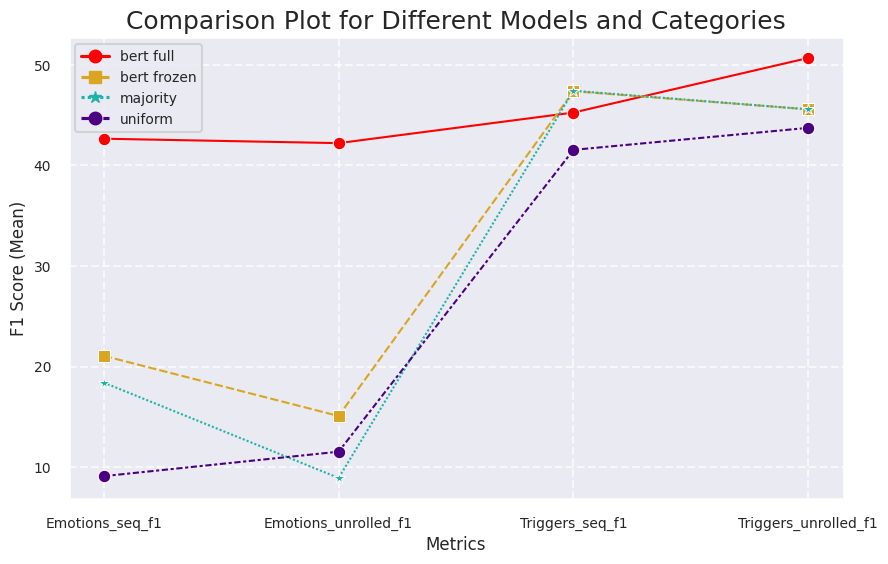

In [9]:
"""
Preparing the data for plot.
- Extracting individual features from each input dataframes

- df : pd.DataFrame
    Dataframe of prediction metrics

Plotting metric-wise and averaged F1-scores comparing all models
"""

metrics = ['Emotions_seq_f1', 'Emotions_unrolled_f1', 'Triggers_seq_f1', 'Triggers_unrolled_f1']
Models= ['bert full', 'bert frozen', 'majority', 'uniform']
bert_f1= [42.65,42.21, 45.25, 50.68]
bert_f_f1= [21.06,15.08, 47.37, 45.57]
majority_f1=  [18.40,8.92, 47.42, 45.57] 
uniform_f1 =  [9.10,11.53, 41.54, 43.73]
data = {
        'Metrics': metrics * 4,  # Repeat categories for both models
        'F1 Score': bert_f1 + bert_f_f1 + majority_f1+ uniform_f1,
        'Model': [Models[0]] * len(metrics) + [Models[1]] * len(metrics) + [Models[2]] * len(metrics) + [Models[3]] * len(metrics)
    }
df = pd.DataFrame(data)

# Setting style and context
sns.set(style="darkgrid")
sns.set_context("talk")
plt.rc('axes', labelsize=12)
plt.figure(figsize=(10, 6))
markers = {Models[0]: 'o', Models[1]: 's', Models[2]: '*', Models[3]: 'o'}

# Line plot for F1 scores
line_plot = sns.lineplot(x='Metrics', y='F1 Score', hue='Model', data=df, markers=markers, style='Model', palette={Models[0]: 'red', Models[1]: 'goldenrod', Models[2]: 'lightseagreen', Models[3]: 'indigo'},linewidth=1.5)#, palette={'Uniform Model': 'blue', 'Most Frequent Model': 'orange'})


# Add labels and title
plt.xlabel('Metrics')
plt.ylabel('F1 Score (Mean)')
plt.title('Comparison Plot for Different Models and Categories')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='both', linestyle='--', alpha=0.7)
# Show the plot
plt.legend(fontsize=10)
plt.show()

# Error Analysis

In [32]:
def plot_confusion_matrix(labels: List[str], preds: List[str], labels_order: List[str], title: str = "Confusion Matrix"):
    cm = confusion_matrix(labels, preds, labels=labels_order)
    cm_df = pd.DataFrame(cm, index=labels_order, columns=labels_order)
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", linewidths=.5)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
    

# Emotions Statistics (Full Bert)

              precision    recall  f1-score   support



     neutral       0.72      0.66      0.69      1522

    surprise       0.52      0.77      0.62       432

        fear       0.07      0.20      0.11        71

     sadness       0.49      0.48      0.49       365

         joy       0.52      0.48      0.50       603

     disgust       0.25      0.29      0.27       145

       anger       0.54      0.33      0.41       478



    accuracy                           0.56      3616

   macro avg       0.44      0.46      0.44      3616

weighted avg       0.58      0.56      0.56      3616




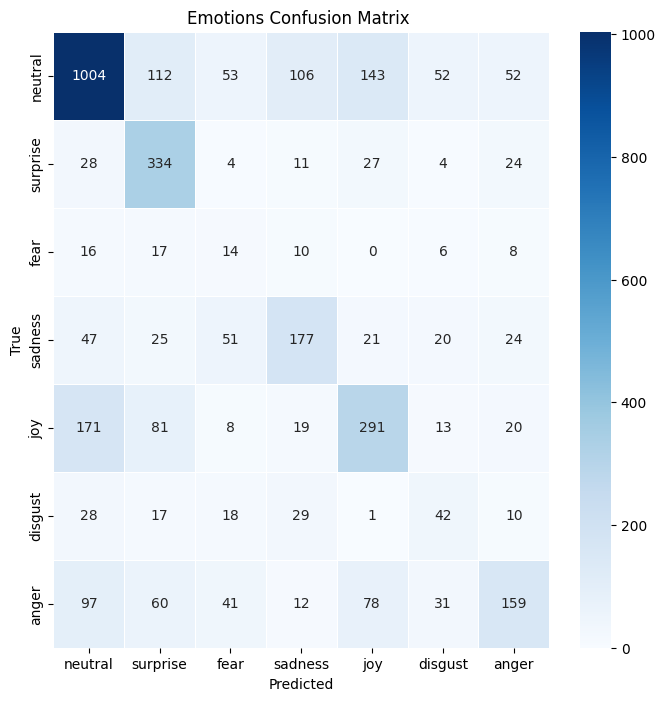

In [31]:
display_markdown("# Emotions Statistics (Full Bert)")
emotion_predictions = pred_nf[3]['emo_pred']
print(classification_report(emotions_true,
                            emotion_predictions,
                            target_names=label2id.keys(), zero_division=1))

plot_confusion_matrix([id2label[emotion] for emotion in emotions_true], [id2label[emotion] for emotion in emotion_predictions], unique_emotions,
                        f"Emotions Confusion Matrix ")

# Triggers Statistics (Full Bert)

              precision    recall  f1-score   support



         0.0       0.90      0.82      0.86      3088

         1.0       0.30      0.47      0.37       528



    accuracy                           0.77      3616

   macro avg       0.60      0.64      0.61      3616

weighted avg       0.81      0.77      0.79      3616




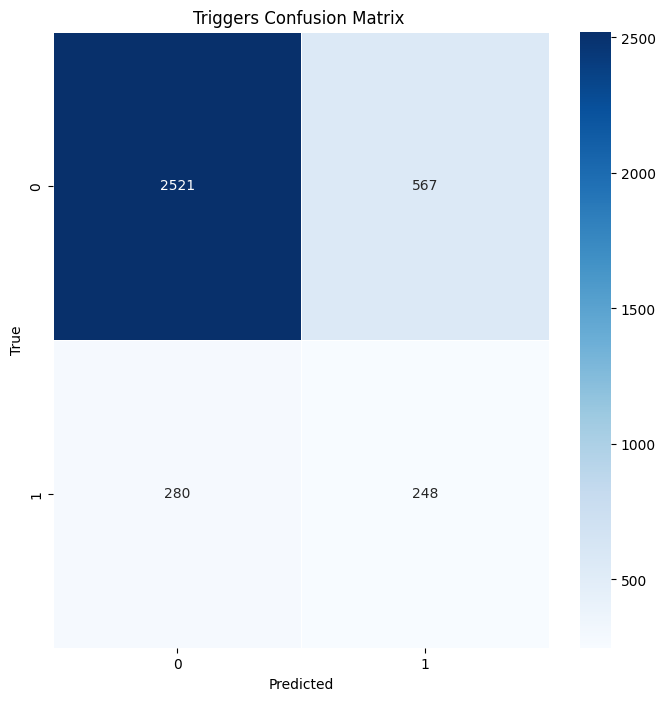

In [37]:
display_markdown("# Triggers Statistics (Full Bert)")
trigger_predictions = pred_nf[3]['trigg_pred']
print(classification_report(triggers_true,
                            trigger_predictions, zero_division=1))

plot_confusion_matrix( triggers_true, trigger_predictions,[0,1],
                        f"Triggers Confusion Matrix ")

# Emotions Statistics (Frozen Bert)

              precision    recall  f1-score   support



     neutral       0.50      0.61      0.55      1718

    surprise       0.16      0.20      0.18       432

        fear       1.00      0.00      0.00        74

     sadness       0.06      0.01      0.01       301

         joy       0.23      0.39      0.28       643

     disgust       1.00      0.00      0.00       117

       anger       1.00      0.00      0.01       497



    accuracy                           0.37      3782

   macro avg       0.56      0.17      0.15      3782

weighted avg       0.47      0.37      0.32      3782




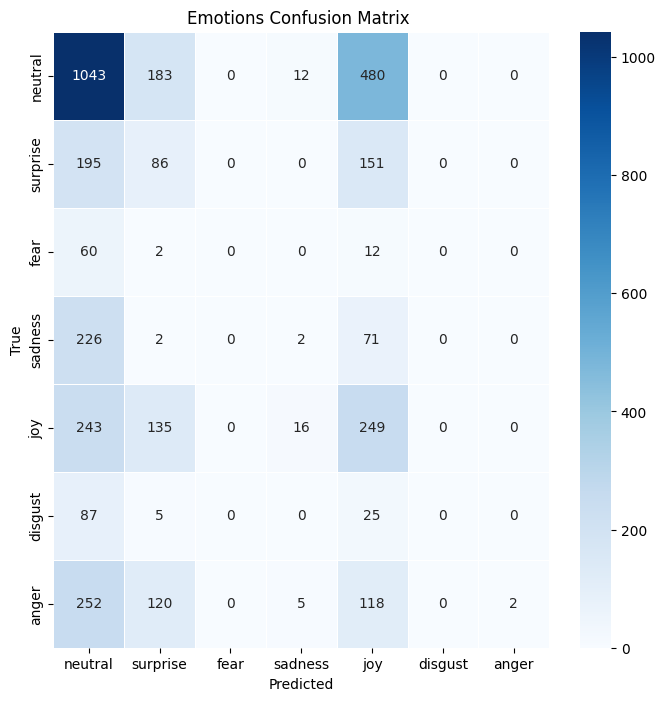

In [33]:
display_markdown("# Emotions Statistics (Frozen Bert)")
emotion_predictions = pred_f[3]['emo_pred']
print(classification_report(emotions_true,
                            emotion_predictions,
                            target_names=label2id.keys(), zero_division=1))

plot_confusion_matrix([id2label[emotion] for emotion in emotions_true], [id2label[emotion] for emotion in emotion_predictions], unique_emotions,
                        f"Emotions Confusion Matrix ")

# Triggers Statistics (Frozen Bert)

              precision    recall  f1-score   support



         0.0       0.84      1.00      0.91      3167

         1.0       0.00      0.00      0.00       615



    accuracy                           0.84      3782

   macro avg       0.42      0.50      0.46      3782

weighted avg       0.70      0.84      0.76      3782




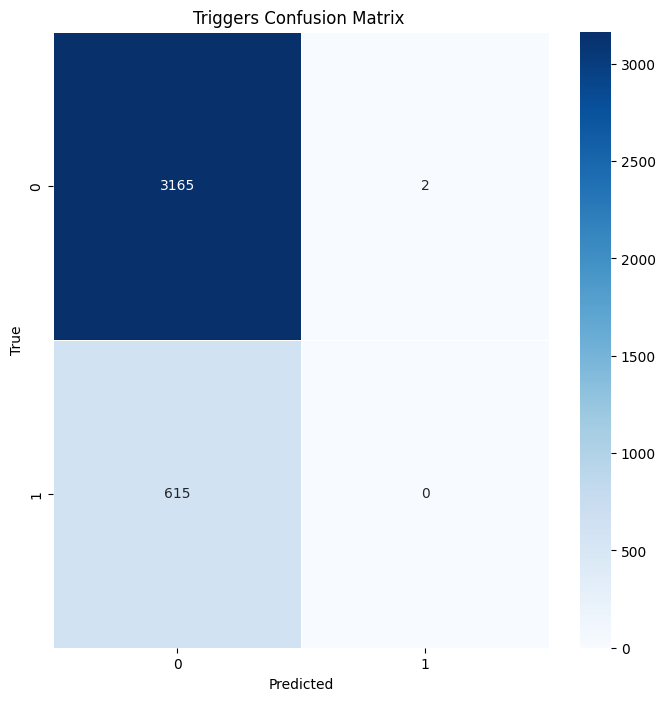

In [34]:
display_markdown("# Triggers Statistics (Frozen Bert)")
trigger_predictions = pred_f[3]['trigg_pred']
print(classification_report(triggers_true,
                            trigger_predictions, zero_division=1))

plot_confusion_matrix( triggers_true, trigger_predictions,[0,1],
                        f"Triggers Confusion Matrix ")